# Problem Statement

This notebook serves as the full executable code of my final project for the CQF program.

The objective is to develop a model that predicts **daily upward movements** in the stock price of [**Adobe**](https://www.adobe.com/) (ticker: ADBE), using Long Short-Term Memory (LSTM) networks. The choice of Adobe pays tribute to my early career as a graphic designer, during which Adobe tools accompanied me through one of the most creative periods of my life.

The target variable is a binomial classification labeled as $[0, 1]$, where $1$ indicates a positive price movement. The model will be trained, evaluated, and tested on a five-year dataset spanning **from January 1, 2020 to July 1, 2025**.

All trading data is sourced directly from the [**MacroTrends website**](https://www.macrotrends.net/) and stored locally in the `./data` folder.


<a id='content'></a>
# Content # 
#### [1. Preparation](#1)
- [1.1 Basic setups](#1.1)
- [1.2 Import trading data of Adobe](#1.2)

#### [2. Feature Engineering](#2)
- [2.1 Define the target](#2.1)
    - [2.1.1 Decide the threshold](#2.1.1)
    - [2.1.2 Check class imbalance](#2.1.2)
- [2.2 Generate features](#2.2)
    - [2.2.1 Features from trading data](#2.2.1)
        - [2.2.1.1 Weekday transformation](#2.2.1.1)
        - [2.2.1.2 Technical features from trading data](#2.2.1.2)
    - [2.2.2 Features from other resources](#2.2.2)
    - [2.2.3 Features from macro environment](#2.2.3)
        - [2.2.3.1 Features from QQQ](#2.2.3.1)
        - [2.2.3.2 Features from macro economy](#2.2.3.2)
#### [3. Exploratory Data Analysis (EDA)](#3)
- [3.1 Structural evaluation](#3.1)
    - [3.1.1 Handle the missing values](#3.1.1)
    - [3.1.2 Create the feature dataframe X and the target series y](#3.1.2)
    - [3.1.3 Explore feature distribution and analyze outliers](#3.1.3)
        - [3.1.3.1 Visualize the features](#3.1.3.1)
        - [3.1.3.2 Group the features](#3.1.3.2)
        - [3.1.3.3 Scale the features](#3.1.3.3)
- [3.2 SHAP analysis and feature relationship exploration](#3.2)
    - [3.2.1 SHAP analysis](#3.2.1)
    - [3.2.2 Explore relationships among high-impact features](#3.2.2)
- [3.3 Analyze multi-collinearity and reduce dimensionality](#3.3)
    - [3.3.1 VIF analysis and correlation heatmap](#3.3.1)
    - [3.3.2 Reduce dimensionality](#3.3.2)
        - [3.3.2.1 Cluster-based selection](#3.3.2.1)
        - [3.3.2.2 Correlation-based selection](#3.3.2.2)
#### [4. Model Building](#4)
- [4.1 Prepare dataset](#4.1)
    - [4.1.1 Split and scale the dataset](#4.1.1)
    - [4.1.2 Create data generator](#4.1.2)
- [4.2 Baseline model - 2 layer LSTM model without dropout](#4.2)
    - [4.2.1 Build the model (2 layers without dropout)](#4.2.1)
    - [4.2.2 Evaluate the model (2 layers without dropout)](#4.2.2)
        - [4.2.2.1 Evaluate the training data against the testing data](#4.2.2.1)
        - [4.2.2.2 Use the model to generate predictions on the testing data and conduct a more comprehensive performance analysis](#4.2.2.2)
        - [4.2.2.3 Baseline model evaluation summary](#4.2.2.3)
- [4.3 Variant model A - 2 layer LSTM model with dropout](#4.3)
    - [4.3.1 Build the model (2 layers with dropout)](#4.3.1)
    - [4.3.2 Evaluate the model (2 layers with dropout)](#4.3.2)
        - [4.3.2.1 Evaluate the training data against the testing data](#4.3.2.1)
        - [4.3.2.2 Use the model to generate predictions on the testing data and conduct a more comprehensive performance analysis](#4.3.2.2)
        - [4.3.2.3 Model evaluation summary](#4.3.2.3)
- [4.4 Variant model B - 3 layer LSTM model without dropout](#4.4)
    - [4.4.1 Build the model (3 layers without dropout)](#4.4.1)
    - [4.4.2 Evaluate the model (3 layers without dropout)](#4.4.2)
        - [4.4.2.1 Evaluate the training data against the testing data](#4.4.2.1)
        - [4.4.2.2 Use the model to generate predictions on the testing data and conduct a more comprehensive performance analysis](#4.4.2.2)
        - [4.4.2.3 Baseline model evaluation summary](#4.4.2.3)
- [4.5 Variant model C - 3 layer LSTM model with dropout](#4.5)
    - [4.5.1 Build the model (3 layers with dropout)](#4.5.1)
    - [4.5.2 Evaluate the model (3 layers with dropout)](#4.5.2)
        - [4.5.2.1 Evalute the training data against the testing data](#4.5.2.1)
        - [4.5.2.2 Use the model to generate predictions on the testing data and conduct a more comprehensive performance analysis](#4.5.2.2)
        - [4.5.2.3 Model evaluation summary](#4.5.2.3)
- [4.6 Review of all the models](#4.6)
#### [5. Trading strategy with backtesting](#5)
- [5.1 Profit analysis](#5.1)
- [5.2 Sharpe ratio analysis](#5.2)
- [5.3 Underwater curve analysis](#5.3)
- [5.4 Pyfolio analysis](#5.4)
#### [6. Conclusion](#6)

<a id='1'></a>
# 1. Preparation

<a id='1.1'></a>
## 1.1 Basic setups

In [1]:
# Import all the libraries
from config import *

In [2]:
# Set global seeds to counter the randomness from Python, NumPy, and TensorFlow. But this won't entirely guarantee determinism.
SEED = 25
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [3]:
# Display option: keep 3 decimals for this notebook
pd.set_option('display.float_format', '{:.3f}'.format)

In [4]:
# Activate TensorBoard extension
%load_ext tensorboard

[**Back to Content**](#content)

<a id='1.2'></a>
## 1.2 Import trading data of Adobe

Create a function to import trading data in MacoTrends format.

In [5]:
def get_MacroTrends_data(filename: str):
    df = pd.read_csv(
        './data/' + filename,
        dtype={
            'close': float,
            'high': float,
            'low': float,
            'open': float,
            'volume': int
        },
        parse_dates=['date'],
        dayfirst=True
    )
    df = df.set_index('date')
    df.index = pd.to_datetime(df.index)  # Ensure index is datetime
    df['weekday'] = df.index.dayofweek.map({0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri'}) #Include the weekday information
    df = df['2020-01-01':'2025-07-01'] # make the data is between 1 Jan 2020 and 1 July 2025
    return df

Use the function to import Adobe trading data.

In [6]:
df = get_MacroTrends_data('MacroTrends_Data_Download_ADBE.csv')

/var/folders/sj/km6fyx_57pn857bnxsqvkj_80000gn/T/ipykernel_50424/2126107501.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(


Check the imported data.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1381 entries, 2020-01-02 to 2025-07-01
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   open     1381 non-null   float64
 1   high     1381 non-null   float64
 2   low      1381 non-null   float64
 3   close    1381 non-null   float64
 4   volume   1381 non-null   int64  
 5   weekday  1381 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 75.5+ KB


In [8]:
df.head()

open    high     low   close   volume weekday
date                                                       
2020-01-02 330.000 334.480 329.170 334.430  1990496     Thu
2020-01-03 329.170 332.980 328.690 331.810  1579368     Fri
2020-01-06 328.290 333.910 328.190 333.710  1875122     Mon
2020-01-07 334.150 334.790 332.305 333.390  2507261     Tue
2020-01-08 333.810 339.230 333.400 337.870  2248531     Wed

In [9]:
df.isnull().sum()

open       0
high       0
low        0
close      0
volume     0
weekday    0
dtype: int64

In [10]:
df.describe().T

count        mean         std        min         25%         50%  \
open   1381.000     466.742      93.730    277.800     384.970     470.480   
high   1381.000     472.594      93.930    279.590     390.130     475.867   
low    1381.000     460.621      93.216    255.131     380.945     462.480   
close  1381.000     466.773      93.617    275.200     385.710     469.730   
volume 1381.000 3149150.357 1864608.743 589182.000 2104030.000 2660097.000   

               75%          max  
open       526.035      696.275  
high       533.510      699.540  
low        519.560      678.910  
close      526.940      688.370  
volume 3582532.000 27840211.000

Everything looks good.

[**Back to Content**](#content)

<a id='2'></a>
# 2. Feature Engineering

In this chapter, I will define the target of the project and create all the possible features with different techniques.

<a id='2.1'></a>
## 2.1 Define the target

<a id='2.1.1'></a>
### 2.1.1 Decide the threshold

Since this project focuses on predicting the direction of daily returns as a binomial classification $[0, 1]$, it's essential to establish a threshold for distinguishing between positive and negative returns.

Before determining a suitable classification threshold, we will explore the data. The close price is used to represent the daily price od Adobe. Let's observe how the values in `close` was evolving in the past 5 years.

Text(0, 0.5, 'Close Price ($)')

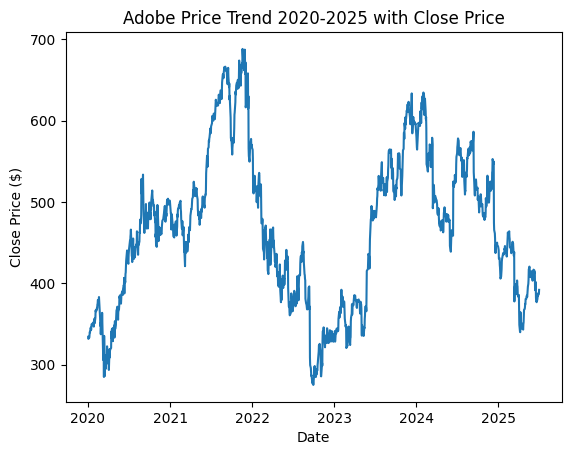

In [11]:
plt.plot(df['close'])
plt.title("Adobe Price Trend 2020-2025 with Close Price") 
plt.xlabel("Date")
plt.ylabel("Close Price ($)")

Over the past five years, Adobe's price has shown significant volatility with a slight upward drift.

To analyze this further, I will create a `return` column and examine the distribution of the daily return.

In [12]:
df['return'] = df['close'].pct_change(1) 

In [13]:
df.head()

open    high     low   close   volume weekday  return
date                                                               
2020-01-02 330.000 334.480 329.170 334.430  1990496     Thu     NaN
2020-01-03 329.170 332.980 328.690 331.810  1579368     Fri  -0.008
2020-01-06 328.290 333.910 328.190 333.710  1875122     Mon   0.006
2020-01-07 334.150 334.790 332.305 333.390  2507261     Tue  -0.001
2020-01-08 333.810 339.230 333.400 337.870  2248531     Wed   0.013

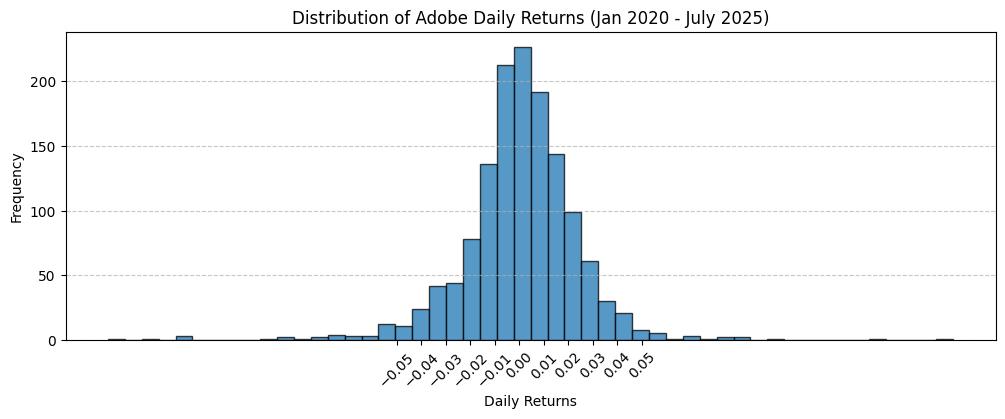

In [14]:
# Plot histogram of daily returns
plt.figure(figsize=(12, 4))
plt.hist(df['return'], bins=50, edgecolor='black', alpha=0.75)

# Customize x-axis tick values
x_ticks = np.arange(-0.05, 0.06, 0.01)  # Adjust range as needed
plt.xticks(x_ticks, rotation=45)  # Rotates labels by 45 degrees

# Labels & Grid
plt.xlabel("Daily Returns")
plt.ylabel("Frequency")
plt.title("Distribution of Adobe Daily Returns (Jan 2020 - July 2025)")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()

As illustrated in the histogram, Adobe's daily returns exhibit a roughly normal distribution with a slight positive skew.

To optimize classification performance, I set the threshold at $0.2\%$ for the following reasons:

- It approximately splits the dataset evenly, minimizing class imbalance and helping stabilize model training.

- The primary objective is to generate meaningful predictions for positive market moves (class 1). A positive threshold ensures that class 1 predictions are significant if the model performs well, while also providing room to account for transaction costs in reality.

Under this target definition:

- A value of $1$ is assigned when the next day's closing price is at least $0.2\%$ higher than the current day's close, indicating a potential buying opportunity. Otherwise, no action is taken.

- Returns below $0.2\%$ are labeled as $0$.

In [15]:
#Apply the threshold.
threshold = 0.002
df['target'] = (df['return'].shift(-1) > threshold).astype(int)

In [16]:
#check the data with target based on the threshold.
df.head()

open    high     low   close   volume weekday  return  target
date                                                                       
2020-01-02 330.000 334.480 329.170 334.430  1990496     Thu     NaN       0
2020-01-03 329.170 332.980 328.690 331.810  1579368     Fri  -0.008       1
2020-01-06 328.290 333.910 328.190 333.710  1875122     Mon   0.006       0
2020-01-07 334.150 334.790 332.305 333.390  2507261     Tue  -0.001       1
2020-01-08 333.810 339.230 333.400 337.870  2248531     Wed   0.013       1

[**Back to Content**](#content)

<a id='2.1.2'></a>
### 2.1.2 Check class imbalance

In [17]:
df['target'].value_counts()

target
0    715
1    666
Name: count, dtype: int64

In [18]:
print(
    f"With a threshold of {threshold*100}%, "
    f"class 0 represents {df['target'].value_counts()[0]/len(df['target'])*100:.2f}% of the data, "
    f"while class 1 represents {df['target'].value_counts()[1]/len(df['target'])*100:.2f}%."
)

With a threshold of 0.2%, class 0 represents 51.77% of the data, while class 1 represents 48.23%.


The data is nearly balanced, so we do not need to be concerned about target imbalance.

[**Back to Content**](#content)

<a id='2.2'></a>
## 2.2 Generate features

<a id='2.2.1'></a>
### 2.2.1 Features from trading data

<a id='2.2.1.1'></a>
#### 2.2.1.1 Weekday transformation
Weekday patterns can influence stock price behavior, so this temporal feature is included in our model.

Instead of using traditional one-hot encoding, which expands weekdays into five separate columns, we apply a trigonometric transformation using sine and cosine functions. This method captures the cyclical nature of weekdays, particularly the continuity between Friday and Monday, while adding only two numerical columns. This improves efficiency and preserves temporal structure.

The formulas for the new features `dsin` and `dcos` are:
$$\text{dsin} =  sin(\frac{2{\pi}*\text{num}}{7})$$
$$\text{dcos} =  cos(\frac{2{\pi}*\text{num}}{7})$$
Where `num` is the numerical representation of the weekday:
- $1$ : Monday

- $2$ : Tuesday

- $3$ : Wednesday

- $4$ : Thursday

- $5$ : Friday

This transformation ensures the model understands the cyclical flow of time without inflating the feature space.

In [19]:
# Define a class to transform weekday information into trigonometric columns.
class WeekDayTransformer(BaseEstimator, TransformerMixin):
                                   
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        self.data = pd.DataFrame(
            {
        'weekday': ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
            }
        )
        self.daysnum = np.array(self.data.index+1)
        return self
    
    
    def transform(self, X): # X is a dataframe
        Xt = X.copy()
        pi = np.pi
        num = Xt.index.weekday+1
        
        Xt['dsin'] = np.sin(2 * pi * num / np.max(self.daysnum))
        Xt['dcos'] = np.cos(2 * pi * num / np.max(self.daysnum))
        Xt = Xt.drop(['weekday'], axis=1)
        
        return Xt

In [20]:
# Initiate an instance of the transformer class
dtrans= WeekDayTransformer()

# Fit the data
dtrans.fit(df)

WeekDayTransformer()

In [21]:
# Transform
df = dtrans.transform(df)

#Check the data after transforming the weekday data
df.head()

open    high     low   close   volume  return  target   dsin  \
date                                                                         
2020-01-02 330.000 334.480 329.170 334.430  1990496     NaN       0 -0.434   
2020-01-03 329.170 332.980 328.690 331.810  1579368  -0.008       1 -0.975   
2020-01-06 328.290 333.910 328.190 333.710  1875122   0.006       0  0.782   
2020-01-07 334.150 334.790 332.305 333.390  2507261  -0.001       1  0.975   
2020-01-08 333.810 339.230 333.400 337.870  2248531   0.013       1  0.434   

             dcos  
date               
2020-01-02 -0.901  
2020-01-03 -0.223  
2020-01-06  0.623  
2020-01-07 -0.223  
2020-01-08 -0.901

[**Back to Content**](#content)

<a id='2.2.1.2'></a>
#### 2.2.1.2 Technical features from trading data
Then, I will leverage the function of `add_all_ta_features` from `ta` library to automatically generate a wide range of technical indicators from the OHLCV (open, high, low, close, volume) data. This step efficiently enriches the dataset with 80+ indicators across the following categories:

- **Volume**: OBV, CMF, MFI, NVI, ATR, etc.

- **Volatility**: Bollinger Bands, Keltner Channels, Donchian Channels, etc.

- **Trend**: SMA, EMA, MACD, ADX, Ichimoku, Parabolic SAR, Aroon, etc.

- **Momentum**: RSI, Stochastic RSI, ROC, PPO, TSI, etc.

- **Others**: daily returns, log returns, cumulative returns, etc.

After generation, further feature refinement steps are applied:

**1. Remove redundant return feature**  
Since the daily return is already present in the dataset, the duplicated `others_dr` feature generated by `add_all_ta_features` is dropped to avoid redundancy.


**2. Consolidate sparse PSAR trend signals**  
Among the trend indicators generated by `add_all_ta_features`, `trend_psar_up` and `trend_psar_down` exhibit a high number of missing values due to the mechanics of the Parabolic SAR (PSAR), which trails price movements using a dynamic stop level. The PSAR is computed as:

$$
PSAR_t = PSAR_{t−1} + AF \cdot (EP_{t−1} − PSAR_{t−1})
$$
Where:
- $AF$ is the acceleration factor, starting at $0.02$ and capped at $0.2$

- $EP$ is the extreme point (highest high during an uptrend or lowest low during a downtrend) 

Explanation of the features:
- `trend_psar_up`: Contains PSAR values during uptrends (dots below price), otherwise NaN

- `trend_psar_down`: Contains PSAR values during downtrends (dots above price), otherwise NaN

To simplify, I create a new feature column `psar_trend` with directional encoding to interpret the information from these 2 features:

- `1` for uptrend

- `-1` for downtrend

- `0` for neutral

After generating `psar_trend`, the original two PSAR columns are removed to reduce sparsity and simplify the feature set.

**3. Transform drift/non-stationary price-reflective features**  
Several generated features directly reflect price movement, inheriting drift and non-stationarity:
- `trend_sma_fast`, `trend_sma_slow`, `trend_ema_fast`, `trend_ema_slow`

- `trend_ichimoku_conv`, `trend_ichimoku_base`, `trend_ichimoku_a`, `trend_ichimoku_b`

- `trend_visual_ichimoku_a`, `trend_visual_ichimoku_b` 

Using standard or minmax scalers on them would cause data leakage, as future non-stationary values affect scaling. To address this, these features are converted into relative ratios by being divided with the day’s closing price. For example:  
$$\text{trend\_sma\_fast\_div\_close} = \frac{\text{trend\_sma\_fast}}{\text{close}}$$
This transformation reduces drift, normalizes scale, and preserves interpretability without leakage. The original columns of them are then removed and replaced by the newly created ones.

**4. Add more features for daily variance**  
Finally, I manually include two basic range-based features to capture intraday price movement:
$$\text{h-l} = \text{high} - \text{low}$$
$$\text{o-c} = \text{open} - \text{close}$$

In [22]:
#create a function to create features from trading data
def add_trading_features (df):
    #use add_all_ta_features to generate features
    df = add_all_ta_features(
        df,
        #indicate the OHLCV columns
        open='open', high='high', low='low', close='close', volume='volume'
    )

    #remove the column of daily return as it was already included
    df.drop(columns=['others_dr'], inplace=True)

    #process PSAR related columns
    df['psar_trend'] = df['trend_psar_up'].notna().astype(int) - df['trend_psar_down'].notna().astype(int)
    df.drop(columns=['trend_psar_up', 'trend_psar_down'], inplace=True)

    #process features with drift and non-stationary
    drift_features = ['trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
                      'trend_ichimoku_conv', 'trend_ichimoku_base', 'trend_ichimoku_a', 'trend_ichimoku_b',
                      'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b'
                     ]
    for col in drift_features:
        df[col + '_div_close'] = df[col] / df['close']
        df.drop(columns = [col], inplace = True)

    #generate 2 more features to show the variance within the day
    df['h-l'] = df['high'] - df['low']
    df['o-c'] = df['open'] - df['close']
    
    # return the dataframe regardless of the NA values. We will remove them collectively later
    return df

In [23]:
#generate the features
df = add_trading_features(df)

/opt/anaconda3/envs/py310/lib/python3.10/site-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


Check the dataset after feature generation from trading data.

In [24]:
df.shape

(1381, 95)

In [25]:
df.head()

open    high     low   close   volume  return  target   dsin  \
date                                                                         
2020-01-02 330.000 334.480 329.170 334.430  1990496     NaN       0 -0.434   
2020-01-03 329.170 332.980 328.690 331.810  1579368  -0.008       1 -0.975   
2020-01-06 328.290 333.910 328.190 333.710  1875122   0.006       0  0.782   
2020-01-07 334.150 334.790 332.305 333.390  2507261  -0.001       1  0.975   
2020-01-08 333.810 339.230 333.400 337.870  2248531   0.013       1  0.434   

             dcos  volume_adi  ...  trend_ema_fast_div_close  \
date                           ...                             
2020-01-02 -0.901 1953010.200  ...                       NaN   
2020-01-03 -0.223 2670904.745  ...                       NaN   
2020-01-06  0.623 4414899.332  ...                       NaN   
2020-01-07 -0.223 4097077.516  ...                       NaN   
2020-01-08 -0.901 5296551.171  ...                       NaN   

            trend_ema_slow_div_close  trend_ichimoku_conv_div_close  \
date                                                                  
2020-01-02                       NaN                            NaN   
2020-01-03                       NaN                            NaN   
2020-01-06                       NaN                            NaN   
2020-01-07                       NaN                            NaN   
2020-01-08                       NaN                            NaN   

            trend_ichimoku_base_div_close  trend_ichimoku_a_div_close  \
date                                                                    
2020-01-02                            NaN                         NaN   
2020-01-03                            NaN                         NaN   
2020-01-06                            NaN                         NaN   
2020-01-07                            NaN                         NaN   
2020-01-08                            NaN                         NaN   

            trend_ichimoku_b_div_close  trend_visual_ichimoku_a_div_close  \
date                                                                        
2020-01-02                       0.992                              1.399   
2020-01-03                       0.999                              1.410   
2020-01-06                       0.993                              1.402   
2020-01-07                       0.994                              1.404   
2020-01-08                       0.988                              1.385   

            trend_visual_ichimoku_b_div_close   h-l    o-c  
date                                                        
2020-01-02                              1.389 5.310 -4.430  
2020-01-03                              1.400 4.290 -2.640  
2020-01-06                              1.392 5.720 -5.420  
2020-01-07                              1.394 2.485  0.760  
2020-01-08                              1.375 5.830 -4.060  

[5 rows x 95 columns]

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1381 entries, 2020-01-02 to 2025-07-01
Data columns (total 95 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   open                               1381 non-null   float64
 1   high                               1381 non-null   float64
 2   low                                1381 non-null   float64
 3   close                              1381 non-null   float64
 4   volume                             1381 non-null   int64  
 5   return                             1380 non-null   float64
 6   target                             1381 non-null   int64  
 7   dsin                               1381 non-null   float64
 8   dcos                               1381 non-null   float64
 9   volume_adi                         1381 non-null   float64
 10  volume_obv                         1381 non-null   int64  
 11  volume_cmf                         136

The data is looking good.

[**Back to Content**](#content)

<a id='2.2.2'></a>
### 2.2.2 Features from other resources

Stock prices can be influenced by a variety of factors beyond trading data itself—such as investor sentiment reflected in news coverage, CDS spreads, and dividend history.

After thorough research, I found that Adobe’s CDS spread data is not publicly available, and the company has not issued any dividends since 2005. As a result, this section will focus on extracting sentiment signals from Adobe-related news headlines published between 1 Jan 2020 and 1 July 2025.

The news data was downloaded and processed in the `DL Tuo Li Appendix_news_process.ipynb` notebook and saved as a CSV file. I will import this file and merge it with the main dataset to continue feature preparation.

In [27]:
#Import the news title with sentiment features, align its format with the main dataset.
df_news = pd.read_csv('./data/news_with_sentiment_filled.csv')

#Process the structure of the news dataframe to align with our main dataframe
df_news = df_news.rename(columns = {'Date':'date',
                                    'sentiment score' : 'news_sentiment_score',
                                    'emotion intensity' : 'news_emotion_intensity'}).set_index('date').drop(columns = ['Title'])

#Ensure index is datetime
df_news.index = pd.to_datetime(df_news.index)

The imported dataframe is indexed by date, spanning from January 1, 2020 to July 1, 2025, aligning with the main dataset. It contains two columns that quantify news-driven signals for each calendar day:

- `news_sentiment_score`: indicates whether the news titles expressed a positive and negative feeling that could impact Adobe's price. The value is between $-1$ and $1$, and $-1$ means highly negative, $0$ means nuetral while $1$ means highly positive. 

- `news_emotion_intensity`: determines if the titles' emotion is high or Low. The value ranges from $0$ to $1$, and $0$ means extremely low while $1$ means extremely high. 

These metrics were generated by the AI LLM model that automatically analyzed daily Adobe news titles. If no relevant news was published on a particular day, that date is omitted from the index.


In [28]:
df_news.head()

news_sentiment_score  news_emotion_intensity
date                                                    
2020-01-01                 0.000                   0.000
2020-01-03                 0.450                   0.580
2020-01-06                 0.000                   0.000
2020-01-09                 0.150                   0.400
2020-01-10                 0.000                   0.000

In [29]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1068 entries, 2020-01-01 to 2025-07-01
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   news_sentiment_score    1068 non-null   float64
 1   news_emotion_intensity  1068 non-null   float64
dtypes: float64(2)
memory usage: 25.0 KB


In [30]:
#Inlude the features into our main dataframe, with consideration that the merged dataframe should have the same index as df.
df_news_aligned = df_news.reindex(df.index)
df = pd.concat([df, df_news_aligned], axis=1)

#If there is a day without any news, just treat both its news sentiment score and news emotion intensity as zeros.
df['news_sentiment_score'] = df['news_sentiment_score'].fillna(0)
df['news_emotion_intensity'] = df['news_emotion_intensity'].fillna(0)

In [31]:
df.head()

open    high     low   close   volume  return  target   dsin  \
date                                                                         
2020-01-02 330.000 334.480 329.170 334.430  1990496     NaN       0 -0.434   
2020-01-03 329.170 332.980 328.690 331.810  1579368  -0.008       1 -0.975   
2020-01-06 328.290 333.910 328.190 333.710  1875122   0.006       0  0.782   
2020-01-07 334.150 334.790 332.305 333.390  2507261  -0.001       1  0.975   
2020-01-08 333.810 339.230 333.400 337.870  2248531   0.013       1  0.434   

             dcos  volume_adi  ...  trend_ichimoku_conv_div_close  \
date                           ...                                  
2020-01-02 -0.901 1953010.200  ...                            NaN   
2020-01-03 -0.223 2670904.745  ...                            NaN   
2020-01-06  0.623 4414899.332  ...                            NaN   
2020-01-07 -0.223 4097077.516  ...                            NaN   
2020-01-08 -0.901 5296551.171  ...                            NaN   

            trend_ichimoku_base_div_close  trend_ichimoku_a_div_close  \
date                                                                    
2020-01-02                            NaN                         NaN   
2020-01-03                            NaN                         NaN   
2020-01-06                            NaN                         NaN   
2020-01-07                            NaN                         NaN   
2020-01-08                            NaN                         NaN   

            trend_ichimoku_b_div_close  trend_visual_ichimoku_a_div_close  \
date                                                                        
2020-01-02                       0.992                              1.399   
2020-01-03                       0.999                              1.410   
2020-01-06                       0.993                              1.402   
2020-01-07                       0.994                              1.404   
2020-01-08                       0.988                              1.385   

            trend_visual_ichimoku_b_div_close   h-l    o-c  \
date                                                         
2020-01-02                              1.389 5.310 -4.430   
2020-01-03                              1.400 4.290 -2.640   
2020-01-06                              1.392 5.720 -5.420   
2020-01-07                              1.394 2.485  0.760   
2020-01-08                              1.375 5.830 -4.060   

            news_sentiment_score  news_emotion_intensity  
date                                                      
2020-01-02                 0.000                   0.000  
2020-01-03                 0.450                   0.580  
2020-01-06                 0.000                   0.000  
2020-01-07                 0.000                   0.000  
2020-01-08                 0.000                   0.000  

[5 rows x 97 columns]

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1381 entries, 2020-01-02 to 2025-07-01
Data columns (total 97 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   open                               1381 non-null   float64
 1   high                               1381 non-null   float64
 2   low                                1381 non-null   float64
 3   close                              1381 non-null   float64
 4   volume                             1381 non-null   int64  
 5   return                             1380 non-null   float64
 6   target                             1381 non-null   int64  
 7   dsin                               1381 non-null   float64
 8   dcos                               1381 non-null   float64
 9   volume_adi                         1381 non-null   float64
 10  volume_obv                         1381 non-null   int64  
 11  volume_cmf                         136

The inclusion of news sentiment features is completed.

[**Back to Content**](#content)

<a id='2.2.3'></a>
### 2.2.3 Features from macro environment

<a id='2.2.3.1'></a>
#### 2.2.3.1 Features from QQQ

Invesco QQQ (ticker: QQQ) is an exchange-traded fund (ETF) that tracks the Nasdaq-100 Index, which includes 100 of the largest non-financial companies listed on the Nasdaq, such as Apple, Amazon, Adobe and Nvidia.

It is heavily weighted toward large-cap technology stocks, and often viewed as a proxy for the tech sector’s overall health. QQQ's price reflects aggregated investor sentiment toward high-growth, large-cap tech stocks.

QQQ can act as a sentiment barometer for Adobe’s ecosystem. Including QQQ data will improve the model’s ability to predict uptrend probabilities by incorporating macro and sector signals.

Import QQQ trading data.

In [33]:
df_qqq = get_MacroTrends_data('MacroTrends_Data_Download_QQQ.csv')

/var/folders/sj/km6fyx_57pn857bnxsqvkj_80000gn/T/ipykernel_50424/2126107501.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(


Check the data.

In [34]:
df_qqq.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1381 entries, 2020-01-02 to 2025-07-01
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   open     1381 non-null   float64
 1   high     1381 non-null   float64
 2   low      1381 non-null   float64
 3   close    1381 non-null   float64
 4   volume   1381 non-null   int64  
 5   weekday  1381 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 75.5+ KB


In [35]:
df_qqq.head()

open    high     low   close    volume weekday
date                                                        
2020-01-02 207.096 208.796 206.690 208.796  29958247     Thu
2020-01-03 206.023 208.129 206.014 206.883  26594637     Fri
2020-01-06 205.251 208.245 205.009 208.216  20986764     Mon
2020-01-07 208.293 208.776 207.530 208.187  22333269     Tue
2020-01-08 208.129 210.708 207.830 209.752  25562588     Wed

In [36]:
df_qqq.isnull().sum()

open       0
high       0
low        0
close      0
volume     0
weekday    0
dtype: int64

In [37]:
df_qqq.describe().T

count         mean          std          min          25%  \
open   1381.000      353.366       89.170      165.448      287.310   
high   1381.000      356.212       89.304      168.633      289.908   
low    1381.000      350.316       88.836      159.650      283.839   
close  1381.000      353.462       89.109      163.532      286.743   
volume 1381.000 48326455.122 21716833.598 15225092.000 33335184.000   

                50%          75%           max  
open        344.309      422.327       551.260  
high        346.220      426.196       552.800  
low         341.277      419.791       549.010  
close       343.896      422.211       551.640  
volume 44701851.000 57932013.000 194966806.000

In order to better leverage the information provided by QQQ trading data, we will also need to perform some feature engineering with this dataset.

First, generate a new feature `qqq_adobe_corr_20` that captures the correlation between QQQ and Adobe daily returns. By calculating a 20-day rolling correlation, this feature reflects sector-level alignment and helps quantify how closely Adobe’s price movements track broader technology trends represented by QQQ.

In [38]:
# Include Adobe's close price
df_qqq['adobe_close'] = df['close']

# Calculate the returns of the 2 assets
df_qqq['return'] = df_qqq['close'].pct_change(1)
df_qqq['adobe_return'] = df_qqq['adobe_close'].pct_change(1) 

# Calculate the 20 day correlation
df_qqq['qqq_adobe_corr_20'] = df_qqq['adobe_return'].rolling(window=20).corr(df_qqq['return'])

In [39]:
df_qqq

open    high     low   close    volume weekday  adobe_close  \
date                                                                        
2020-01-02 207.096 208.796 206.690 208.796  29958247     Thu      334.430   
2020-01-03 206.023 208.129 206.014 206.883  26594637     Fri      331.810   
2020-01-06 205.251 208.245 205.009 208.216  20986764     Mon      333.710   
2020-01-07 208.293 208.776 207.530 208.187  22333269     Tue      333.390   
2020-01-08 208.129 210.708 207.830 209.752  25562588     Wed      337.870   
...            ...     ...     ...     ...       ...     ...          ...   
2025-06-25 542.060 543.310 539.380 541.160  44804200     Wed      387.550   
2025-06-26 543.350 546.670 541.520 546.220  43811400     Thu      384.950   
2025-06-27 547.260 549.990 544.540 548.090  57577100     Fri      385.830   
2025-06-30 551.260 552.800 549.010 551.640  45548700     Mon      386.880   
2025-07-01 549.730 550.710 544.660 546.990  56166700     Tue      392.100   

            return  adobe_return  qqq_adobe_corr_20  
date                                                 
2020-01-02     NaN           NaN                NaN  
2020-01-03  -0.009        -0.008                NaN  
2020-01-06   0.006         0.006                NaN  
2020-01-07  -0.000        -0.001                NaN  
2020-01-08   0.008         0.013                NaN  
...            ...           ...                ...  
2025-06-25   0.003         0.014              0.643  
2025-06-26   0.009        -0.007              0.635  
2025-06-27   0.003         0.002              0.638  
2025-06-30   0.006         0.003              0.661  
2025-07-01  -0.008         0.013              0.638  

[1381 rows x 10 columns]

Then, add technical features from QQQ's trading data. As QQQ's data is only supportive in this project, I won't add the full set of technical features. Instead, I will focus on several key ones:
- 10 day SMA divided by close price and 10 day EMA divided by close price

- ATR, BBANDS, RIS and MACD

- H-L and O-C

In [40]:
def add_trading_features_qqq (df):
    df['qqq_sma_10_div_close'] = SMA(df['close'], 10)/df['close']
    df['qqq_ema_10_div_close'] = EMA(df['close'], 10)/df['close']
    
    df['qqq_atr'] = ATR(df)
    df['qqq_bbands_l'] = BBands(df['close'],5,2)[0]
    df['qqq_bbands_m'] = BBands(df['close'],5,2)[1]
    df['qqq_bbands_u'] = BBands(df['close'],5,2)[2]
    df['qqq_rsi'] = RSI(df['close'], 14)
    df['qqq_macd'] = MACD(df['close'], 5, 12, 26)[0]
    
    df['qqq_h-l'] = df['high'] - df['low']
    df['qqq_o-c'] = df['open'] - df['close']

    df.rename(columns = {'volume':'qqq_volume'}, inplace = True)
    
    # return the dataframe first, we will remove the NA data collectively later
    return df

In [41]:
df_qqq = add_trading_features_qqq(df_qqq)

In [42]:
df_qqq.shape

(1381, 20)

In [43]:
df_qqq.head()

open    high     low   close  qqq_volume weekday  adobe_close  \
date                                                                          
2020-01-02 207.096 208.796 206.690 208.796    29958247     Thu      334.430   
2020-01-03 206.023 208.129 206.014 206.883    26594637     Fri      331.810   
2020-01-06 205.251 208.245 205.009 208.216    20986764     Mon      333.710   
2020-01-07 208.293 208.776 207.530 208.187    22333269     Tue      333.390   
2020-01-08 208.129 210.708 207.830 209.752    25562588     Wed      337.870   

            return  adobe_return  qqq_adobe_corr_20  qqq_sma_10_div_close  \
date                                                                        
2020-01-02     NaN           NaN                NaN                   NaN   
2020-01-03  -0.009        -0.008                NaN                   NaN   
2020-01-06   0.006         0.006                NaN                   NaN   
2020-01-07  -0.000        -0.001                NaN                   NaN   
2020-01-08   0.008         0.013                NaN                   NaN   

            qqq_ema_10_div_close  qqq_atr  qqq_bbands_l  qqq_bbands_m  \
date                                                                    
2020-01-02                 1.000      NaN           NaN           NaN   
2020-01-03                 1.008      NaN           NaN           NaN   
2020-01-06                 1.001      NaN           NaN           NaN   
2020-01-07                 1.001      NaN           NaN           NaN   
2020-01-08                 0.995      NaN       206.279       208.367   

            qqq_bbands_u  qqq_rsi  qqq_macd  qqq_h-l  qqq_o-c  
date                                                           
2020-01-02           NaN      NaN     0.000    2.106   -1.700  
2020-01-03           NaN      NaN    -0.153    2.115   -0.860  
2020-01-06           NaN      NaN    -0.164    3.236   -2.965  
2020-01-07           NaN      NaN    -0.174    1.246    0.106  
2020-01-08       210.455      NaN    -0.054    2.878   -1.623

Finally, select relevant QQQ features, save them in another dataframe and and merge it with the main dataset.

In [44]:
df_qqq_selected_features = df_qqq[['qqq_volume', 'qqq_adobe_corr_20',
                                   'qqq_sma_10_div_close', 'qqq_ema_10_div_close', 'qqq_atr',
                                   'qqq_bbands_l', 'qqq_bbands_m', 'qqq_bbands_u',
                                   'qqq_rsi', 'qqq_macd', 'qqq_h-l', 'qqq_o-c']]

In [45]:
df_qqq_selected_features.tail()

qqq_volume  qqq_adobe_corr_20  qqq_sma_10_div_close  \
date                                                              
2025-06-25    44804200              0.643                 0.983   
2025-06-26    43811400              0.635                 0.977   
2025-06-27    57577100              0.638                 0.976   
2025-06-30    45548700              0.661                 0.974   
2025-07-01    56166700              0.638                 0.985   

            qqq_ema_10_div_close  qqq_atr  qqq_bbands_l  qqq_bbands_m  \
date                                                                    
2025-06-25                 0.984    6.799       520.018       533.445   
2025-06-26                 0.980    6.452       521.058       537.010   
2025-06-27                 0.981    6.341       528.506       541.380   
2025-06-30                 0.979    6.439       535.559       545.378   
2025-07-01                 0.990    6.509       539.252       546.820   

            qqq_bbands_u  qqq_rsi  qqq_macd  qqq_h-l  qqq_o-c  
date                                                           
2025-06-25       546.872   62.291     8.254    3.930    0.900  
2025-06-26       552.962   70.425     8.802    5.150   -2.870  
2025-06-27       554.254   68.525     9.280    5.450   -0.830  
2025-06-30       555.197   70.158     9.832    3.790   -0.380  
2025-07-01       554.388   62.261     9.781    6.050    2.740

In [46]:
# Inlude the features into our main dataframe.
df = pd.concat([df, df_qqq_selected_features], axis=1)

In [47]:
df.shape

(1381, 109)

The inclusion of QQQ related features is completed.

[**Back to Content**](#content)

<a id='2.2.3.2'></a>
#### 2.2.3.2 Features from macro economy

Next, the Federal Funds Effective Rate is very possibly influencing Adobe share price movements, as the technology sector is highly sensitive to borrowing costs and liquidity, both of which are directly affected by rate fluctuations.  

I have sourced monthly data from the Federal Reserve Bank of St. Louis and will incorporate it into the data for analysis.

In [48]:
df_fedrate = pd.read_csv('./data/FEDFUNDS.csv')

#Convert date strings to datetime format
df_fedrate['observation_date'] = pd.to_datetime(df_fedrate['observation_date'], format='%d/%m/%y')

#Reformat to 'YYYY-MM-DD' string if needed
df_fedrate['observation_date'] = df_fedrate['observation_date'].dt.strftime('%Y-%m-%d')

df_fedrate.set_index("observation_date", inplace=True)
df_fedrate.index = pd.to_datetime(df_fedrate.index)

In [49]:
df_fedrate.head()

FEDFUNDS
observation_date          
2020-01-01           1.550
2020-02-01           1.580
2020-03-01           0.650
2020-04-01           0.050
2020-05-01           0.050

As the federal rate data is on a monthly basis, we need to map it to our main dataset using a forward-filling technique, ensuring that in the merged dataset, each day's federal rate correctly aligns with the corresponding monthly value.

In [50]:
df["FEDFUNDS"] = df.index.map(lambda date: df_fedrate["FEDFUNDS"].asof(date))

The inclusion of fed fund rate feature is completed.

Check the dataset now.

In [51]:
df.head()

open    high     low   close   volume  return  target   dsin  \
date                                                                         
2020-01-02 330.000 334.480 329.170 334.430  1990496     NaN       0 -0.434   
2020-01-03 329.170 332.980 328.690 331.810  1579368  -0.008       1 -0.975   
2020-01-06 328.290 333.910 328.190 333.710  1875122   0.006       0  0.782   
2020-01-07 334.150 334.790 332.305 333.390  2507261  -0.001       1  0.975   
2020-01-08 333.810 339.230 333.400 337.870  2248531   0.013       1  0.434   

             dcos  volume_adi  ...  qqq_ema_10_div_close  qqq_atr  \
date                           ...                                  
2020-01-02 -0.901 1953010.200  ...                 1.000      NaN   
2020-01-03 -0.223 2670904.745  ...                 1.008      NaN   
2020-01-06  0.623 4414899.332  ...                 1.001      NaN   
2020-01-07 -0.223 4097077.516  ...                 1.001      NaN   
2020-01-08 -0.901 5296551.171  ...                 0.995      NaN   

            qqq_bbands_l  qqq_bbands_m  qqq_bbands_u  qqq_rsi  qqq_macd  \
date                                                                      
2020-01-02           NaN           NaN           NaN      NaN     0.000   
2020-01-03           NaN           NaN           NaN      NaN    -0.153   
2020-01-06           NaN           NaN           NaN      NaN    -0.164   
2020-01-07           NaN           NaN           NaN      NaN    -0.174   
2020-01-08       206.279       208.367       210.455      NaN    -0.054   

            qqq_h-l  qqq_o-c  FEDFUNDS  
date                                    
2020-01-02    2.106   -1.700     1.550  
2020-01-03    2.115   -0.860     1.550  
2020-01-06    3.236   -2.965     1.550  
2020-01-07    1.246    0.106     1.550  
2020-01-08    2.878   -1.623     1.550  

[5 rows x 110 columns]

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1381 entries, 2020-01-02 to 2025-07-01
Columns: 110 entries, open to FEDFUNDS
dtypes: float64(105), int64(5)
memory usage: 1.2 MB


In [53]:
list(df.columns)

['open',
 'high',
 'low',
 'close',
 'volume',
 'return',
 'target',
 'dsin',
 'dcos',
 'volume_adi',
 'volume_obv',
 'volume_cmf',
 'volume_fi',
 'volume_em',
 'volume_sma_em',
 'volume_vpt',
 'volume_vwap',
 'volume_mfi',
 'volume_nvi',
 'volatility_bbm',
 'volatility_bbh',
 'volatility_bbl',
 'volatility_bbw',
 'volatility_bbp',
 'volatility_bbhi',
 'volatility_bbli',
 'volatility_kcc',
 'volatility_kch',
 'volatility_kcl',
 'volatility_kcw',
 'volatility_kcp',
 'volatility_kchi',
 'volatility_kcli',
 'volatility_dcl',
 'volatility_dch',
 'volatility_dcm',
 'volatility_dcw',
 'volatility_dcp',
 'volatility_atr',
 'volatility_ui',
 'trend_macd',
 'trend_macd_signal',
 'trend_macd_diff',
 'trend_vortex_ind_pos',
 'trend_vortex_ind_neg',
 'trend_vortex_ind_diff',
 'trend_trix',
 'trend_mass_index',
 'trend_dpo',
 'trend_kst',
 'trend_kst_sig',
 'trend_kst_diff',
 'trend_stc',
 'trend_adx',
 'trend_adx_pos',
 'trend_adx_neg',
 'trend_cci',
 'trend_aroon_up',
 'trend_aroon_down',
 'trend

[**Back to Content**](#content)

<a id='3'></a>
# 3. Exploratory Data Analysis (EDA)

<a id='3.1'></a>
## 3.1 Structural evaluation

<a id='3.1.1'></a>
### 3.1.1 Handle the missing values

Check the current main dataframe.

In [54]:
df.head()

open    high     low   close   volume  return  target   dsin  \
date                                                                         
2020-01-02 330.000 334.480 329.170 334.430  1990496     NaN       0 -0.434   
2020-01-03 329.170 332.980 328.690 331.810  1579368  -0.008       1 -0.975   
2020-01-06 328.290 333.910 328.190 333.710  1875122   0.006       0  0.782   
2020-01-07 334.150 334.790 332.305 333.390  2507261  -0.001       1  0.975   
2020-01-08 333.810 339.230 333.400 337.870  2248531   0.013       1  0.434   

             dcos  volume_adi  ...  qqq_ema_10_div_close  qqq_atr  \
date                           ...                                  
2020-01-02 -0.901 1953010.200  ...                 1.000      NaN   
2020-01-03 -0.223 2670904.745  ...                 1.008      NaN   
2020-01-06  0.623 4414899.332  ...                 1.001      NaN   
2020-01-07 -0.223 4097077.516  ...                 1.001      NaN   
2020-01-08 -0.901 5296551.171  ...                 0.995      NaN   

            qqq_bbands_l  qqq_bbands_m  qqq_bbands_u  qqq_rsi  qqq_macd  \
date                                                                      
2020-01-02           NaN           NaN           NaN      NaN     0.000   
2020-01-03           NaN           NaN           NaN      NaN    -0.153   
2020-01-06           NaN           NaN           NaN      NaN    -0.164   
2020-01-07           NaN           NaN           NaN      NaN    -0.174   
2020-01-08       206.279       208.367       210.455      NaN    -0.054   

            qqq_h-l  qqq_o-c  FEDFUNDS  
date                                    
2020-01-02    2.106   -1.700     1.550  
2020-01-03    2.115   -0.860     1.550  
2020-01-06    3.236   -2.965     1.550  
2020-01-07    1.246    0.106     1.550  
2020-01-08    2.878   -1.623     1.550  

[5 rows x 110 columns]

In [55]:
df.shape

(1381, 110)

In [56]:
df.describe()

open     high      low    close       volume   return   target  \
count 1381.000 1381.000 1381.000 1381.000     1381.000 1380.000 1381.000   
mean   466.742  472.594  460.621  466.773  3149150.357    0.000    0.482   
std     93.730   93.930   93.216   93.617  1864608.743    0.024    0.500   
min    277.800  279.590  255.131  275.200   589182.000   -0.168    0.000   
25%    384.970  390.130  380.945  385.710  2104030.000   -0.010    0.000   
50%    470.480  475.867  462.480  469.730  2660097.000    0.001    0.000   
75%    526.035  533.510  519.560  526.940  3582532.000    0.013    1.000   
max    696.275  699.540  678.910  688.370 27840211.000    0.177    1.000   

          dsin     dcos    volume_adi  ...  qqq_ema_10_div_close  qqq_atr  \
count 1381.000 1381.000      1381.000  ...              1381.000 1367.000   
mean     0.153   -0.342  99333597.517  ...                 0.997    6.618   
std      0.745    0.553  26607789.821  ...                 0.021    2.660   
min     -0.975   -0.901   1953010.200  ...                 0.934    2.000   
25%     -0.434   -0.901  92850736.605  ...                 0.984    4.910   
50%      0.434   -0.223 103605970.551  ...                 0.994    6.006   
75%      0.782   -0.223 116184180.628  ...                 1.008    7.667   
max      0.975    0.623 141746769.377  ...                 1.148   23.055   

       qqq_bbands_l  qqq_bbands_m  qqq_bbands_u  qqq_rsi  qqq_macd  qqq_h-l  \
count      1377.000      1377.000      1377.000 1368.000  1381.000 1381.000   
mean        344.578       353.390       362.202   55.933     1.589    5.896   
std          87.932        88.634        89.660   16.378     5.234    3.473   
min         154.052       169.308       179.010   13.694   -17.729    1.140   
25%         278.316       287.244       296.610   43.617    -1.555    3.752   
50%         333.767       344.223       353.540   57.346     2.780    5.150   
75%         411.101       422.268       431.505   68.152     5.218    7.161   
max         539.252       546.820       555.197   96.224    14.679   52.341   

       qqq_o-c  FEDFUNDS  
count 1381.000  1381.000  
mean    -0.097     2.625  
std      4.297     2.277  
min    -50.373     0.050  
25%     -2.712     0.090  
50%     -0.410     2.560  
75%      2.062     5.060  
max     22.075     5.330  

[8 rows x 110 columns]

Check the missing value amount in each feature.

In [57]:
print(df.isnull().sum().to_string())

open                                  0
high                                  0
low                                   0
close                                 0
volume                                0
return                                1
target                                0
dsin                                  0
dcos                                  0
volume_adi                            0
volume_obv                            0
volume_cmf                           19
volume_fi                            13
volume_em                             1
volume_sma_em                        14
volume_vpt                            1
volume_vwap                          13
volume_mfi                           13
volume_nvi                            0
volatility_bbm                       19
volatility_bbh                       19
volatility_bbl                       19
volatility_bbw                       19
volatility_bbp                       19
volatility_bbhi                       0


We understand that during feature creations, the $NaN$ values were created due to the calculation formulas. We will remove the rows with NaN values.

In [58]:
df = df.dropna()

In [59]:
df.shape

(1310, 110)

In [60]:
df.head()

open    high     low   close   volume  return  target   dsin  \
date                                                                         
2020-04-15 335.340 339.224 329.645 332.550  2818631  -0.024       1  0.434   
2020-04-16 339.710 345.515 336.035 342.700  3918632   0.031       1 -0.434   
2020-04-17 350.091 350.380 340.500 344.110  3342418   0.004       1 -0.975   
2020-04-20 340.790 348.500 338.750 344.880  2771970   0.002       0  0.782   
2020-04-21 340.900 342.763 325.210 328.990  3548202  -0.046       1  0.975   

             dcos   volume_adi  ...  qqq_ema_10_div_close  qqq_atr  \
date                            ...                                  
2020-04-15 -0.901 35243825.722  ...                 0.955    7.216   
2020-04-16 -0.901 36835253.275  ...                 0.949    6.837   
2020-04-17 -0.223 35935371.505  ...                 0.951    6.642   
2020-04-20  0.623 36648976.090  ...                 0.969    6.374   
2020-04-21 -0.223 34628969.106  ...                 1.005    6.586   

            qqq_bbands_l  qqq_bbands_m  qqq_bbands_u  qqq_rsi  qqq_macd  \
date                                                                      
2020-04-15       188.559       198.583       208.606   69.355     1.941   
2020-04-16       190.448       201.038       211.628   66.600     2.932   
2020-04-17       194.686       203.831       212.977   75.098     3.833   
2020-04-20       201.578       205.711       209.844   68.630     4.298   
2020-04-21       196.485       204.362       212.238   61.729     4.007   

            qqq_h-l  qqq_o-c  FEDFUNDS  
date                                    
2020-04-15    4.562   -0.920     0.050  
2020-04-16    4.530   -1.423     0.050  
2020-04-17    4.288    0.649     0.050  
2020-04-20    3.204    0.513     0.050  
2020-04-21    7.289    5.556     0.050  

[5 rows x 110 columns]

[**Back to Content**](#content)

<a id='3.1.2'></a>
### 3.1.2 Create the feature dataframe X and the target series y

In [61]:
X = df.drop(columns = ['open', 'high', 'low', 'close', 'target'])
y = df['target']

In [62]:
X.shape

(1310, 105)

In [63]:
X.head()

volume  return   dsin   dcos   volume_adi  volume_obv  \
date                                                                 
2020-04-15  2818631  -0.024  0.434 -0.901 35243825.722     1341816   
2020-04-16  3918632   0.031 -0.434 -0.901 36835253.275     5260448   
2020-04-17  3342418   0.004 -0.975 -0.223 35935371.505     8602866   
2020-04-20  2771970   0.002  0.782  0.623 36648976.090    11374836   
2020-04-21  3548202  -0.046  0.975 -0.223 34628969.106     7826634   

            volume_cmf    volume_fi  volume_em  volume_sma_em  ...  \
date                                                           ...   
2020-04-15       0.141  9846679.815   -288.189        867.910  ...   
2020-04-16       0.093 14122027.670   1533.901        765.813  ...   
2020-04-17       0.059 12777853.629   1378.948       1016.820  ...   
2020-04-20       0.149 11257362.668   -638.400        773.494  ...   
2020-04-21       0.088  1594749.461  -4768.178        371.834  ...   

            qqq_ema_10_div_close  qqq_atr  qqq_bbands_l  qqq_bbands_m  \
date                                                                    
2020-04-15                 0.955    7.216       188.559       198.583   
2020-04-16                 0.949    6.837       190.448       201.038   
2020-04-17                 0.951    6.642       194.686       203.831   
2020-04-20                 0.969    6.374       201.578       205.711   
2020-04-21                 1.005    6.586       196.485       204.362   

            qqq_bbands_u  qqq_rsi  qqq_macd  qqq_h-l  qqq_o-c  FEDFUNDS  
date                                                                     
2020-04-15       208.606   69.355     1.941    4.562   -0.920     0.050  
2020-04-16       211.628   66.600     2.932    4.530   -1.423     0.050  
2020-04-17       212.977   75.098     3.833    4.288    0.649     0.050  
2020-04-20       209.844   68.630     4.298    3.204    0.513     0.050  
2020-04-21       212.238   61.729     4.007    7.289    5.556     0.050  

[5 rows x 105 columns]

In [64]:
y.shape

(1310,)

Since dataframe `X` encompasses all engineered features, it will be the primary focus in the upcoming exploratory analysis.

[**Back to Content**](#content)

<a id='3.1.3'></a>
### 3.1.3 Explore feature distribution and analyze outliers

<a id='3.1.3.1'></a>
#### 3.1.3.1 Visualize the features
This section focuses on analyzing feature distributions to help with suitable scaler selection.

I’ll begin by visualizing each feature in `X` using histograms and KDE plots to guide the categorization and scaling strategy:

In [65]:
#define the function to plot all the features
def plot_feature_distributions(df, features, n_cols=5, figsize=(15,40)):
    n_rows = (len(features) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()

    for i, feature in enumerate(features):
        sns.histplot(df[feature], ax=axes[i], kde=True, bins=30)
        axes[i].set_title(feature)

    for i in range(len(features), len(axes)):
        fig.delaxes(axes[i])  # Remove unused subplots

    plt.tight_layout()
    plt.show()

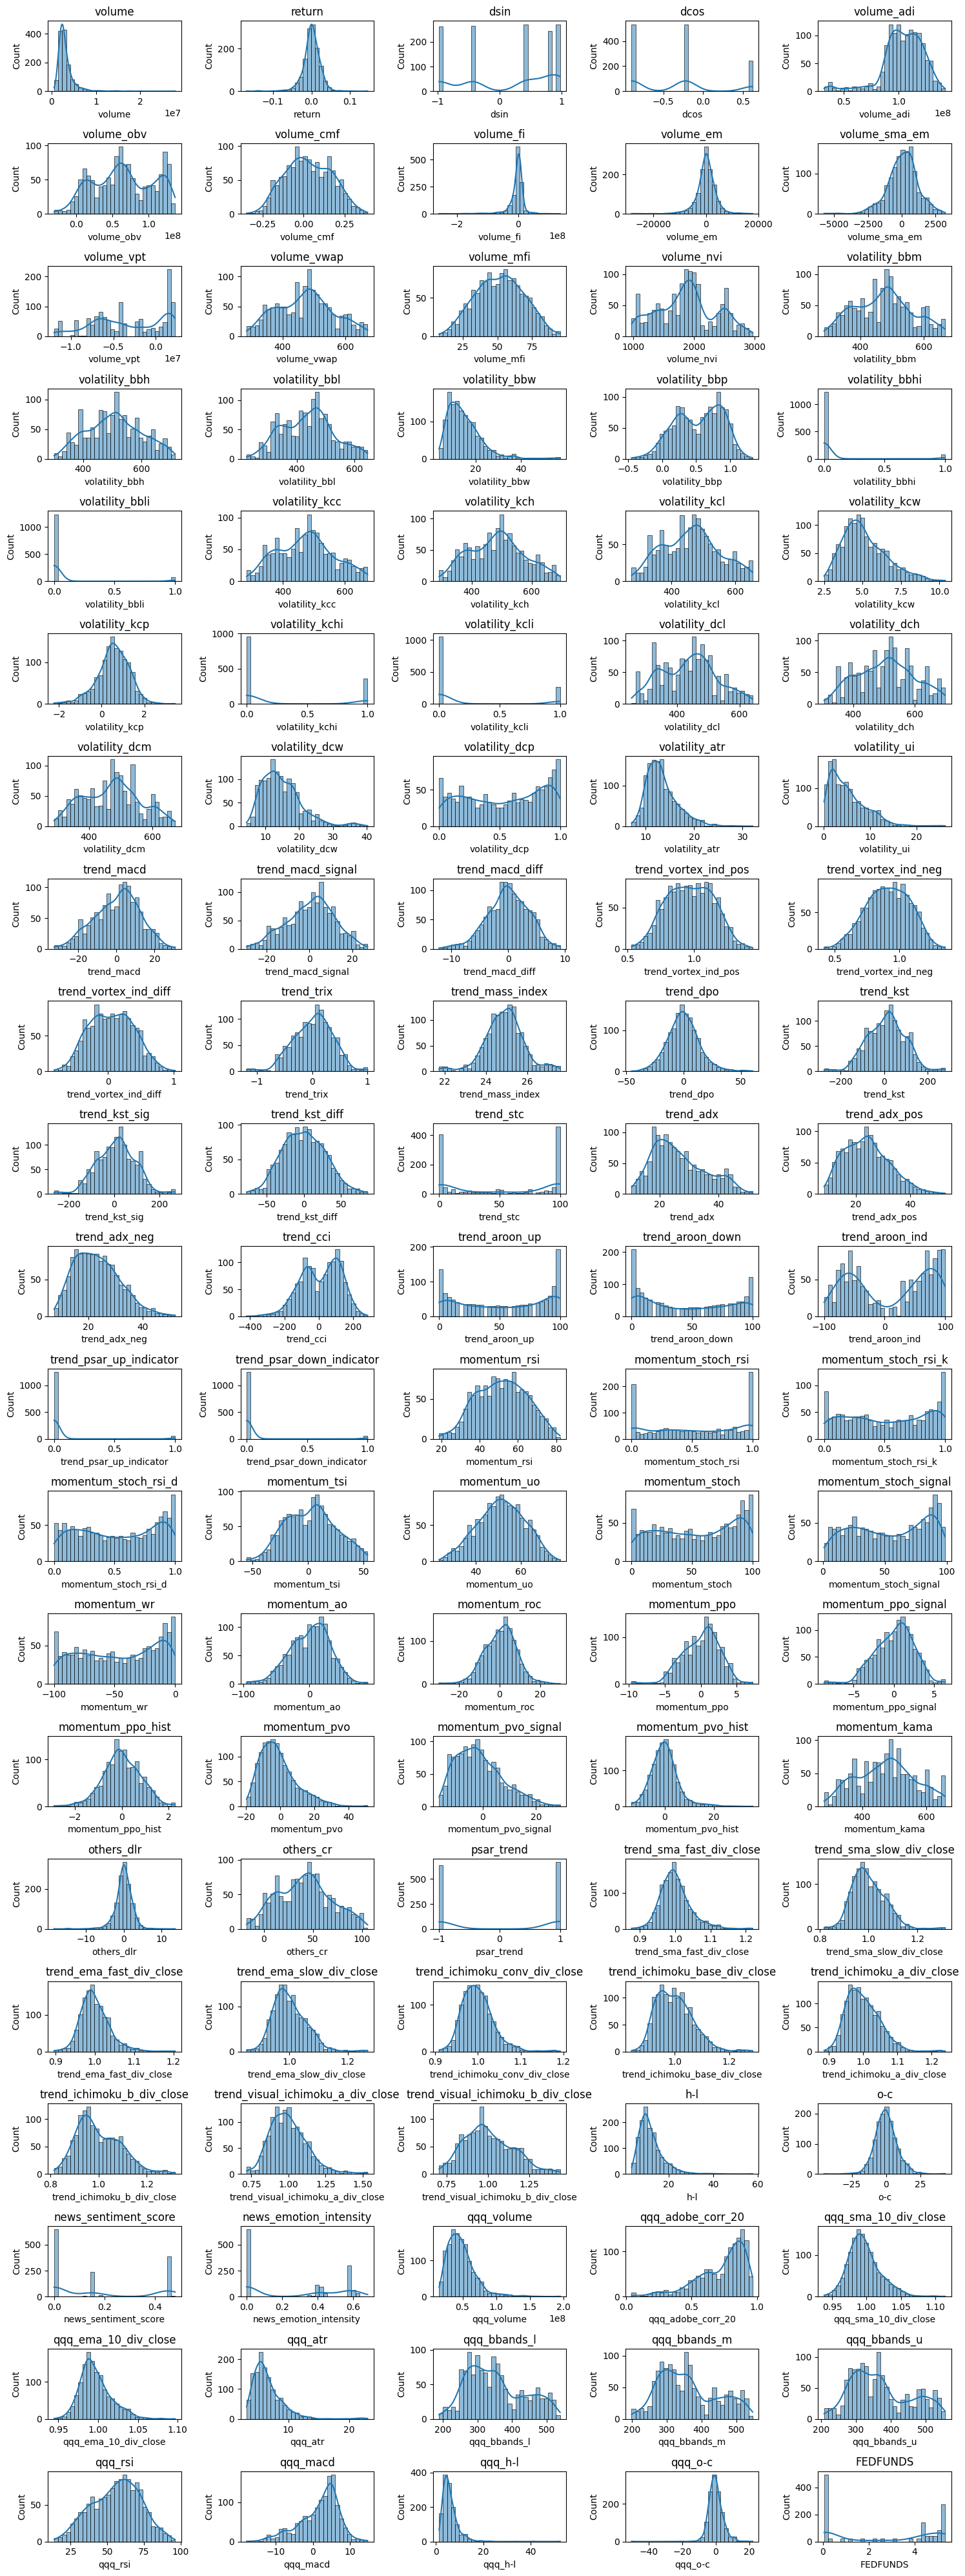

In [66]:
plot_feature_distributions(X, X.columns)

[**Back to Content**](#content)

<a id='3.1.3.2'></a>
#### 3.1.3.2 Group the features
With the visualization of the 105 features, I will group them to 3 categories. Each of the group is paired with an appropriate scaling method to ensure consistent preprocessing:
- **Bounded distribution**: Indicators constrained to a fixed range, showing skewed, bimodal, or other patterns. Scaled using **MinMaxScaler**.

- **Normal distribution**: Features with symmetric spread and bell-shaped histograms. Best suited for **StandardScaler**.

- **Skewed / long-Tailed / clustered distribution**: Features with heavy skew, long tails, or clustered spikes. These are sensitive to outliers and scaled using **RobustScaler**.

After learning the features and observing their distributions, I can reach some initial grouping decisions:
1. Based on the definition and with reference to the plots, I identified clear candidates for bounded distribution.   
**Bounded distribution:**  
`dsin`, `dcos`, `trend_stc`, `trend_adx`, `trend_adx_pos`, `trend_adx_neg`, `trend_aroon_up`, `trend_aroon_down`,
`trend_aroon_ind`, `trend_psar_up_indicator`, `trend_psar_down_indicator`, `momentum_rsi`, `momentum_stoch_rsi`,
`momentum_stoch_rsi_k`, `momentum_stoch_rsi_d`, `momentum_tsi`,  `momentum_uo`,  `momentum_stoch`,
`momentum_stoch_signal`, `momentum_wr`, `psar_trend`,
`news_sentiment_score`, `news_emotion_intensity`, `qqq_rsi`, `FEDFUNDS`

2. From the plots, features with obvious skew, long-tails, or clusters can be spotted as well.  
**Skewed / long-Tailed / clustered distribution:**  
`volume`, `volume_adi`, `volume_obv`, `volume_cmf`,  `volume_sma_em`, `volume_vpt`,
`volume_vwap`, `volume_mfi`, `volume_nvi`, `volatility_bbm`, `volatility_bbh`, `volatility_bbl`,
`volatility_bbw`, `volatility_bbp`, `volatility_bbhi`, `volatility_bbli`, `volatility_kcc`, `volatility_kch`,
`volatility_kcl`, `volatility_kcw`,  `volatility_kchi`, `volatility_kcli`, `volatility_dcl`,
`volatility_dch`, `volatility_dcm`, `volatility_dcw`, `volatility_dcp`, `volatility_atr`, `volatility_ui`,
`trend_vortex_ind_pos`, `trend_vortex_ind_neg`, `trend_vortex_ind_diff`,  `trend_mass_index`, `trend_cci`,
`trend_ichimoku_conv_div_close`, `trend_ichimoku_base_div_close`, `trend_ichimoku_a_div_close`,
`trend_ichimoku_b_div_close`, `trend_visual_ichimoku_a_div_close`, `trend_visual_ichimoku_b_div_close`,
`momentum_ppo`, `momentum_ppo_signal`, `momentum_pvo`, `momentum_pvo_signal`,
`momentum_kama`, `others_cr`, `h-l`, `qqq_volume`, `qqq_adobe_corr_20`, `qqq_atr`, `qqq_bbands_l`,
`qqq_bbands_m`, `qqq_bbands_u`, `qqq_macd`, `qqq_h-l`

3. Outlier analysis will be used to finalize the categorization for the rest. These features appear approximately normal, but it is unclear whether their potential outliers may cause them to behave like long-tailed distributions.  
**Features to be examed with outlier analysis:**    
`return`, `volume_fi`, `volume_em`, `volatility_kcp`, `trend_macd`, `trend_macd_signal`, `trend_macd_diff`, `trend_trix`, 
`trend_dpo`, `trend_kst`,
`trend_kst_sig`, `trend_kst_diff`, `trend_sma_fast_div_close`, `trend_sma_slow_div_close`,
`trend_ema_fast_div_close`, `trend_ema_slow_div_close`, `momentum_ao`, `momentum_roc`, `momentum_ppo_hist`,
`momentum_pvo_hist`, `others_dlr`, `o-c`, `qqq_sma_10_div_close`, `qqq_ema_10_div_close`, `qqq_o-c`

In [67]:
#Create the list of features in 3 categories
features_bounded = [
    'dsin', 'dcos', 'trend_stc', 'trend_adx', 'trend_adx_pos', 'trend_adx_neg', 'trend_aroon_up', 'trend_aroon_down',
    'trend_aroon_ind', 'trend_psar_up_indicator', 'trend_psar_down_indicator', 'momentum_rsi', 'momentum_stoch_rsi',
    'momentum_stoch_rsi_k', 'momentum_stoch_rsi_d', 'momentum_tsi', 'momentum_uo', 'momentum_stoch', 'momentum_stoch_signal',
    'momentum_wr', 'psar_trend', 'news_sentiment_score', 'news_emotion_intensity', 'qqq_rsi', 'FEDFUNDS'
]

features_normal = []

features_skewed_tailed_clustered = [
    'volume', 'volume_adi', 'volume_obv', 'volume_cmf',  'volume_sma_em', 'volume_vpt', 'volume_vwap', 'volume_mfi',
    'volume_nvi', 'volatility_bbm', 'volatility_bbh', 'volatility_bbl', 'volatility_bbw', 'volatility_bbp',
    'volatility_bbhi', 'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl', 'volatility_kcw',
    'volatility_kchi', 'volatility_kcli', 'volatility_dcl', 'volatility_dch', 'volatility_dcm', 'volatility_dcw',
    'volatility_dcp', 'volatility_atr', 'volatility_ui', 'trend_vortex_ind_pos', 'trend_vortex_ind_neg',
    'trend_vortex_ind_diff',  'trend_mass_index', 'trend_cci', 'trend_ichimoku_conv_div_close',
    'trend_ichimoku_base_div_close', 'trend_ichimoku_a_div_close', 'trend_ichimoku_b_div_close',
    'trend_visual_ichimoku_a_div_close', 'trend_visual_ichimoku_b_div_close', 'momentum_ppo', 'momentum_ppo_signal',
    'momentum_pvo', 'momentum_pvo_signal', 'momentum_kama', 'others_cr', 'h-l', 'qqq_volume', 'qqq_adobe_corr_20',
    'qqq_atr', 'qqq_bbands_l', 'qqq_bbands_m', 'qqq_bbands_u', 'qqq_macd', 'qqq_h-l'
]

#Create the list of features to have outlier analysis
feature_outlier_analysis = [
    'return', 'volume_fi', 'volume_em', 'volatility_kcp', 'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'trend_trix',
    'trend_dpo', 'trend_kst', 'trend_kst_sig', 'trend_kst_diff', 'trend_sma_fast_div_close', 'trend_sma_slow_div_close',
    'trend_ema_fast_div_close', 'trend_ema_slow_div_close', 'momentum_ao', 'momentum_roc', 'momentum_ppo_hist',
    'momentum_pvo_hist', 'others_dlr', 'o-c', 'qqq_sma_10_div_close', 'qqq_ema_10_div_close', 'qqq_o-c'
]

In [68]:
len(features_bounded) + len(features_skewed_tailed_clustered) + len(feature_outlier_analysis)

105

In [69]:
len(feature_outlier_analysis)

25

**Outlier analysis:**

For the 25 features that need outlier analysis, I will apply two complementary metrics: the skewness coefficient and the Interquartile Range (IQR).

- **Skewness coefficient**  
    It quantifies the asymmetry of the distribution:
    - $0$ : perfectly symmetric distribution
   
    - Positive : right-skewed
    
    - Negative : left-skewed

    Intepretation:
    - $|\text{Skewness}| < 0.5$ : fairly symmetric, typically fine for StandardScaler
    
    - $0.5 ≤ |\text{Skewness}| ≤ 1$ : moderately skewed
   
    - $|\text{Skewness}| > 1$ : heavily skewed, often requiring RobustScaler or transformations to reduce skew if needed

- **Interquartile Range (IQR)**    
    This method identifies statistical outliers by examining how far values deviate from the middle 50% of the data—offering a robust and non-parametric approach that doesn’t assume normality:
    - $IQR$ is the gap between the values of the 75th percentile (Q3) and the 25th percentile (Q1).
   
    - Values falling outside the range $[Q1 − 1.5 × IQR, Q3 + 1.5 × IQR]$ are considered outliers.
    
    - If outliers account for less than 5% of the data, we consider the feature suitable for normal distribution treatment.

- **Deicision logic**  
    A feature will be categorized as normally distributed if both conditions are met:
    - $|\text{Skewness}| < 0.5$
   
    - $\text{Outlier ratio} < 5\%$

    Otherwise, it will be classified as skewed / long-tailed and scaled accordingly.

We will use this decision to update the above feature lists. Meanwhile, to support this process, for the features in the outlier analysis, we generate:
- Histogram + KDE plots for shape and modality  

- Box plots to visualize outliers and IQR  

- Q-Q plots to assess normality alignment  

- A summary dataframe with skewness, outlier ratio, and categorization

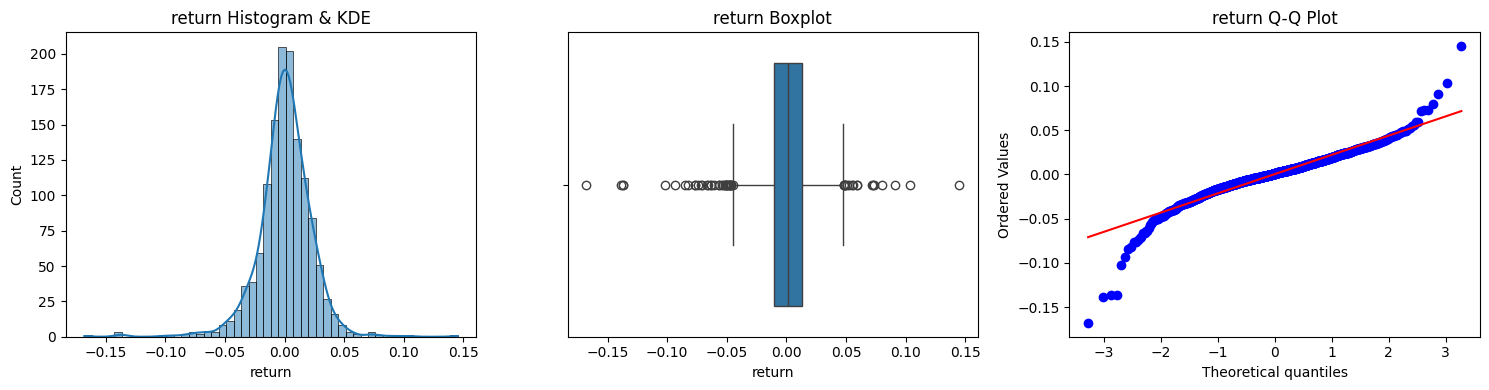

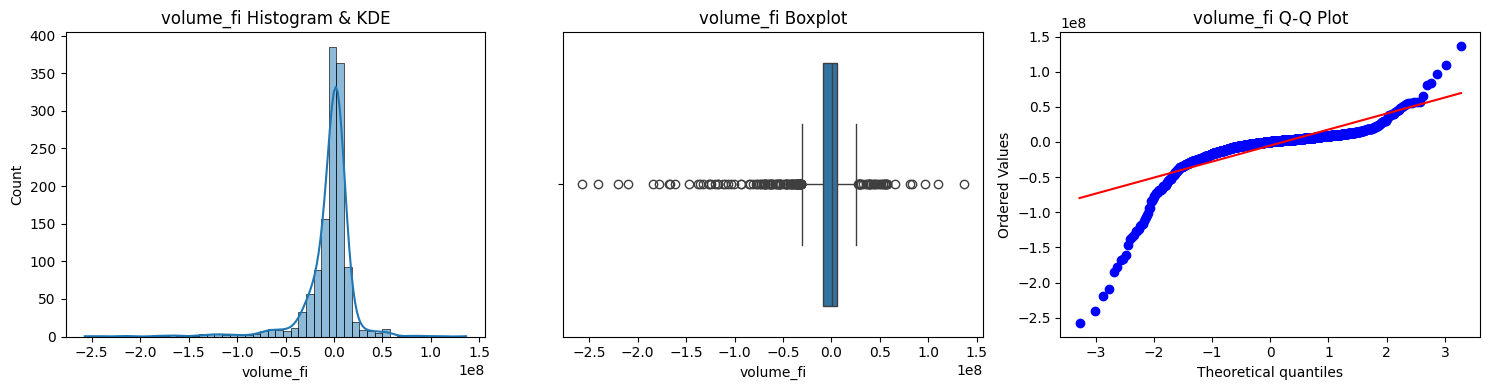

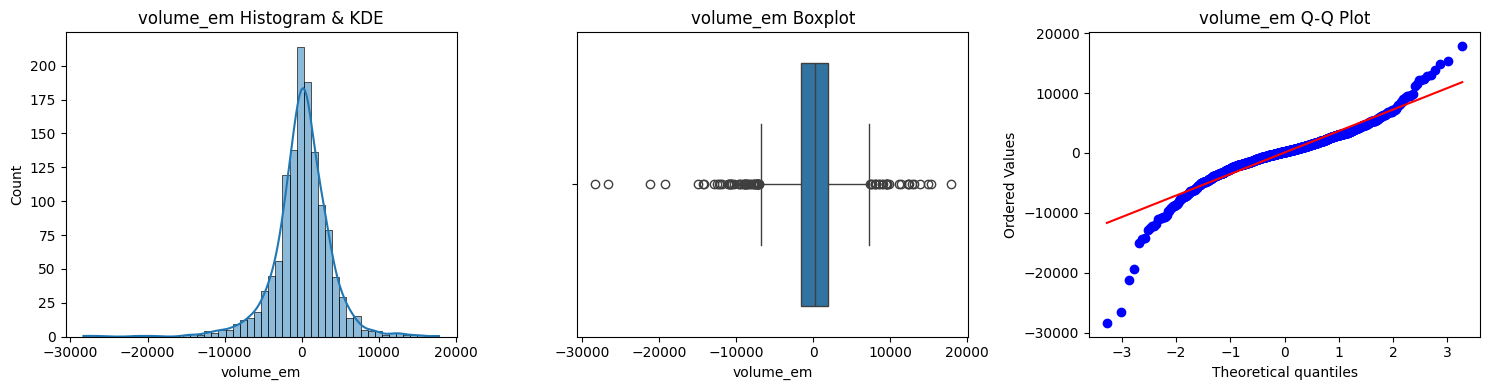

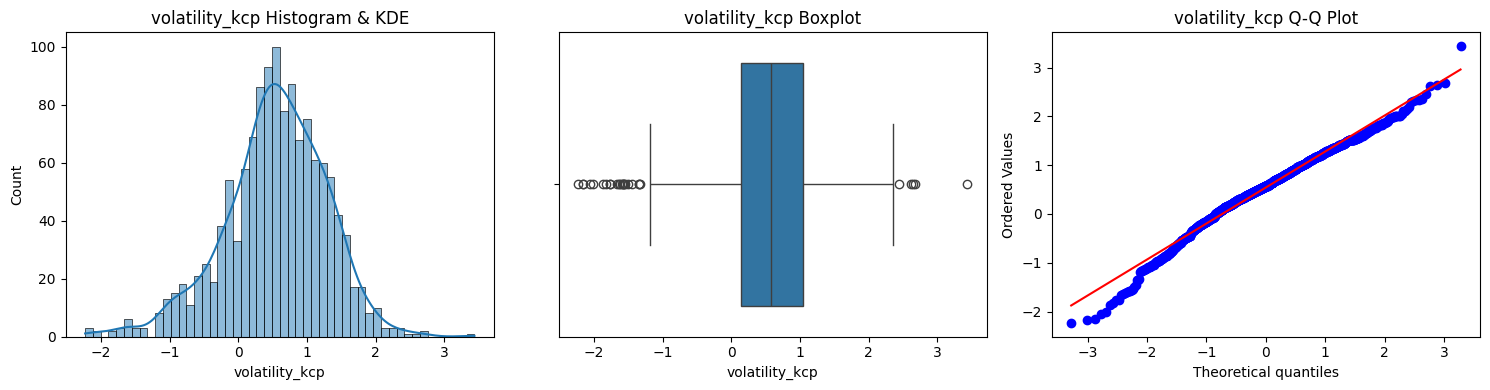

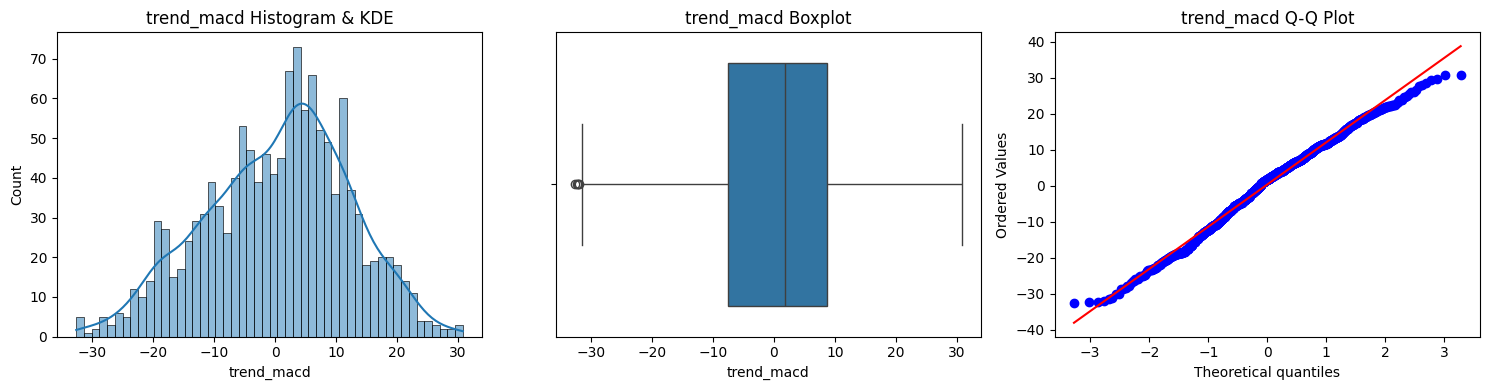

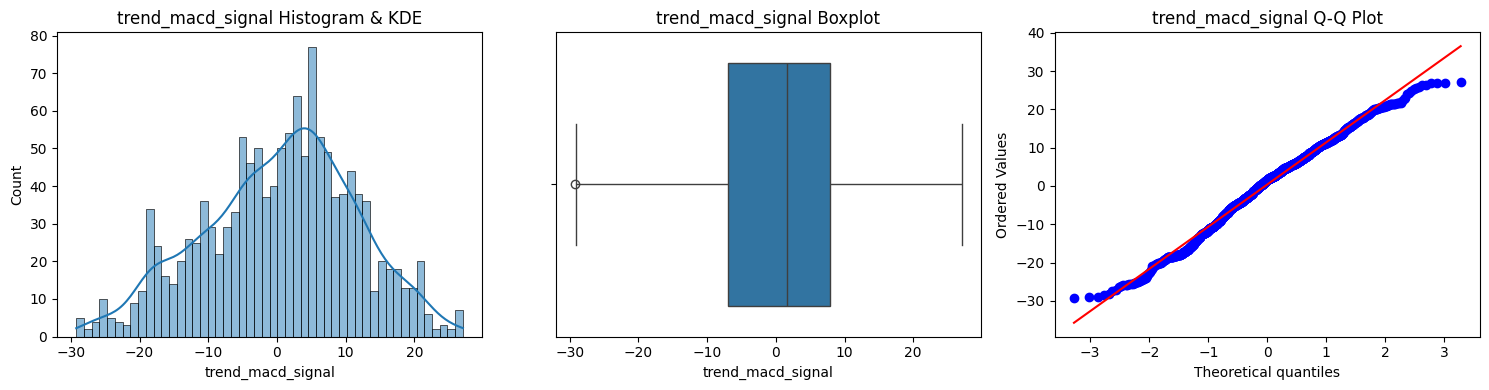

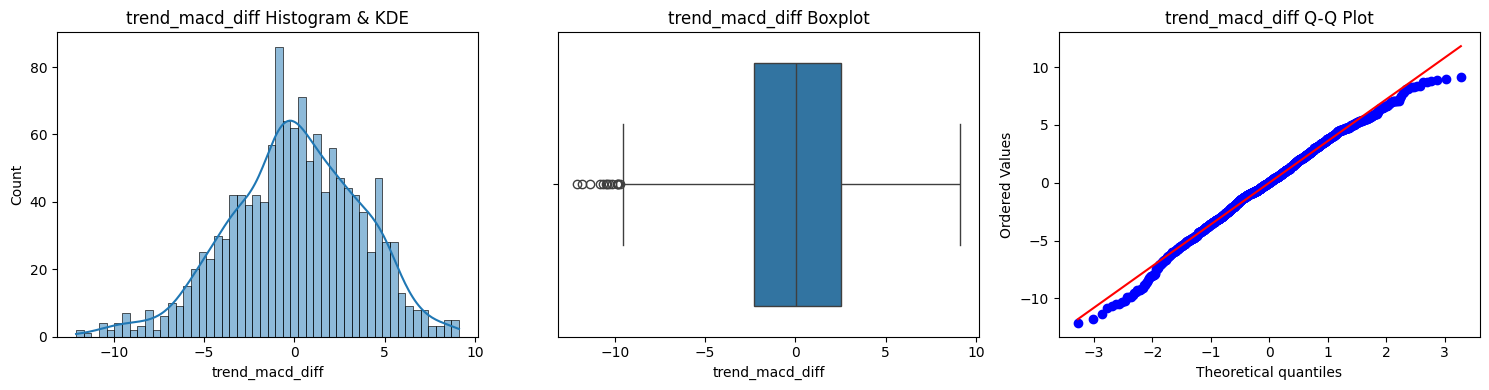

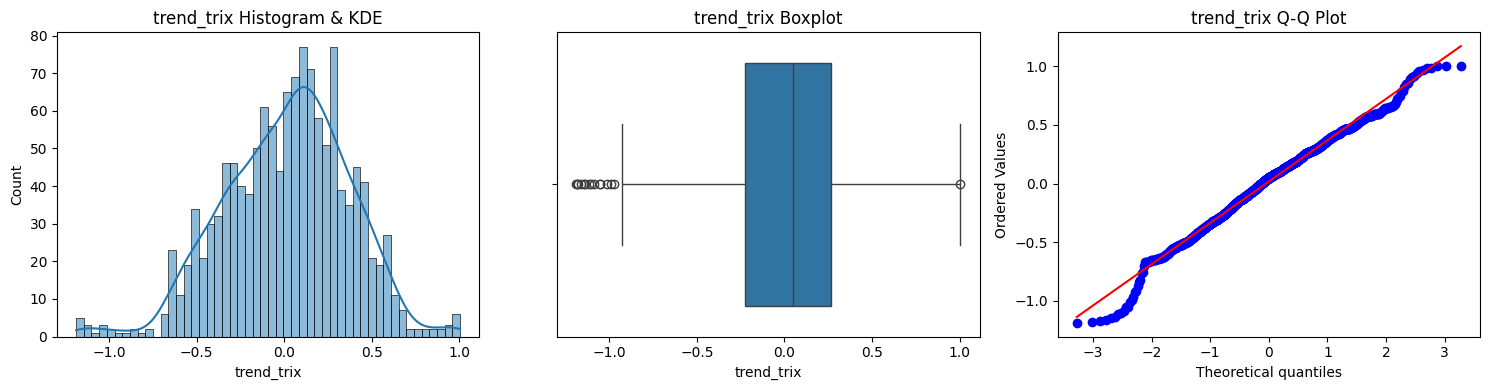

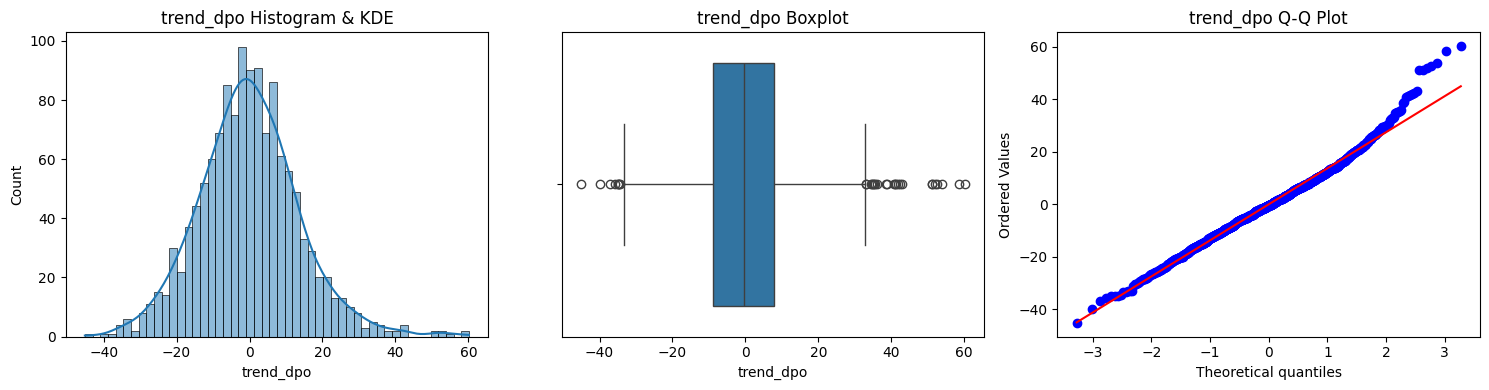

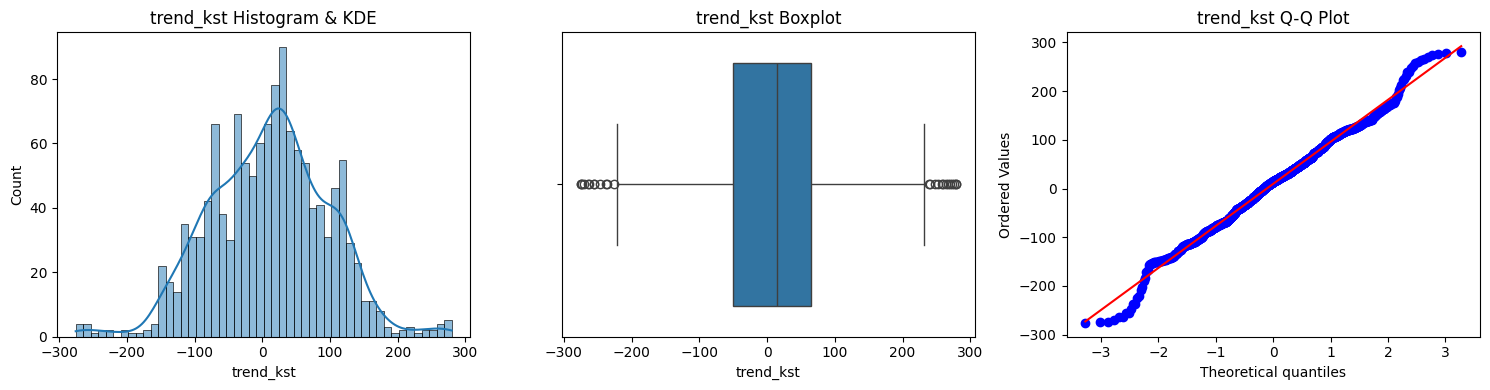

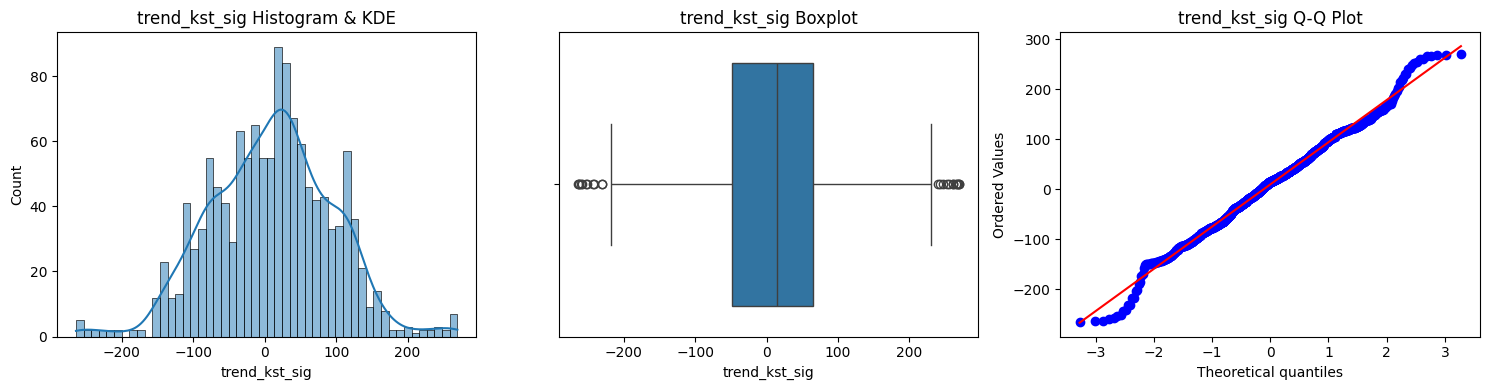

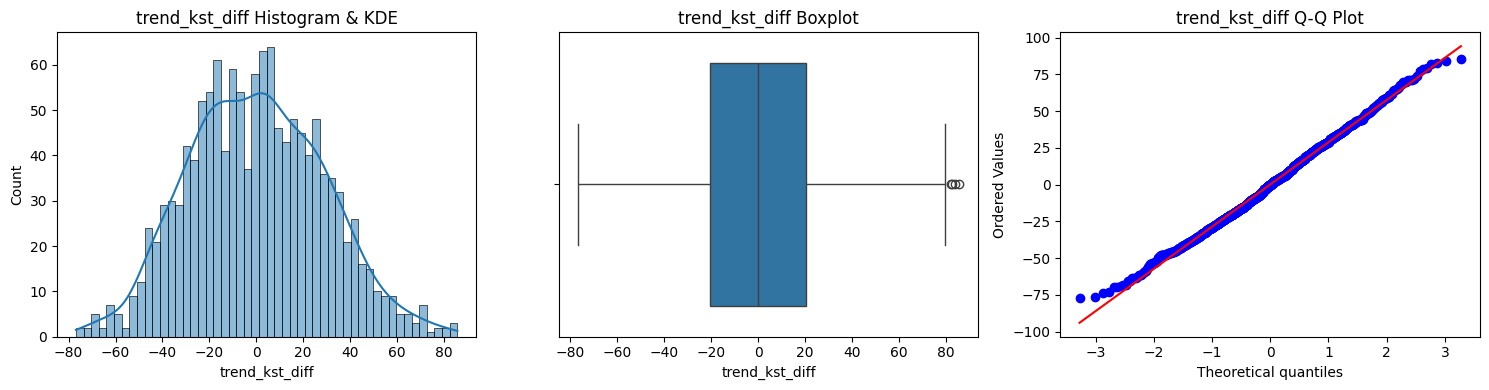

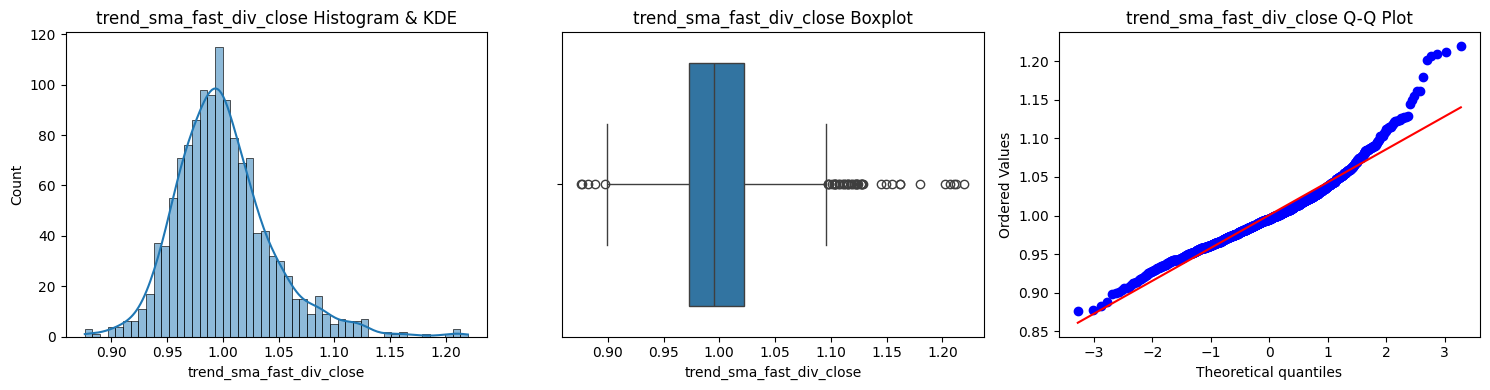

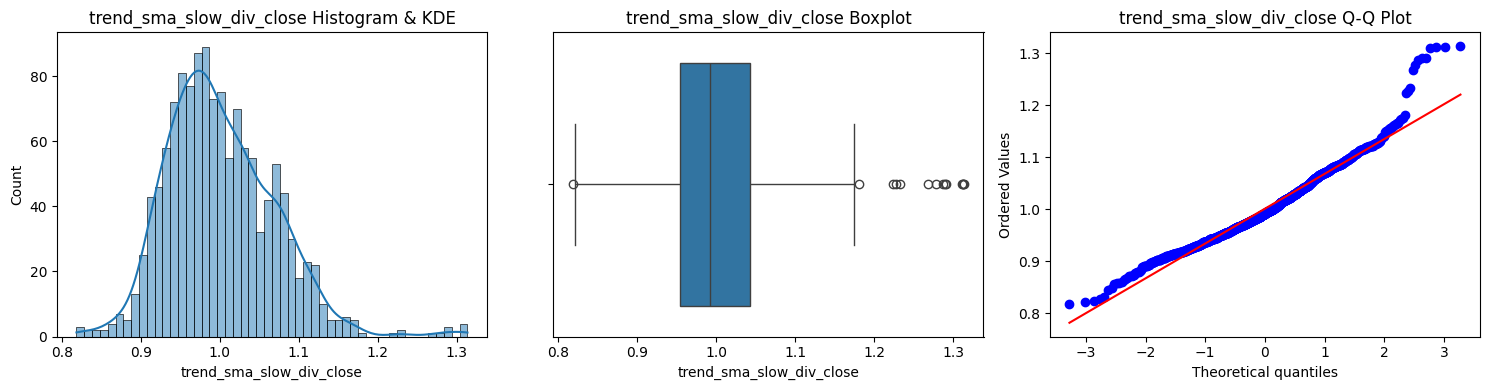

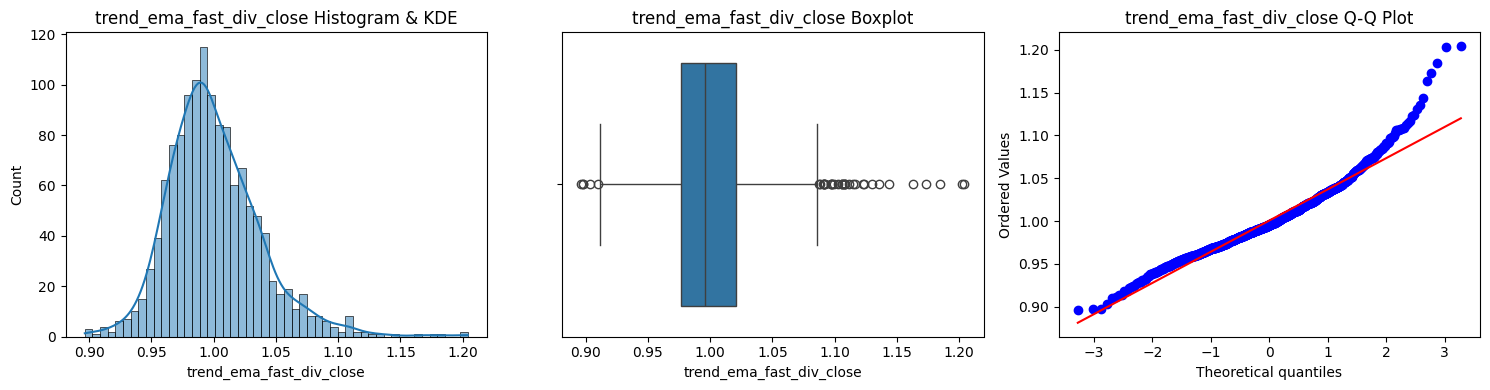

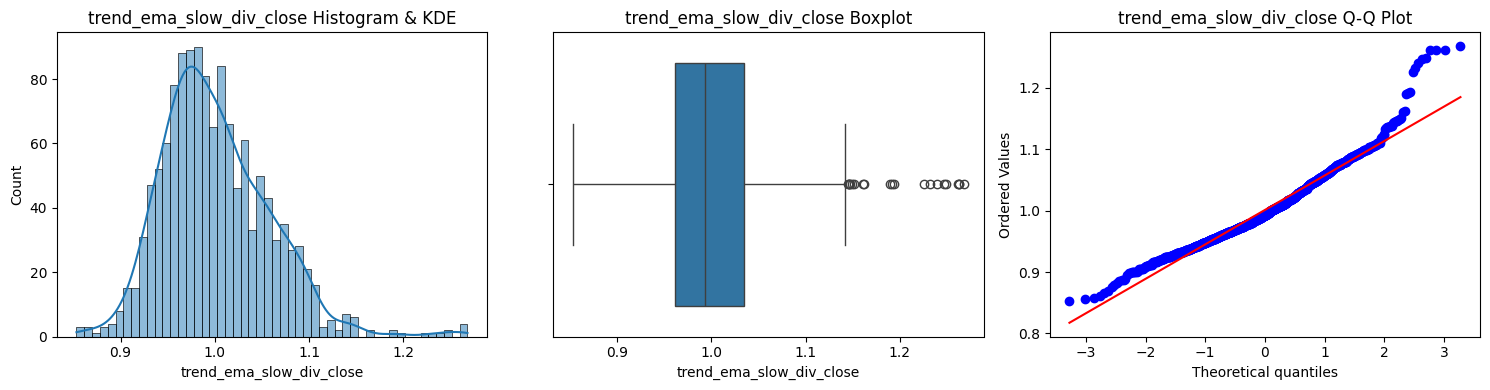

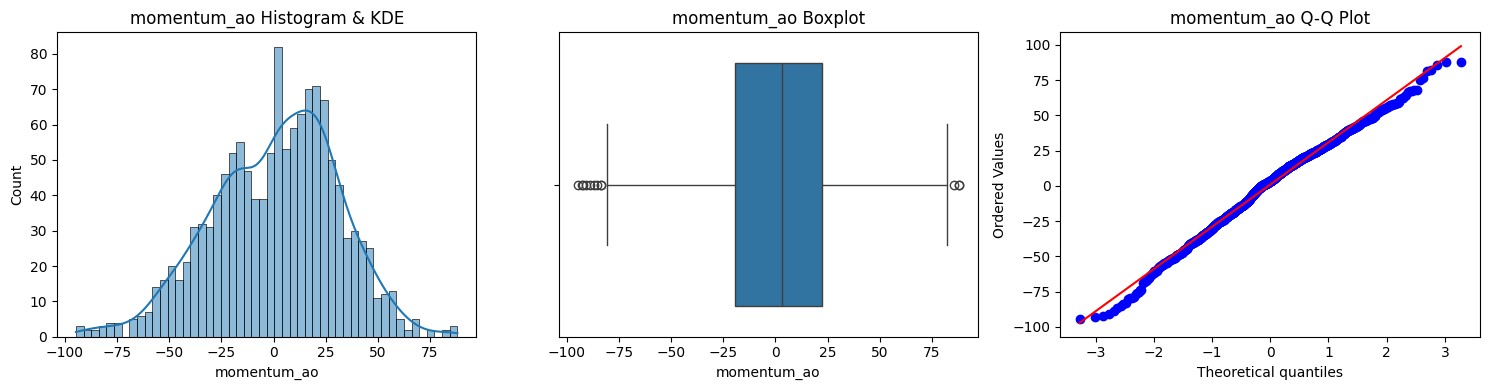

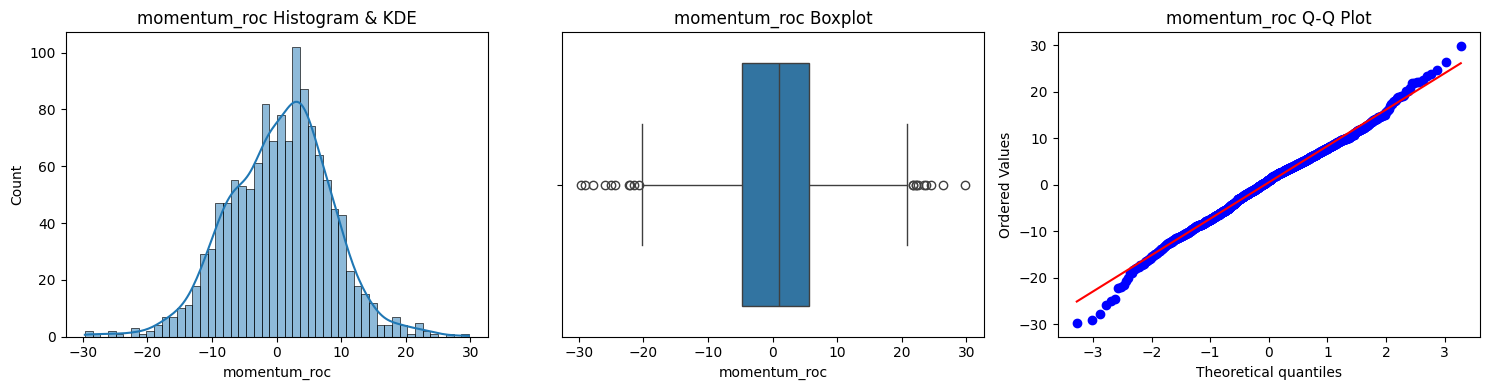

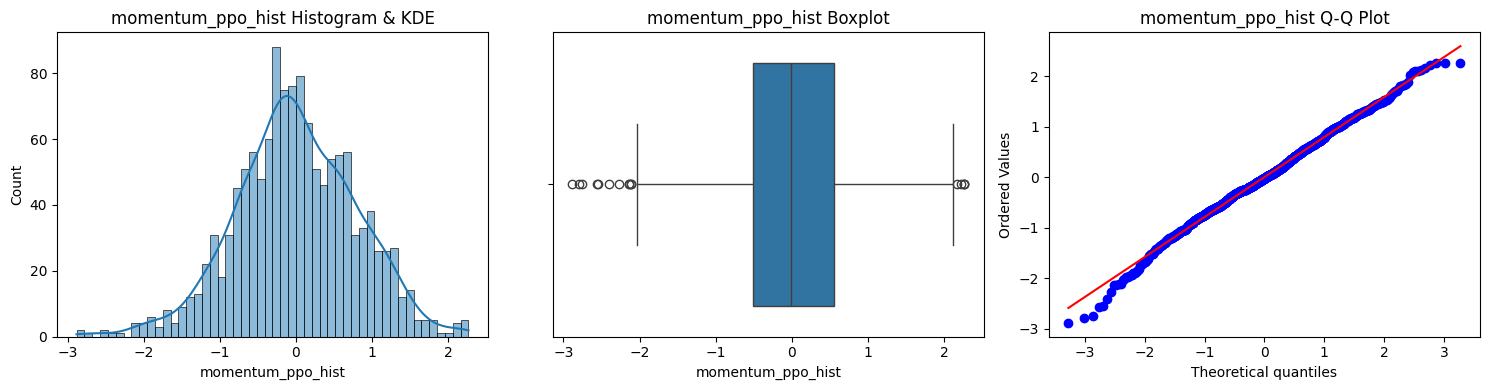

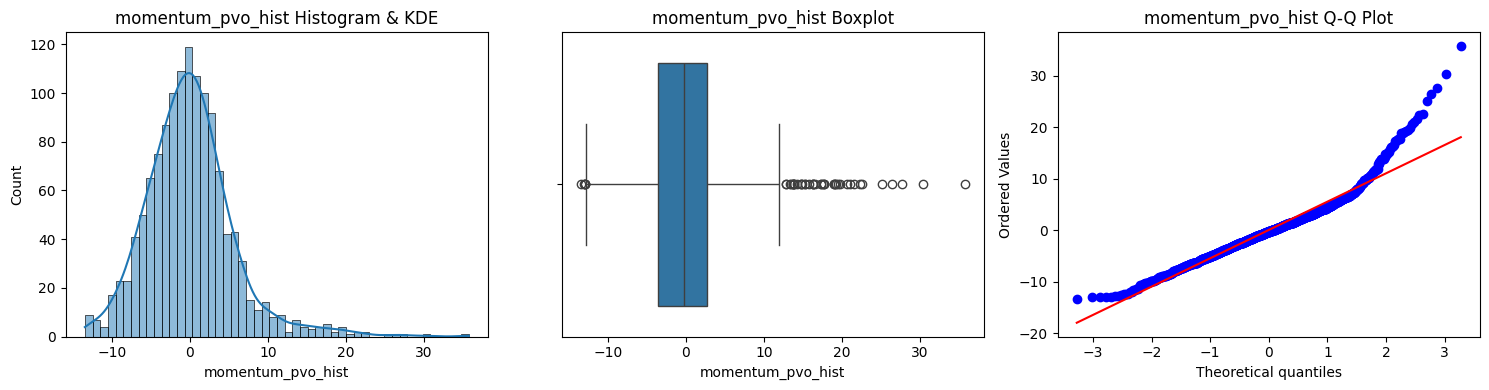

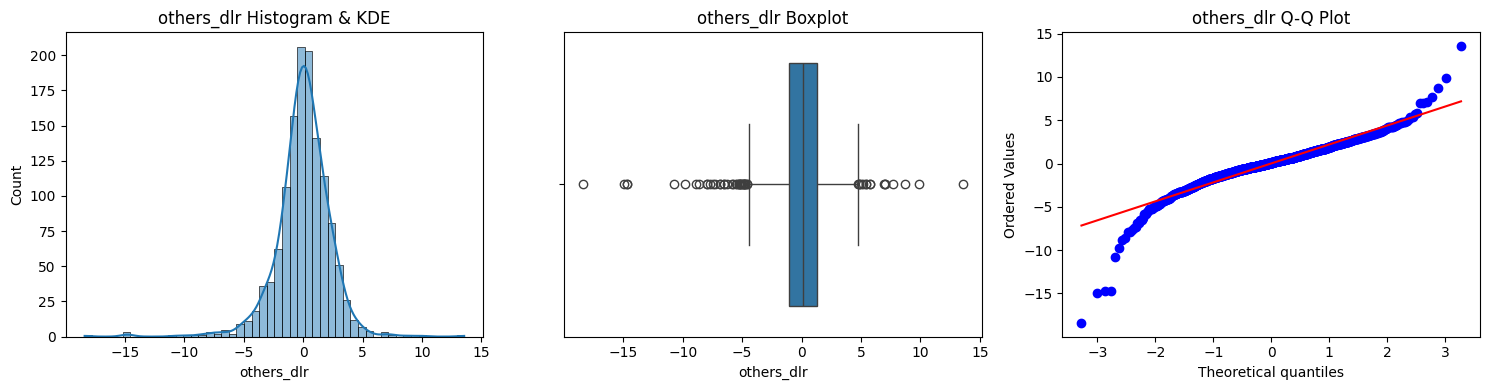

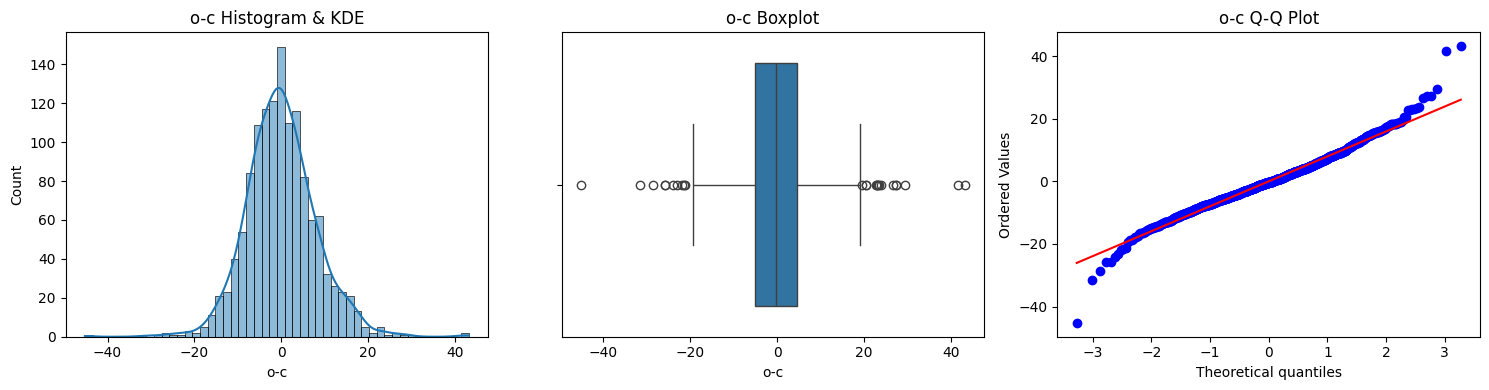

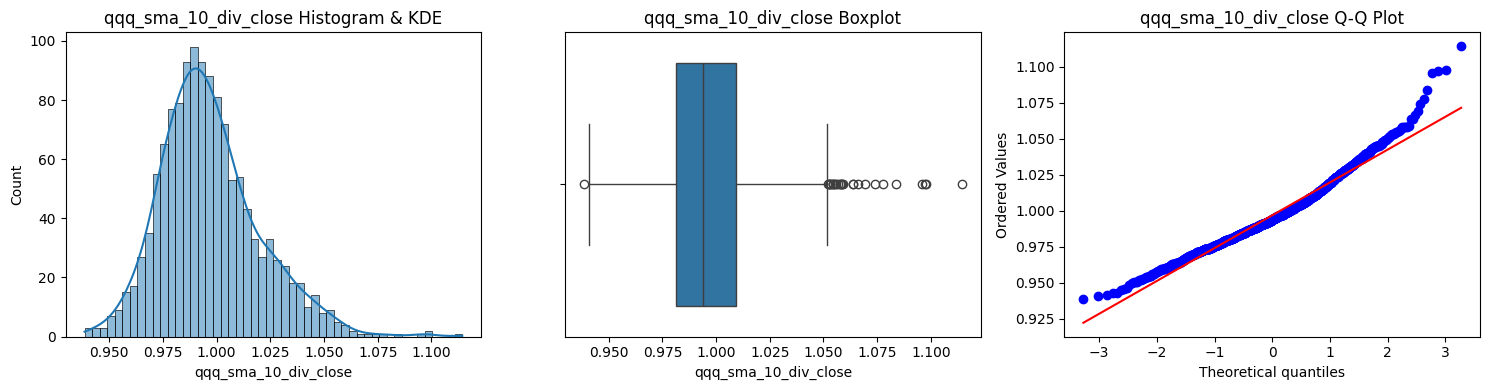

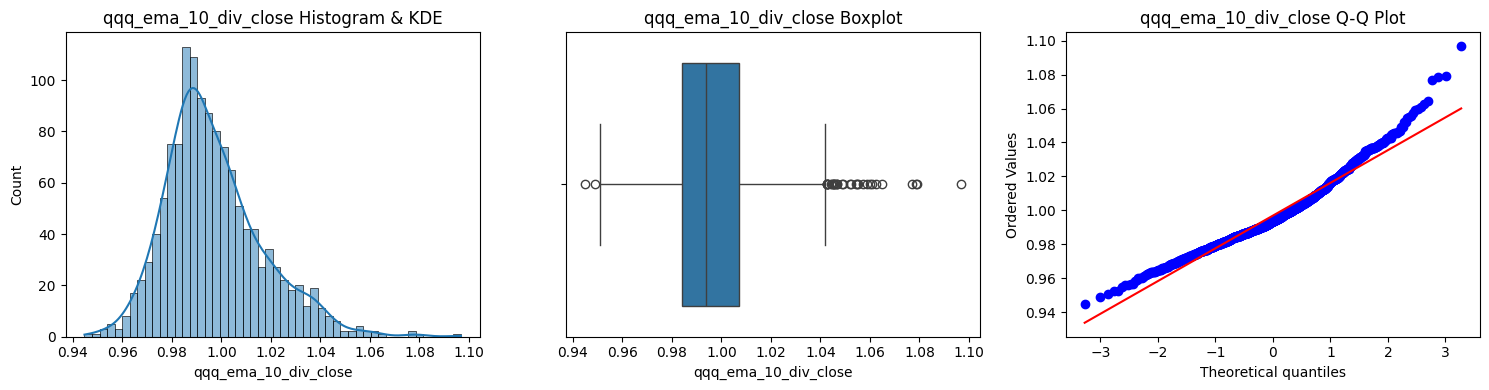

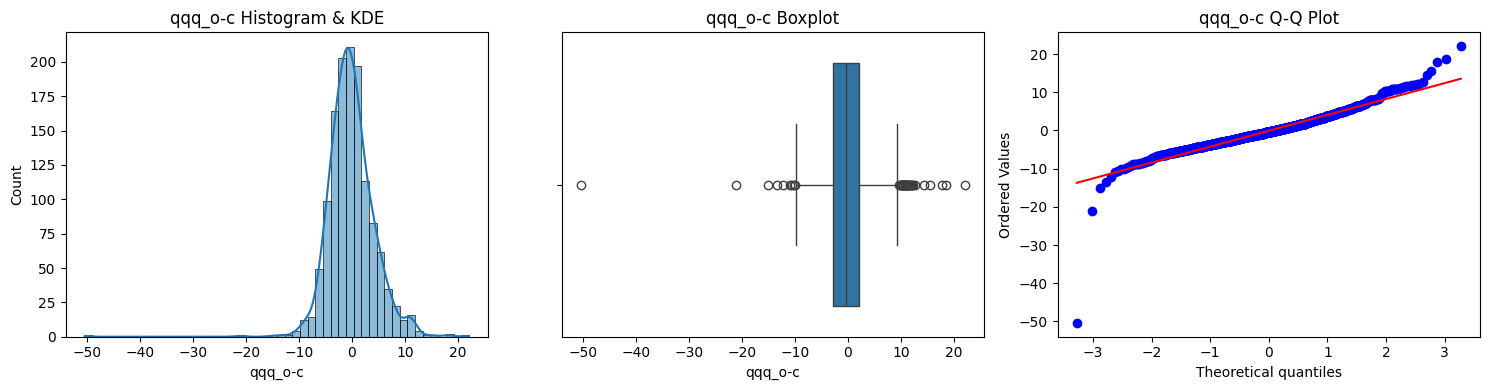

In [70]:
results = []
for col in feature_outlier_analysis:
    data = X[col]
    skew = data.skew()#calculate the skewness coefficient of the feature
    
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = ((data < lower_bound) | (data > upper_bound)).sum()
    outlier_pct = outliers / len(data) * 100

    # Decision logic
    if abs(skew) < 0.5 and outlier_pct < 5:
        distribution = "Normal"
        features_normal.append(col)
    else:
        distribution = "Skewed/Long-tailed"
        features_skewed_tailed_clustered.append(col)
    
    results.append({
        "Feature": col,
        "Skewness": round(skew, 3),
        "Outlier %": round(outlier_pct, 2),
        "Distribution": distribution
    })

    # ======= VISUALIZATION =======
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))

    # Histogram + KDE
    sns.histplot(data, bins=50, kde=True, ax=axs[0])
    axs[0].set_title(f"{col} Histogram & KDE")
    
    # Boxplot
    sns.boxplot(x=data, ax=axs[1])
    axs[1].set_title(f"{col} Boxplot")
    
    # Q-Q plot
    stats.probplot(data, dist="norm", plot=axs[2])
    axs[2].set_title(f"{col} Q-Q Plot")

    plt.tight_layout()
    plt.show()

In [71]:
# Show summary table
results_df = pd.DataFrame(results)
results_df

Feature  Skewness  Outlier %        Distribution
0                     return    -0.821      4.120  Skewed/Long-tailed
1                  volume_fi    -3.316     10.760  Skewed/Long-tailed
2                  volume_em    -0.897      5.730  Skewed/Long-tailed
3             volatility_kcp    -0.441      2.060              Normal
4                 trend_macd    -0.233      0.310              Normal
5          trend_macd_signal    -0.222      0.080              Normal
6            trend_macd_diff    -0.270      0.990              Normal
7                 trend_trix    -0.281      1.150              Normal
8                  trend_dpo     0.393      2.370              Normal
9                  trend_kst    -0.057      1.910              Normal
10             trend_kst_sig    -0.050      1.760              Normal
11            trend_kst_diff     0.140      0.310              Normal
12  trend_sma_fast_div_close     0.976      3.590  Skewed/Long-tailed
13  trend_sma_slow_div_close     0.779      1.070  Skewed/Long-tailed
14  trend_ema_fast_div_close     0.958      2.900  Skewed/Long-tailed
15  trend_ema_slow_div_close     0.852      1.530  Skewed/Long-tailed
16               momentum_ao    -0.280      0.920              Normal
17              momentum_roc    -0.141      1.530              Normal
18         momentum_ppo_hist    -0.115      1.220              Normal
19         momentum_pvo_hist     1.106      3.510  Skewed/Long-tailed
20                others_dlr    -1.141      4.050  Skewed/Long-tailed
21                       o-c     0.240      1.910              Normal
22      qqq_sma_10_div_close     0.764      2.140  Skewed/Long-tailed
23      qqq_ema_10_div_close     0.827      2.520  Skewed/Long-tailed
24                   qqq_o-c    -0.720      3.360  Skewed/Long-tailed

The feature lists are updated with newly decided feautres based on the above logic. Check the lists.

In [72]:
print(features_normal)

['volatility_kcp', 'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'trend_trix', 'trend_dpo', 'trend_kst', 'trend_kst_sig', 'trend_kst_diff', 'momentum_ao', 'momentum_roc', 'momentum_ppo_hist', 'o-c']


In [73]:
print(features_skewed_tailed_clustered)

['volume', 'volume_adi', 'volume_obv', 'volume_cmf', 'volume_sma_em', 'volume_vpt', 'volume_vwap', 'volume_mfi', 'volume_nvi', 'volatility_bbm', 'volatility_bbh', 'volatility_bbl', 'volatility_bbw', 'volatility_bbp', 'volatility_bbhi', 'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl', 'volatility_kcw', 'volatility_kchi', 'volatility_kcli', 'volatility_dcl', 'volatility_dch', 'volatility_dcm', 'volatility_dcw', 'volatility_dcp', 'volatility_atr', 'volatility_ui', 'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_mass_index', 'trend_cci', 'trend_ichimoku_conv_div_close', 'trend_ichimoku_base_div_close', 'trend_ichimoku_a_div_close', 'trend_ichimoku_b_div_close', 'trend_visual_ichimoku_a_div_close', 'trend_visual_ichimoku_b_div_close', 'momentum_ppo', 'momentum_ppo_signal', 'momentum_pvo', 'momentum_pvo_signal', 'momentum_kama', 'others_cr', 'h-l', 'qqq_volume', 'qqq_adobe_corr_20', 'qqq_atr', 'qqq_bbands_l', 'qqq_bbands_m', 'qqq_bbands

In [74]:
print(features_bounded)

['dsin', 'dcos', 'trend_stc', 'trend_adx', 'trend_adx_pos', 'trend_adx_neg', 'trend_aroon_up', 'trend_aroon_down', 'trend_aroon_ind', 'trend_psar_up_indicator', 'trend_psar_down_indicator', 'momentum_rsi', 'momentum_stoch_rsi', 'momentum_stoch_rsi_k', 'momentum_stoch_rsi_d', 'momentum_tsi', 'momentum_uo', 'momentum_stoch', 'momentum_stoch_signal', 'momentum_wr', 'psar_trend', 'news_sentiment_score', 'news_emotion_intensity', 'qqq_rsi', 'FEDFUNDS']


In [75]:
len(features_normal) + len(features_bounded) + len(features_skewed_tailed_clustered)

105

All the features are grouped successfully.

[**Back to Content**](#content)

<a id='3.1.3.3'></a>
#### 3.1.3.3 Scale the features
We’ve completed the structural evaluation of all features by analyzing their distributions and categorizing them into three groups based on scaling suitability.  

To close this section, we will scale the features according to the defined categories to ensure consistency in future observation, analysis and model training.

In [76]:
# Initialize scalers
scaler_standard = StandardScaler()
scaler_minmax = MinMaxScaler()
scaler_robust = RobustScaler()

A new datafram `X_scaled` is created to represent the all the scaled features.

In [77]:
# Fit-transform per group
X_scaled = X.copy()

X_scaled[features_normal] = scaler_standard.fit_transform(X[features_normal])
X_scaled[features_bounded] = scaler_minmax.fit_transform(X[features_bounded])
X_scaled[features_skewed_tailed_clustered] = scaler_robust.fit_transform(X[features_skewed_tailed_clustered])

In [78]:
X_scaled.head()

volume  return  dsin  dcos  volume_adi  volume_obv  volume_cmf  \
date                                                                         
2020-04-15   0.121  -1.091 0.723 0.000      -3.066      -0.917       0.552   
2020-04-16   0.902   1.282 0.277 0.000      -2.996      -0.858       0.330   
2020-04-17   0.493   0.135 0.000 0.445      -3.035      -0.808       0.171   
2020-04-20   0.088   0.054 0.901 1.000      -3.004      -0.767       0.590   
2020-04-21   0.639  -2.045 1.000 0.445      -3.092      -0.820       0.303   

            volume_fi  volume_em  volume_sma_em  ...  qqq_ema_10_div_close  \
date                                             ...                         
2020-04-15      0.649     -0.136          0.561  ...                -1.681   
2020-04-16      0.943      0.378          0.483  ...                -1.929   
2020-04-17      0.851      0.335          0.675  ...                -1.846   
2020-04-20      0.746     -0.234          0.489  ...                -1.057   
2020-04-21      0.081     -1.399          0.181  ...                 0.497   

            qqq_atr  qqq_bbands_l  qqq_bbands_m  qqq_bbands_u  qqq_rsi  \
date                                                                     
2020-04-15    0.469        -1.165        -1.134        -1.131    0.674   
2020-04-16    0.323        -1.150        -1.116        -1.108    0.641   
2020-04-17    0.248        -1.118        -1.095        -1.098    0.744   
2020-04-20    0.145        -1.066        -1.081        -1.122    0.666   
2020-04-21    0.227        -1.105        -1.091        -1.104    0.582   

            qqq_macd  qqq_h-l  qqq_o-c  FEDFUNDS  
date                                              
2020-04-15    -0.158   -0.176   -0.105     0.000  
2020-04-16    -0.009   -0.186   -0.209     0.000  
2020-04-17     0.126   -0.257    0.219     0.000  
2020-04-20     0.196   -0.579    0.191     0.000  
2020-04-21     0.152    0.632    1.232     0.000  

[5 rows x 105 columns]

In [79]:
X_scaled.shape

(1310, 105)

[**Back to Content**](#content)

<a id='3.2'></a>
## 3.2 SHAP analysis and feature relationship exploration
The goal of this section is to uncover relationships among features, providing insights into potential multicollinearity and dependencies. Given the large number of features (105), it is impractical to study the bilateral relationships for every possible pair.

To address this efficiently, I will first apply SHAP analysis to identify the 10 most impactful features for the prediction task. These top features will then be explored with pairwise scatter plots. The least relevant features will also be detected and then removed in this process.

<a id='3.2.1'></a>
### 3.2.1 SHAP analysis

SHAP analysis is a powerful method for interpreting machine learning models by quantifying the impact of each feature on a prediction. In this study, we apply SHAP to an XGBoost classifier, evaluating the influence of features in `X_scaled` on the target variable `y`.

XGBoost demonstrated strong performance during the evaluation of my Exam 3 project, which justifies its selection as the model for SHAP-based interpretability in this analysis.

First, initialize a default **XGBoost classifier** and fit it to the scaled dataset.  

In [80]:
model = xgb.XGBClassifier()
model.fit(X_scaled, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

Then, we perform SHAP analysis and visualize the 20 most influential features.

/var/folders/sj/km6fyx_57pn857bnxsqvkj_80000gn/T/ipykernel_50424/2518366921.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_scaled, max_display=20)  # visualize top 20


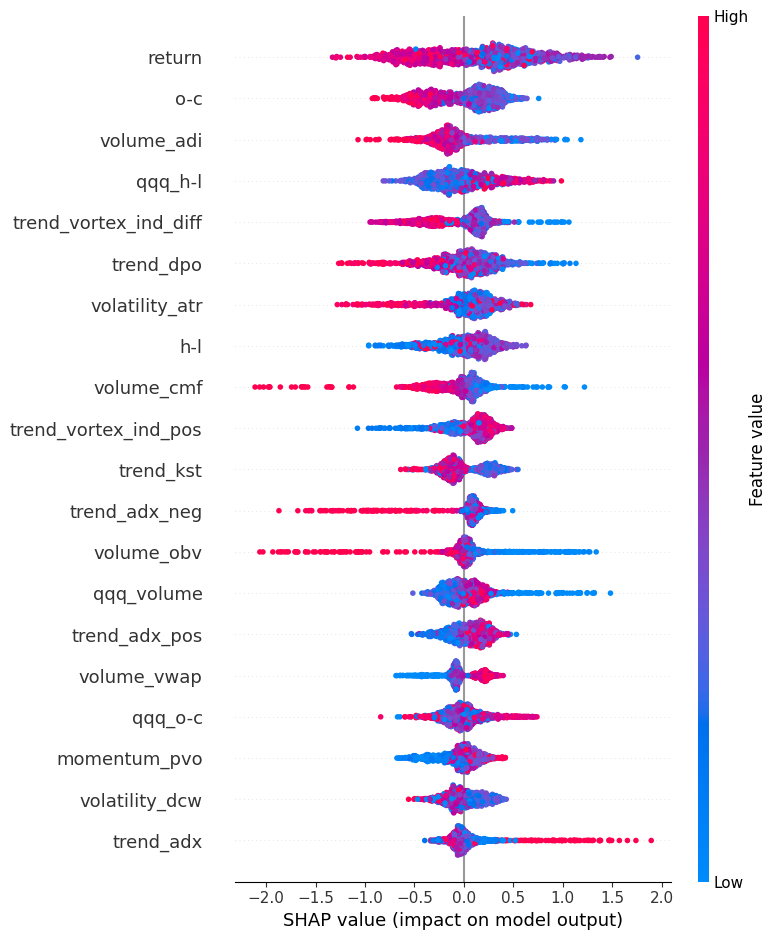

In [81]:
# Initialize SHAP explainer.
explainer = shap.Explainer(model, X_scaled)
shap_values = explainer(X_scaled)

# Summarize feature importance.
shap.summary_plot(shap_values, X_scaled, max_display=20)  # visualize top 20

The SHAP summary plot above ranks the top 20 features by their impact on the XGBoost classifier’s predictions, sorted from highest to lowest importance.

Each dot corresponds to a single day's observation. Its horizontal position reflects the feature’s influence on the model output—pushing the prediction toward 1 (right) or toward 0 (left). For example:
- A red dot for `return` positioned on the left suggests that a higher daily return reduces the likelihood of predicting class 0.

- A blue dot for `o-c` located on the right indicates that a lower open-close price difference increases the probability of class 1.

Next, we calculate the mean absolute SHAP values as the indicator for the importance of the features.

In [82]:
# Get mean absolute SHAP values per feature
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
feature_shap = pd.DataFrame({
    'feature': X_scaled.columns,
    'mean_abs_shap': mean_abs_shap
}).sort_values(by='mean_abs_shap', ascending=False)

feature_shap

feature  mean_abs_shap
1                       return          0.458
89                         o-c          0.280
4                   volume_adi          0.248
102                    qqq_h-l          0.244
40       trend_vortex_ind_diff          0.240
..                         ...            ...
56   trend_psar_down_indicator          0.000
20             volatility_bbli          0.000
77                  psar_trend          0.000
55     trend_psar_up_indicator          0.000
65                 momentum_wr          0.000

[105 rows x 2 columns]

Usually, a mean abusolute SHAP value above $0.1$ typically indicates a feature with strong predictive impact. Notably, all of our selected top 10 features exceed this threshold, reaffirming their significance.

On the contrary, features with mean abusolute SHAP values below $0.01$ tend to contribute negligibly to the model and may represent statistical noise or redundancy.

In [83]:
print(f"""
Among the {len(feature_shap)} features, {len(feature_shap[feature_shap['mean_abs_shap']>0.1])} exhibit mean absolute SHAP values above 0.1, indicating strong influence on the model's target predictions.

In contrast, {len(feature_shap[feature_shap['mean_abs_shap']<0.01])} features fall below the 0.01 threshold, suggesting minimal impact and potential irrelevance for predictive modeling.
""")   


Among the 105 features, 41 exhibit mean absolute SHAP values above 0.1, indicating strong influence on the model's target predictions.

In contrast, 11 features fall below the 0.01 threshold, suggesting minimal impact and potential irrelevance for predictive modeling.



The result indicates good feature construction: **approximately 40% of features exhibit strong influence, contributing meaningfully to model decisions, while only 10% show minimal impact, suggesting limited predictive value.**

Next, we will:
- Extract the top 10 most impactful features for deeper relationship analysis.
- Remove the 11 features with mean absolute SHAP values below 0.01, as they contribute minimally to model performance.

Extract the top 10 features.

In [84]:
# Store the top 10 features' names
top_10_features = feature_shap['feature'].head(10).tolist()

print("Top 10 impactful features for scatter relationship analysis:")
print(top_10_features)

Top 10 impactful features for scatter relationship analysis:
['return', 'o-c', 'volume_adi', 'qqq_h-l', 'trend_vortex_ind_diff', 'trend_dpo', 'volatility_atr', 'h-l', 'volume_cmf', 'trend_vortex_ind_pos']


View the the mean absolute SHAP value of the top 10 features, we will do a deeper exploration in the next section.

In [85]:
feature_shap[feature_shap['feature'].isin(top_10_features)]

feature  mean_abs_shap
1                   return          0.458
89                     o-c          0.280
4               volume_adi          0.248
102                qqq_h-l          0.244
40   trend_vortex_ind_diff          0.240
43               trend_dpo          0.233
33          volatility_atr          0.220
88                     h-l          0.209
6               volume_cmf          0.194
38    trend_vortex_ind_pos          0.185

Check the features with low mean absolute SHAP values.

In [86]:
feature_shap[feature_shap['mean_abs_shap']<0.01]

feature  mean_abs_shap
28             volatility_dcl          0.008
19            volatility_bbhi          0.000
75                 others_dlr          0.000
30             volatility_dcm          0.000
26            volatility_kchi          0.000
27            volatility_kcli          0.000
56  trend_psar_down_indicator          0.000
20            volatility_bbli          0.000
77                 psar_trend          0.000
55    trend_psar_up_indicator          0.000
65                momentum_wr          0.000

Remove them from the dataframe.

In [87]:
#Store the names of features with low mean absolute SHAP values in a list.
features_low_shap = feature_shap[feature_shap['mean_abs_shap']<0.01]['feature'].to_list()

#Remove
X_scaled.drop(columns = features_low_shap, inplace = True)

In [88]:
X_scaled.shape

(1310, 94)

[**Back to Content**](#content)

<a id='3.2.2'></a>
### 3.2.2 Explore relationships among high-impact features

To uncover potential dependencies and interaction patterns, I use multi-scatter plots (pairplots) on the top 10 most impactful features identified via SHAP analysis.

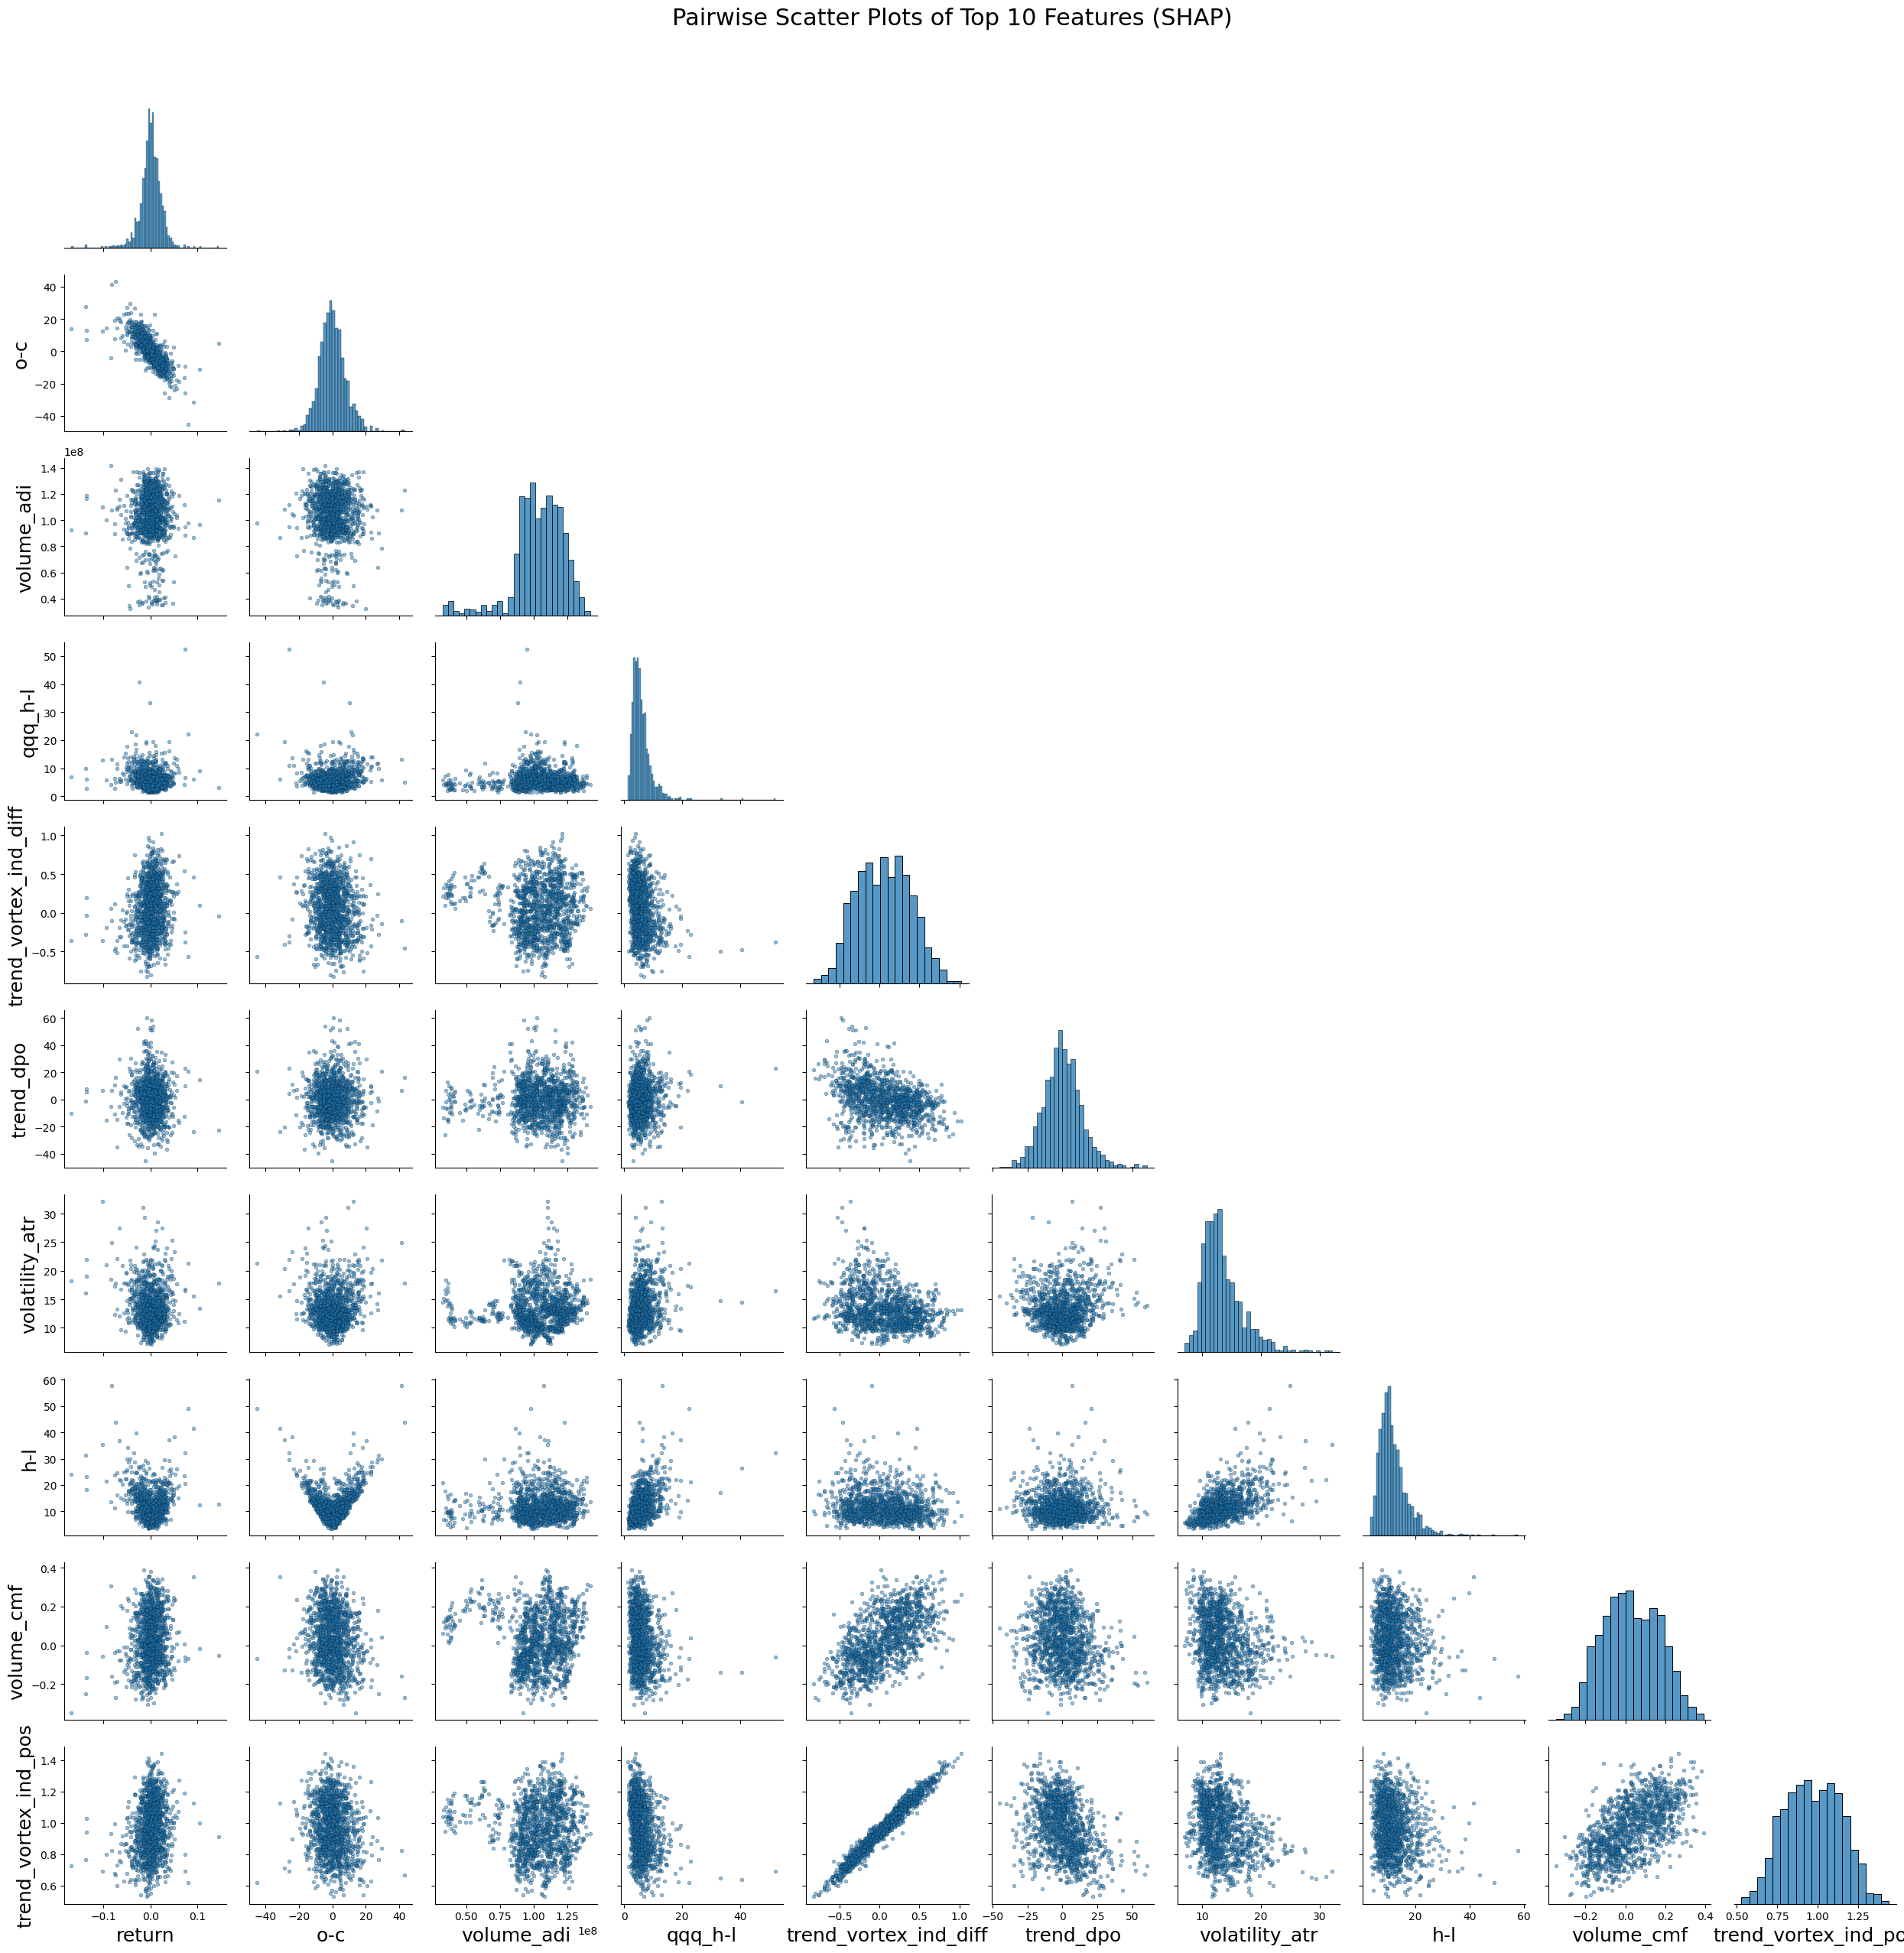

In [89]:
g = sns.pairplot(X[top_10_features], corner=True, plot_kws={'alpha': 0.5, 's': 12, 'edgecolor': 'k'})
g.fig.suptitle("Pairwise Scatter Plots of Top 10 Features (SHAP)", fontsize=22, y=1.02)

# Set axis label font size
for ax in g.axes.flatten():
    if ax:  # some axes might be None in corner=True layout
        ax.set_xlabel(ax.get_xlabel(), fontsize=18)
        ax.set_ylabel(ax.get_ylabel(), fontsize=18)

plt.tight_layout()
plt.show()

As illustrated in the visualizations:

- Many plots show feature values clustered along vertical lines, suggesting weak correlation between those pairs.

- `trend_vortex_ind_diff` and `trend_vortex_ind_pos` exhibit a **strong positive correlation**, forming a pronounced diagonal across their scatter plot.

- **Moderate positive correlations** are observed between:
  - `trend_vortex_ind_pos` and `volume_cmf`
  
  - `trend_vortex_ind_diff` and `volume_cmf`
  
  - `h-l` and `volatility_atr`

- **Moderate negative correlations** appear between:
  - `o-c` and `return`

  - `trend_vortex_ind_diff` and `trend_dpo`

- Most feature comparisons involving `volume_adi` produce **two distinct clusters**, indicating potential segmentation or bifurcation in behavior.

- The relationship between `o-c` and `h-l` is context-dependent:
  - When `o-c` is negative, the correlation is negative

  - When `o-c` is positive, the correlation appears positive  


These insights help pinpoint underlying dependencies and potential non-linear interactions within the most impactful features. I will document these findings for reference but hold off on taking any immediate action. These observations will be revisited during the multicollinearity analysis phase to inform further feature removal.


[**Back to Content**](#content)

<a id='3.3'></a>
## 3.3 Analyze multi-collinearity and reduce dimensionality

<a id='3.3.1'></a>
### 3.3.1 VIF analysis and correlation heatmap

Multicollinearity occurs when two or more independent variables are highly correlated with one
another in a regression model, and it can be detected using Variable Inflation Factors (VIF).   

VIF score of an independent variable represents how well the variable is explained by other independent
variables, and it is calculated by the following formula:
$$ VIF = \frac{1}{1 − R^2} $$

$R^2$ value is determined to find out how well an independent variable is described by the other
independent variables. A high value of $R^2$ means that the variable is highly correlated with the
other variables. 

VIF starts at $1$ (no correlation) and has no upper limit. In this case, we will remove highly correlated features and target to keep the remaining ones with VIF below $10$.

Create a function to compute VIF scores.

In [90]:
def compute_vif(df):
    # subsume into a dataframe
    df_vif = pd.DataFrame()
    df_vif["Features"] = df.columns
    df_vif["VIF Score"] = [variance_inflation_factor(df, i) for i in range(df.shape[1])]
    return df_vif.sort_values(by='VIF Score', ascending=False)

Compute VIF of the current scaled features and check the 50 features with highest VIF scores.

In [91]:
compute_vif(X_scaled)[:50]

/opt/anaconda3/envs/py310/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Features  VIF Score
47                   trend_aroon_down        inf
20                     volatility_kch        inf
72      trend_ichimoku_base_div_close        inf
71      trend_ichimoku_conv_div_close        inf
29                         trend_macd        inf
60                momentum_ppo_signal        inf
31                    trend_macd_diff        inf
32               trend_vortex_ind_pos        inf
33               trend_vortex_ind_neg        inf
34              trend_vortex_ind_diff        inf
38                          trend_kst        inf
39                      trend_kst_sig        inf
40                     trend_kst_diff        inf
46                     trend_aroon_up        inf
64                  momentum_pvo_hist        inf
48                    trend_aroon_ind        inf
63                momentum_pvo_signal        inf
62                       momentum_pvo        inf
61                  momentum_ppo_hist        inf
21                     volatility_kcl        inf
30                  trend_macd_signal        inf
19                     volatility_kcc        inf
16                     volatility_bbl        inf
88                       qqq_bbands_u        inf
87                       qqq_bbands_m        inf
86                       qqq_bbands_l        inf
73         trend_ichimoku_a_div_close        inf
14                     volatility_bbm        inf
15                     volatility_bbh        inf
59                       momentum_ppo        inf
35                         trend_trix   9482.907
70           trend_ema_slow_div_close   8646.385
66                          others_cr   5781.741
69           trend_ema_fast_div_close   3332.137
11                        volume_vwap   2998.145
24                     volatility_dch   1427.714
68           trend_sma_slow_div_close    960.215
67           trend_sma_fast_div_close    740.427
65                      momentum_kama    615.726
57                        momentum_ao    298.481
49                       momentum_rsi    221.841
18                     volatility_bbp    216.140
75  trend_visual_ichimoku_a_div_close    212.918
53                       momentum_tsi    176.274
84               qqq_ema_10_div_close    130.436
45                          trend_cci    110.998
83               qqq_sma_10_div_close     98.291
26                     volatility_dcp     93.383
10                         volume_vpt     88.051
51               momentum_stoch_rsi_k     83.440

Use heatmap to demonstrate the correlations.

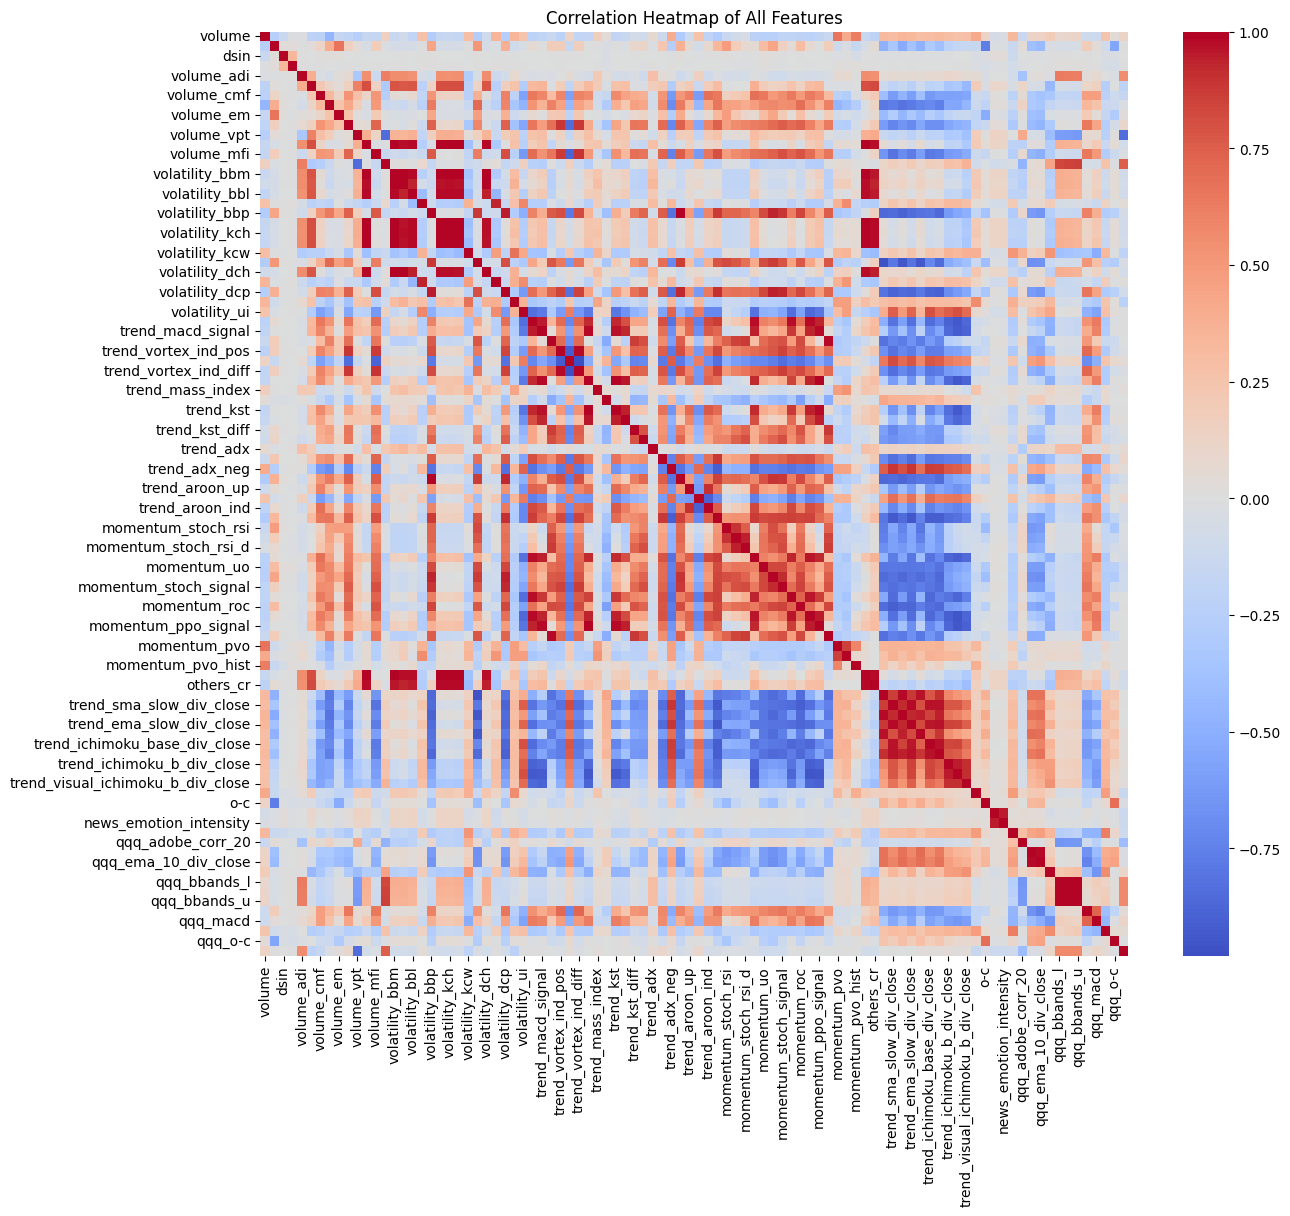

In [92]:
corr_matrix = X_scaled.corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False)
plt.title("Correlation Heatmap of All Features")
plt.show()

As shown in the table, a substantial portion of the feature set exhibits extremely high VIF scores, ranging from four-digit values to infinity, signaling **deep and complex interdependencies**.

This is vividly supported by the dense and vibrant correlation heatmap, which highlights a tightly woven matrix of relationships across features—visual evidence of severe multicollinearity.

Next, we will reudce dimensionality to mitigate the high multi-collinearity among the features.

[**Back to Content**](#content)

<a id='3.3.2'></a>
### 3.3.2 Reduce dimensionality

To address feature multicollinearity and enhance model robustness, we will try two dimensionality reduction techniques:

1. **Cluster-based selection**  
   - Apply unsupervised machine learning (e.g., KMeans) to group features based on similarity.

   - Within each cluster, retain only the feature with the highest mean absolute SHAP value to represent the group.

2. **Correlation-based filtering**  
   - Identify highly correlated feature pairs across the dataset.
   
   - For each pair, remove the feature with the lower mean absolute SHAP value to reduce redundancy.

PCA is avoided to preserve interpretability. Additionally, PCA only captures linear dependencies, while our exploratory scatter plots show nonlinear relationships, limiting PCA’s effectiveness in preserving feature structure.

<a id='3.3.2.1'></a>
#### 3.3.2.1 Cluster-based selection

To apply K-Means clustering on the features, we first need to construct a "feature-of-features" DataFrame that captures the characteristics of each feature. 

Since all features are numeric, we will use the standard `.describe()` method to summarize their statistical properties, effectively reflecting the quantitative nature of each feature.

In [93]:
df_features = X_scaled.describe().T

In [94]:
df_features

count   mean   std     min    25%   50%   75%    max
volume     1310.000  0.334 1.322  -1.461 -0.387 0.000 0.613 17.880
return     1310.000 -0.028 0.985  -7.339 -0.484 0.000 0.516  6.260
dsin       1310.000  0.578 0.382   0.000  0.277 0.723 0.901  1.000
dcos       1310.000  0.367 0.363   0.000  0.000 0.445 0.445  1.000
volume_adi 1310.000 -0.072 0.818  -3.181 -0.498 0.000 0.502  1.583
...             ...    ...   ...     ...    ...   ...   ...    ...
qqq_rsi    1310.000  0.514 0.198   0.000  0.371 0.531 0.661  1.000
qqq_macd   1310.000 -0.181 0.779  -3.111 -0.651 0.000 0.349  1.755
qqq_h-l    1310.000  0.226 1.022  -1.123 -0.407 0.000 0.593 13.977
qqq_o-c    1310.000  0.069 0.895 -10.313 -0.475 0.000 0.525  4.642
FEDFUNDS   1310.000  0.504 0.437   0.000  0.008 0.706 0.953  1.000

[94 rows x 8 columns]

Next, we’ll apply the Elbow method to identify the optimal number of clusters that align with our objective. Specifically, we’ll group the 94 features into clusters ranging from 2 to 60 and examine how the relative inertia (the measure of within-cluster compactness) declines as the number of clusters increases.

Text(0.5, 1.0, 'Elbow Plot of K-Means Clustering of Features')

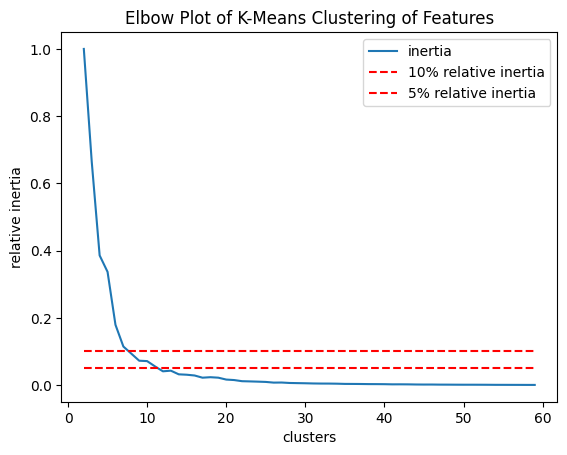

In [95]:
# Elbow Method
n_clusters = range(2, 60)
inertia = []

for n in n_clusters:
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(df_features)
    inertia.append(kmeans.inertia_)

plt.plot(n_clusters, np.divide(inertia,inertia[0]))
plt.hlines(0.1, n_clusters[0], n_clusters[-1], 'r', linestyles='dashed')
plt.hlines(0.05, n_clusters[0], n_clusters[-1], 'r', linestyles='dashed')
plt.xlabel('clusters')
plt.ylabel('relative inertia')
plt.legend(['inertia', '10% relative inertia', '5% relative inertia']);
plt.title('Elbow Plot of K-Means Clustering of Features')

The Elbow plot shows that relative inertia begins to plateau beyond 20 clusters, indicating that KMeans is approaching its limit in terms of meaningful compression. This suggests minimal gain from further increasing the number of clusters.

However, I am concerned that selecting only 20 clusters from 94 may risk discarding many potentially meaningful ones. To balance compression with feature diversity, I choose to retain 30 clusters instead.

Therefore, we need to group the features to 30 clusters and select a representative in each.

In [96]:
# Initialize the KMeans the model
K_means_model = KMeans(n_clusters=30, random_state=SEED)

# Fit the model
K_means_model.fit(df_features) 

# Assign labels
feature_labels = K_means_model.predict(df_features)

In [97]:
# Check lables
feature_labels

array([ 8, 17, 23,  5, 10,  1, 12,  2,  6, 18, 29, 25, 12, 20, 25, 25, 20,
       27, 25, 25, 20, 25,  9, 24, 25, 21, 29, 22, 21, 26, 26,  3, 20, 12,
       12,  3, 26, 13,  3,  3, 26, 23,  5,  5,  5, 10, 23, 23, 23,  5, 23,
       23, 23,  5,  5, 23, 23,  3, 24, 10, 10,  3, 21,  9, 19, 25, 20,  7,
       15,  7, 15,  7, 15, 15,  9, 15,  9, 16, 11, 23, 23,  0, 28,  7,  7,
        0, 25, 25, 25,  5, 10,  4, 14, 23], dtype=int32)

In [98]:
pd.Series(feature_labels).value_counts()

23    13
25    11
5      8
3      6
20     5
10     5
7      5
15     5
26     4
12     4
9      4
21     3
24     2
0      2
29     2
16     1
19     1
11     1
28     1
4      1
8      1
13     1
22     1
17     1
27     1
18     1
6      1
2      1
1      1
14     1
Name: count, dtype: int64

In [99]:
# Create the dataframe to show the clusters of the featuers
df_feature_cluster = pd.DataFrame({'Cluster': feature_labels,
                                   'Features': X_scaled.columns,}
                                 ).sort_values(by=['Cluster'], axis = 0)

df_feature_cluster = df_feature_cluster.reset_index(drop=True)
df_feature_cluster

Cluster           Features
0         0         qqq_volume
1         0            qqq_atr
2         1         volume_obv
3         2          volume_fi
4         3  momentum_ppo_hist
..      ...                ...
89       26         trend_macd
90       27     volatility_bbw
91       28  qqq_adobe_corr_20
92       29         volume_vpt
93       29     volatility_dcp

[94 rows x 2 columns]

Covert mean absolute SHAP scores to a dictionary for easy reference.

In [100]:
shap_score_map = dict(zip(feature_shap['feature'], feature_shap['mean_abs_shap']))

For each cluster of features, select the one with highest mean absolute SHAP value.

In [101]:
# Create a list to store the top features of each cluster
features_k_means = []

# Select the top features of each cluster
for i in range(30):
    list_temp = df_feature_cluster[df_feature_cluster['Cluster']==i]['Features'].to_list()
    top_feature = max(list_temp, key=lambda x: shap_score_map[x])
    features_k_means.append(top_feature)

# Check the featuers selected
print(features_k_means)

['qqq_volume', 'volume_obv', 'volume_fi', 'trend_kst', 'qqq_h-l', 'trend_adx_neg', 'volume_em', 'qqq_sma_10_div_close', 'volume', 'momentum_pvo_signal', 'volume_adi', 'o-c', 'trend_vortex_ind_diff', 'trend_dpo', 'qqq_o-c', 'trend_ichimoku_base_div_close', 'h-l', 'return', 'volume_sma_em', 'momentum_pvo_hist', 'trend_vortex_ind_pos', 'momentum_pvo', 'volatility_atr', 'momentum_stoch_rsi', 'momentum_roc', 'volume_vwap', 'trend_mass_index', 'volatility_bbw', 'qqq_adobe_corr_20', 'volume_vpt']


Check the VIF scores of the features.

In [102]:
compute_vif(X_scaled[features_k_means])

Features  VIF Score
21                   momentum_pvo  17808.064
9             momentum_pvo_signal  11406.629
19              momentum_pvo_hist   4729.073
12          trend_vortex_ind_diff     40.739
20           trend_vortex_ind_pos     35.398
15  trend_ichimoku_base_div_close     13.097
24                   momentum_roc     10.804
1                      volume_obv      7.978
25                    volume_vwap      7.640
5                   trend_adx_neg      7.230
3                       trend_kst      6.268
18                  volume_sma_em      6.024
29                     volume_vpt      5.005
2                       volume_fi      4.513
23             momentum_stoch_rsi      4.509
10                     volume_adi      4.097
17                         return      4.018
11                            o-c      3.601
8                          volume      3.524
0                      qqq_volume      3.296
7            qqq_sma_10_div_close      3.067
22                 volatility_atr      3.021
4                         qqq_h-l      2.712
16                            h-l      2.620
28              qqq_adobe_corr_20      2.334
14                        qqq_o-c      2.318
6                       volume_em      2.180
27                 volatility_bbw      2.100
13                      trend_dpo      2.074
26               trend_mass_index      1.948

As shown in the table above, while the cluster-based selection helps reduce multicollinearity by removing some features, it also comes with several limitations:

- **Super-high multicollinearity remains:** Some features still exhibit VIF scores in the 5-digit range, which is highly alarming.

- **Loss of feature diversity:** Key macroeconomic indicators like `FEDFUNDS`, sentiment-related features, and weekday-based features are excluded during selection. This reduction in feature variety is concerning.

- **No clear direction for cluster adjustment:** I won't suggest to adjust the clustering amount as a solution, as increasing clusters may worsen multicollinearity, while decreasing them could further reduce feature diversity.

Given these concerns, I’ll pause further action and explore correlation-based feature selection instead.

[**Back to Content**](#content)

<a id='3.3.2.2'></a>
#### 3.3.2.2 Correlation-based selection

This approach is more straightforward: identify pairs of highly correlated features from the correlation matrix, then remove the one with the lower mean absolute SHAP value in each pair. This strategy balances redundancy reduction with preservation of predictive impact.

Frist, we set threshold at $0.85$, and filter out the pair of features with correlation score higher than it.

In [103]:
# Define a list to store the highly correlated feature pairs
high_corr_pairs = []

# Set the threshold
threshold = 0.85

# Identify the highly correlated feature pairs from the overall correlation matrix
for i in range(corr_matrix.shape[0]):
    for j in range(i+1, corr_matrix.shape[1]):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            high_corr_pairs.append((corr_matrix.index[i], corr_matrix.columns[j],corr_matrix.iloc[i, j]))

In [104]:
# Check the pair amount.
print(f"There are {len(high_corr_pairs)} pairs of features have a correlation score higher than {threshold}.")

There are 201 pairs of features have a correlation score higher than 0.85.


In [105]:
# Check the pairs.
high_corr_pairs

[('volume_sma_em', 'trend_vortex_ind_pos', np.float64(0.8843591241236821)),
 ('volume_sma_em', 'trend_vortex_ind_diff', np.float64(0.8820348473883182)),
 ('volume_vpt', 'volume_nvi', np.float64(-0.852591053473897)),
 ('volume_vwap', 'volatility_bbm', np.float64(0.9942922429736901)),
 ('volume_vwap', 'volatility_bbh', np.float64(0.9737889263025752)),
 ('volume_vwap', 'volatility_bbl', np.float64(0.9826607285920061)),
 ('volume_vwap', 'volatility_kcc', np.float64(0.9980432088737117)),
 ('volume_vwap', 'volatility_kch', np.float64(0.9978018319088022)),
 ('volume_vwap', 'volatility_kcl', np.float64(0.9970562785147441)),
 ('volume_vwap', 'volatility_dch', np.float64(0.9775605765021835)),
 ('volume_vwap', 'momentum_kama', np.float64(0.9953896293445033)),
 ('volume_vwap', 'others_cr', np.float64(0.9766511772025368)),
 ('volume_mfi', 'trend_vortex_ind_pos', np.float64(0.8686547901203424)),
 ('volume_mfi', 'trend_vortex_ind_neg', np.float64(-0.8823150000284824)),
 ('volume_mfi', 'trend_vortex_i

There are 201 feature pairs with correlation coefficients exceeding $0.85$, indicating a dense web of interrelationships. This high degree of multicollinearity suggests that removing even a single feature from a pair may lead to a notable reduction in VIF scores across multiple features.

Then, we examine each highly correlated pair and select the feature with the lower mean absolute SHAP value as a candidate for removal. 

Let's assess how many unique candidates emerge from this selection process.

In [106]:
# Create a set to store the removal candidate, this is to avoid duplication.
features_to_drop = set()

# Check each pair and add the one with lower VIF to the set.
for f1, f2, corr_val in high_corr_pairs:
    if shap_score_map[f1] > shap_score_map[f2]:
        drop_candidate = f2
    else:
        drop_candidate = f1

    features_to_drop.add(drop_candidate)

Check the set of features to remove.

In [107]:
features_to_drop

{'momentum_ao',
 'momentum_kama',
 'momentum_ppo',
 'momentum_ppo_hist',
 'momentum_ppo_signal',
 'momentum_pvo_signal',
 'momentum_rsi',
 'momentum_stoch',
 'momentum_stoch_rsi_d',
 'momentum_stoch_rsi_k',
 'momentum_stoch_signal',
 'momentum_tsi',
 'news_sentiment_score',
 'others_cr',
 'qqq_bbands_l',
 'qqq_bbands_m',
 'qqq_ema_10_div_close',
 'trend_aroon_down',
 'trend_aroon_ind',
 'trend_ema_fast_div_close',
 'trend_ema_slow_div_close',
 'trend_ichimoku_a_div_close',
 'trend_ichimoku_b_div_close',
 'trend_ichimoku_base_div_close',
 'trend_kst_sig',
 'trend_macd',
 'trend_macd_diff',
 'trend_macd_signal',
 'trend_sma_fast_div_close',
 'trend_sma_slow_div_close',
 'trend_trix',
 'trend_visual_ichimoku_a_div_close',
 'trend_visual_ichimoku_b_div_close',
 'trend_vortex_ind_neg',
 'trend_vortex_ind_pos',
 'volatility_bbh',
 'volatility_bbl',
 'volatility_bbm',
 'volatility_bbp',
 'volatility_bbw',
 'volatility_dch',
 'volatility_dcp',
 'volatility_kcc',
 'volatility_kch',
 'volatility

In [108]:
len(features_to_drop)

49

Based on the SHAP-guided feature selection process, 49 features are suggested to remove, so we will have 45 features left.

Now, we reassess the feature set of the 45 remaining ones to evaluate whether multicollinearity is sufficiently mitigated, and observe how VIF scores changes.

In [109]:
compute_vif(X_scaled.drop(columns = features_to_drop))

Features  VIF Score
27                    momentum_uo     41.073
9                      volume_vpt     41.071
23                  trend_adx_neg     40.871
22                  trend_adx_pos     35.283
40                        qqq_rsi     34.294
44                       FEDFUNDS     34.048
10                    volume_vwap     20.591
26             momentum_stoch_rsi     18.633
39                   qqq_bbands_u     16.832
14                  volatility_ui     15.668
18                      trend_kst     13.643
28                   momentum_roc     13.542
5                      volume_obv     11.244
31  trend_ichimoku_conv_div_close     11.164
20                      trend_stc     10.569
15          trend_vortex_ind_diff     10.361
13                 volatility_atr     10.116
11                 volatility_kcw      9.995
24                      trend_cci      9.498
25                 trend_aroon_up      9.246
41                       qqq_macd      8.733
19                 trend_kst_diff      8.149
21                      trend_adx      7.869
38                        qqq_atr      7.281
7                       volume_fi      6.624
37           qqq_sma_10_div_close      5.396
29                   momentum_pvo      5.268
4                      volume_adi      4.883
12                 volatility_dcw      4.660
30              momentum_pvo_hist      4.406
1                          return      4.271
0                          volume      4.241
2                            dsin      3.910
33                            o-c      3.894
35                     qqq_volume      3.856
42                        qqq_h-l      3.483
6                      volume_cmf      3.347
36              qqq_adobe_corr_20      3.192
32                            h-l      2.920
16               trend_mass_index      2.715
43                        qqq_o-c      2.518
3                            dcos      2.342
8                       volume_em      2.339
17                      trend_dpo      2.207
34         news_emotion_intensity      2.141

This result is more acceptable than that of the cluster-based selection:

- **Multicollinearity is significantly reduced**, the highest VIF score is now around 40. While VIF scores between 10 and 40 still suggest moderate collinearity, they are unlikely to affect the model we will build substantially now, as LSTM neural networks are less sensitive to multicollinearity than linear models.

- **Feature diversity is preserved**, including:
  - `news_emotion_intensity` for sentiment analysis

  - `dcos` for weekday patterns

  - `FEDFUNDS` for macroeconomic signals

Since the correlation-based filtering performs well, I will retain this refined feature set for modeling.

In [110]:
X_scaled.drop(columns = features_to_drop, inplace = True)

Check the updated features.

In [111]:
X_scaled.shape

(1310, 45)

In [112]:
X_scaled.head()

volume  return  dsin  dcos  volume_adi  volume_obv  volume_cmf  \
date                                                                         
2020-04-15   0.121  -1.091 0.723 0.000      -3.066      -0.917       0.552   
2020-04-16   0.902   1.282 0.277 0.000      -2.996      -0.858       0.330   
2020-04-17   0.493   0.135 0.000 0.445      -3.035      -0.808       0.171   
2020-04-20   0.088   0.054 0.901 1.000      -3.004      -0.767       0.590   
2020-04-21   0.639  -2.045 1.000 0.445      -3.092      -0.820       0.303   

            volume_fi  volume_em  volume_vpt  ...  qqq_volume  \
date                                          ...               
2020-04-15      0.649     -0.136       0.527  ...       0.035   
2020-04-16      0.943      0.378       0.541  ...       0.754   
2020-04-17      0.851      0.335       0.543  ...       0.681   
2020-04-20      0.746     -0.234       0.544  ...      -0.323   
2020-04-21      0.081     -1.399       0.524  ...       1.091   

            qqq_adobe_corr_20  qqq_sma_10_div_close  qqq_atr  qqq_bbands_u  \
date                                                                         
2020-04-15              0.132                -1.885    0.469        -1.131   
2020-04-16              0.072                -1.968    0.323        -1.108   
2020-04-17              0.170                -1.801    0.248        -1.098   
2020-04-20              0.083                -0.910    0.145        -1.122   
2020-04-21              0.287                 0.552    0.227        -1.104   

            qqq_rsi  qqq_macd  qqq_h-l  qqq_o-c  FEDFUNDS  
date                                                       
2020-04-15    0.674    -0.158   -0.176   -0.105     0.000  
2020-04-16    0.641    -0.009   -0.186   -0.209     0.000  
2020-04-17    0.744     0.126   -0.257    0.219     0.000  
2020-04-20    0.666     0.196   -0.579    0.191     0.000  
2020-04-21    0.582     0.152    0.632    1.232     0.000  

[5 rows x 45 columns]

Check the correlation heatmap of updated features.

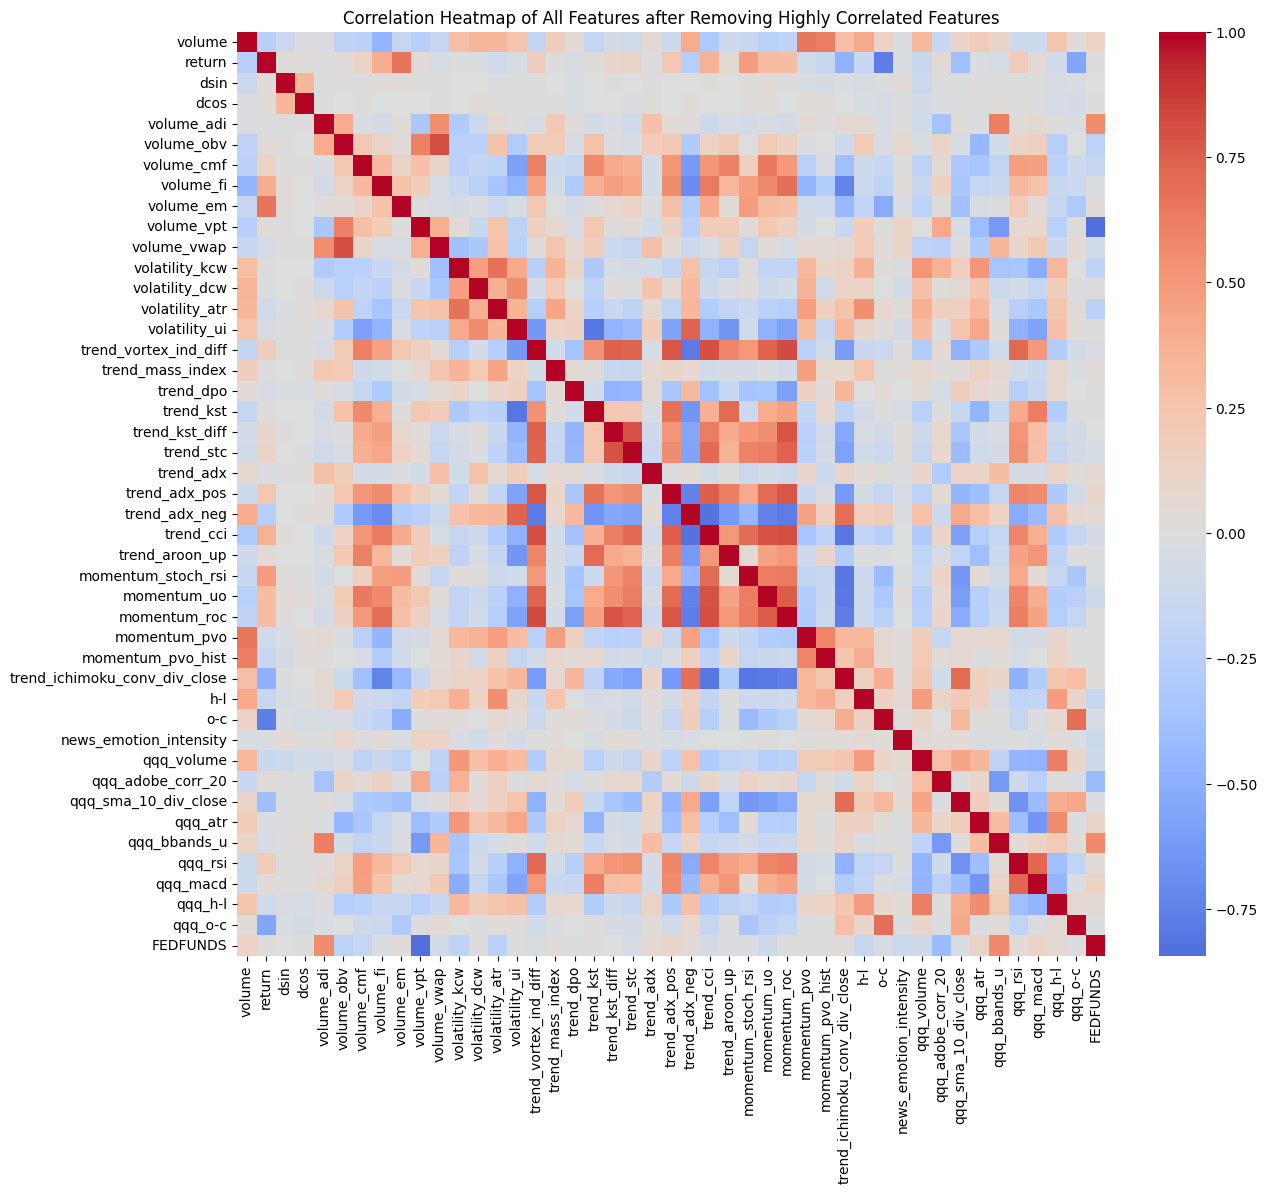

In [113]:
corr_matrix = X_scaled.corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False)
plt.title("Correlation Heatmap of All Features after Removing Highly Correlated Features")
plt.show()

The successful reduction of collinearity is also evident in the more desaturated heatmap. 

Next, we proceed to model building with our well-prepared feature set.

[**Back to Content**](#content)

<a id='4'></a>
# 4. Model Building

Model building is the core of this project. In this chapter, we will explore several LSTM architectures and fine-tune them to identify the optimal structure and hyperparameter configuration for predicting Adobe's next-day upward movement. 

Below are some key considerations for this model building exercise:

1. **Architecture exploreation**

   We concentrate on LSTM models with **2 or 3 layers, with or without dropout**:
    
    - Baseline model: 2-layer LSTM without dropout
    - Additional variants:
      - A: 2-layer LSTM with dropout
    
      - B: 3-layer LSTM without dropout
      
      - C: 3-layer LSTM with dropout
    
    
    - All models include a final `Dense` output layer with sigmoid activation for binary classification.
    
    - Models are evaluated using the metrics of AUC, F1 Score, Accuracy, Recall and Precision.
    
    - Due to the limited sample size (`n = 1310`), architectures with 4 or more LSTM layers are excluded to avoid overfitting.

2. **Hyperparameter optimization**

   For each candidate architecture, we will use **Bayesian Optimization** to tune:
    
    - Number of LSTM units per layer: $5$ to $25$, at the step of $5$
    
    - Dropout rates (where applicable): $[0.3, 0.4, 0.5, 0.6]$
     
    - Learning rate: $[0.0005, 0.001, 0.002]$
     
    - Activation functions: $[\text{'elu'}, \text{'relu'}]$

3. **Other key hyperparameter design choices**:
    - Optimization objective: maximize accuracy of validation set (`val_accuracy`). Maximizing validation AUC can often lead to zero class 1 prediction in this project due to balanced targets.
    
    - Training epochs: $200$
    
    - Early stopping patience: $20$
  
    - Optimizer: Adam

4. **Reproducibility considerations**:

    - Due to TensorFlow’s non‑determinism (LSTM kernels, GPU parallelism) and the stochastic nature of Bayesian search, **exact reproducibility of tuning results is not guaranteed**.
    
    - To mitigate variance, each architecture’s tuning will be run three times, and the best result from those runs will be saved and represent that model.
    
    - Although individual runs vary, performance across runs for a given structure should fall within a consistent range, allowing meaningful comparisons.

5. **Others**:

    - Training progress is logged using TensorBoard for transparent tracking.
    
    - Among the 4 optimized models, the one with best evaluation result on testing set will be selected for backtesting in the next chapter.

[**Back to Content**](#content)

<a id='4.1'></a>
## 4.1 Prepare dataset 

<a id='4.1.1'></a>
### 4.1.1 Split and scale the dataset

To ensure a leak-free modeling pipeline, we begin by reverting to the **unscaled version of the dataset**. From there:

- Restrict the dataset to the 45 features finalized in previous EDA phases.

- Split this unscaled data into training, validation and testing sets, preserving chronological order for time-series integrity.

- Fit scaling transformations (StandardScaler, MinMaxScaler, RobustScaler for respective features as appropriate) only on the training set to prevent future data (validation and testing sets) from influencing learned parameters.

- Apply the fitted scalers to the validation and testing sets to maintain consistency.

This approach preserves temporal structure and statistical independence across splits, laying a clean foundation for reliable LSTM training.

First, create a list of finalized features and categorize them into the three predefined groups.

In [114]:
# List of finalized features
feature_finalized = X_scaled.columns

# Categorize them into 3 lists
features_finalized_normal = [x for x in feature_finalized if x in features_normal]
features_finalized_bounded = [x for x in feature_finalized if x in features_bounded]
features_finalized_skewed_tailed_clustered = [x for x in feature_finalized if x in features_skewed_tailed_clustered]

Next, filter the unscaled dataset using these finalized features to create a clean `X_filtered` dataframe.

In [115]:
X_filtered = X[feature_finalized]

Then, split `X_filtered` and `y` into training, validation and testing sets.

In [116]:
X_train, X_temp, y_train, y_temp = train_test_split(X_filtered, y, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)
print(f"Training, validation and testing sets have sizes of {len(X_train)}, {len(X_val)} and {len(X_test)} respectively.")

Training, validation and testing sets have sizes of 917, 196 and 197 respectively.


Fit the appropriate scalers on the training data only, based on each feature group’s categorization.

In [117]:
# Initialize scalers
scaler_standard = StandardScaler()
scaler_minmax = MinMaxScaler()
scaler_robust = RobustScaler()

# Copy to initialize the scaled data
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

# Fit-transform training data per group
X_train_scaled[features_finalized_normal] = scaler_standard.fit_transform(X_train[features_finalized_normal])
X_train_scaled[features_finalized_bounded] = scaler_minmax.fit_transform(X_train[features_finalized_bounded])
X_train_scaled[features_finalized_skewed_tailed_clustered] = scaler_robust.fit_transform(X_train[features_finalized_skewed_tailed_clustered])

Transform the testing data using the fitted scalers to ensure consistent scaling.

In [118]:
# Transform validation and testing data with corresponding scalers
X_val_scaled[features_finalized_normal] = scaler_standard.transform(X_val[features_finalized_normal])
X_val_scaled[features_finalized_bounded] = scaler_minmax.transform(X_val[features_finalized_bounded])
X_val_scaled[features_finalized_skewed_tailed_clustered] = scaler_robust.transform(X_val[features_finalized_skewed_tailed_clustered])

X_test_scaled[features_finalized_normal] = scaler_standard.transform(X_test[features_finalized_normal])
X_test_scaled[features_finalized_bounded] = scaler_minmax.transform(X_test[features_finalized_bounded])
X_test_scaled[features_finalized_skewed_tailed_clustered] = scaler_robust.transform(X_test[features_finalized_skewed_tailed_clustered])

In [119]:
X_train_scaled.head()

volume  return  dsin  dcos  volume_adi  volume_obv  volume_cmf  \
date                                                                         
2020-04-15   0.181  -1.009 0.723 0.000      -3.299      -1.220       0.438   
2020-04-16   0.990   1.124 0.277 0.000      -3.218      -1.152       0.226   
2020-04-17   0.566   0.093 0.000 0.445      -3.264      -1.094       0.075   
2020-04-20   0.147   0.020 0.901 1.000      -3.228      -1.045       0.474   
2020-04-21   0.718  -1.866 1.000 0.445      -3.330      -1.107       0.200   

            volume_fi  volume_em  volume_vpt  ...  qqq_volume  \
date                                          ...               
2020-04-15      0.629     -0.145       0.142  ...      -0.092   
2020-04-16      0.959      0.318       0.163  ...       0.563   
2020-04-17      0.855      0.279       0.165  ...       0.496   
2020-04-20      0.738     -0.234       0.166  ...      -0.418   
2020-04-21     -0.010     -1.286       0.137  ...       0.870   

            qqq_adobe_corr_20  qqq_sma_10_div_close  qqq_atr  qqq_bbands_u  \
date                                                                         
2020-04-15             -0.057                -1.763    0.639        -1.576   
2020-04-16             -0.170                -1.840    0.482        -1.534   
2020-04-17              0.015                -1.684    0.402        -1.515   
2020-04-20             -0.149                -0.854    0.291        -1.558   
2020-04-21              0.237                 0.507    0.379        -1.525   

            qqq_rsi  qqq_macd  qqq_h-l  qqq_o-c  FEDFUNDS  
date                                                       
2020-04-15    0.712    -0.099   -0.129   -0.107     0.000  
2020-04-16    0.676     0.048   -0.139   -0.214     0.000  
2020-04-17    0.785     0.181   -0.215    0.225     0.000  
2020-04-20    0.702     0.250   -0.557    0.197     0.000  
2020-04-21    0.614     0.207    0.731    1.265     0.000  

[5 rows x 45 columns]

In [120]:
print(X_train_scaled.shape, X_val_scaled.shape, X_test_scaled.shape)

(917, 45) (196, 45) (197, 45)


The datasets are now fully prepared for LSTM model building.

[**Back to Content**](#content)

<a id='4.1.2'></a>
### 4.1.2 Create data generator

In this project of building LSTM model, a critical design choice is selecting an appropriate sequence length — the number of consecutive past days used as input for predicting the following day.

For a technology stock like Adobe, a span of approximately one month ($20–22$ trading days) offers a practical balance:
- Captures medium-term momentum and volatility trends

- Preserves recent signal strength

- Avoids overextending input length, which could dilute temporal relevance and increase model complexity

Based on this reasoning, we set the **sequence length to $21$ days**.


In [121]:
# Sequence length
seqlen = 21

Get the number of features.

In [122]:
# Number of features
numfeat = X_train_scaled.shape[1]
numfeat

45

Create a data generator using a **batch size of $32$**, considering the moderate dataset size and standard computing resources.

In [123]:
g_train = TimeseriesGenerator(X_train_scaled, y_train, length=seqlen, batch_size=32)
g_val = TimeseriesGenerator(X_val_scaled, y_val, length=seqlen, batch_size=32)
g_test = TimeseriesGenerator(X_test_scaled, y_test, length=seqlen, batch_size=32)

Check the sequence data generated.

In [124]:
g_train[4][1]

/opt/anaconda3/envs/py310/lib/python3.10/site-packages/keras/src/legacy/preprocessing/sequence.py:120: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = np.array([self.targets[row] for row in rows])


array([0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 0, 1])

In [125]:
print(f"The are {len(g_train)} batches in the training set, {len(g_val)} in the validation set, and {len(g_test)} batches in the testing set. The dimension of features in one batch is {g_train[1][0].shape}.")

The are 28 batches in the training set, 6 in the validation set, and 6 batches in the testing set. The dimension of features in one batch is (32, 21, 45).


[**Back to Content**](#content)

<a id='4.2'></a>
## 4.2 Baseline model - 2 layer LSTM model without dropout

<a id='4.2.1'></a>
### 4.2.1 Build the model (2 layers without dropout)

First, create a HyperParameters class to build the model with hyperparameters for fine-tuning included.

In [126]:
def model_2layer_no_dropout(hp):
    
    tf.keras.backend.clear_session()   

    # Instantiate the model
    model = Sequential()
    
    # Tune the number of units in the layers
    hp_units1 = hp.Int('units1', min_value=5, max_value=25, step=5)
    hp_units2 = hp.Int('units2', min_value=5, max_value=25, step=5)

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[0.0005, 0.001, 0.002])

    # Tune activation functions
    hp_activation1 = hp.Choice(name = 'activation1', values = ['relu', 'elu'], ordered = False)
    hp_activation2 = hp.Choice(name = 'activation2', values = ['relu', 'elu'], ordered = False)
    
    # Build the model
    model.add(LSTM(hp_units1, input_shape=(seqlen, numfeat), activation=hp_activation1, return_sequences=True, name='LSTM1'))   
    
    model.add(LSTM(hp_units2, activation = hp_activation2, return_sequences=False, name='LSTM2'))
    
    model.add(Dense(units=1, activation='sigmoid', name='output'))    

    # Specify optimizer separately (preferred method))
    opt = Adam(learning_rate=hp_learning_rate, epsilon=1e-08)       
    
    # Model compilation
    model.compile(optimizer=opt, loss=BinaryCrossentropy(), metrics=['accuracy', Precision(), Recall(), AUC(name='auc')])

    return model

In [127]:
# Initialize an early stopping callback
logdir_2layer_no_dropout = os.path.join("./tensorboard/2layer_no_dropout", dt.datetime.now().strftime("%Y%m%d-%H%M%S"))

callbacks_2layer_no_dropout = [
    EarlyStopping(patience=20, monitor='val_loss', mode='min', verbose=1, restore_best_weights=True),
    TensorBoard(log_dir=logdir_2layer_no_dropout, histogram_freq=1)
]

Set up Bayesian Optimization

In [128]:
# BayesianOptimization algorithm from keras tuner
botuner_2layer_no_dropout = BayesianOptimization(
    model_2layer_no_dropout,
    objective="val_accuracy",
    max_trials=20,
    num_initial_points=6,
    overwrite=True,
    directory="./parameter_optimization",
    project_name="2layer_no_dropout",
)

/opt/anaconda3/envs/py310/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Run the training and tuning process and get the best model and parameters from the optimization. 

As the result is not deterministic, activate below code only when you need to rerun and generate a new model with tuned hyperparameters.

In [148]:
# # Launch tuning process
# botuner_2layer_no_dropout.search(g_train, epochs=200, validation_data=g_val, callbacks=callbacks_2layer_no_dropout, shuffle=False)

# # Obtain the best model and parameters
# model_2layer_no_dropout = botuner_2layer_no_dropout.get_best_models(num_models=1)[0]
# param_2layer_no_dropout = botuner_2layer_no_dropout.get_best_hyperparameters()[0]

Trial 20 Complete [00h 00m 09s]
val_accuracy: 0.6000000238418579

Best val_accuracy So Far: 0.6171428561210632
Total elapsed time: 00h 03m 15s


Save and reload the model. This is to maintain consistent evaluation against the testing dataset. The saved model represents the best-performing version out of three runs conducted on 28 July 2025.

In [158]:
# # Save the model and the parameters.
# model_2layer_no_dropout.save('./models&params/model_2layer_no_dropout.keras')
# with open("./models&params/param_2layer_no_dropout.json", "w") as f:
#     json.dump(param_2layer_no_dropout.values, f)

In [129]:
# # Reload the model.
model_2layer_no_dropout = load_model("./models&params/model_2layer_no_dropout.keras")

/opt/anaconda3/envs/py310/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Visualize the model structure.

In [130]:
# Summary
model_2layer_no_dropout.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM1 (LSTM)                    │ (None, 21, 20)         │         5,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM2 (LSTM)                    │ (None, 5)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,420 (68.05 KB)

 Trainable params: 5,806 (22.68 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,614 (45.37 KB)

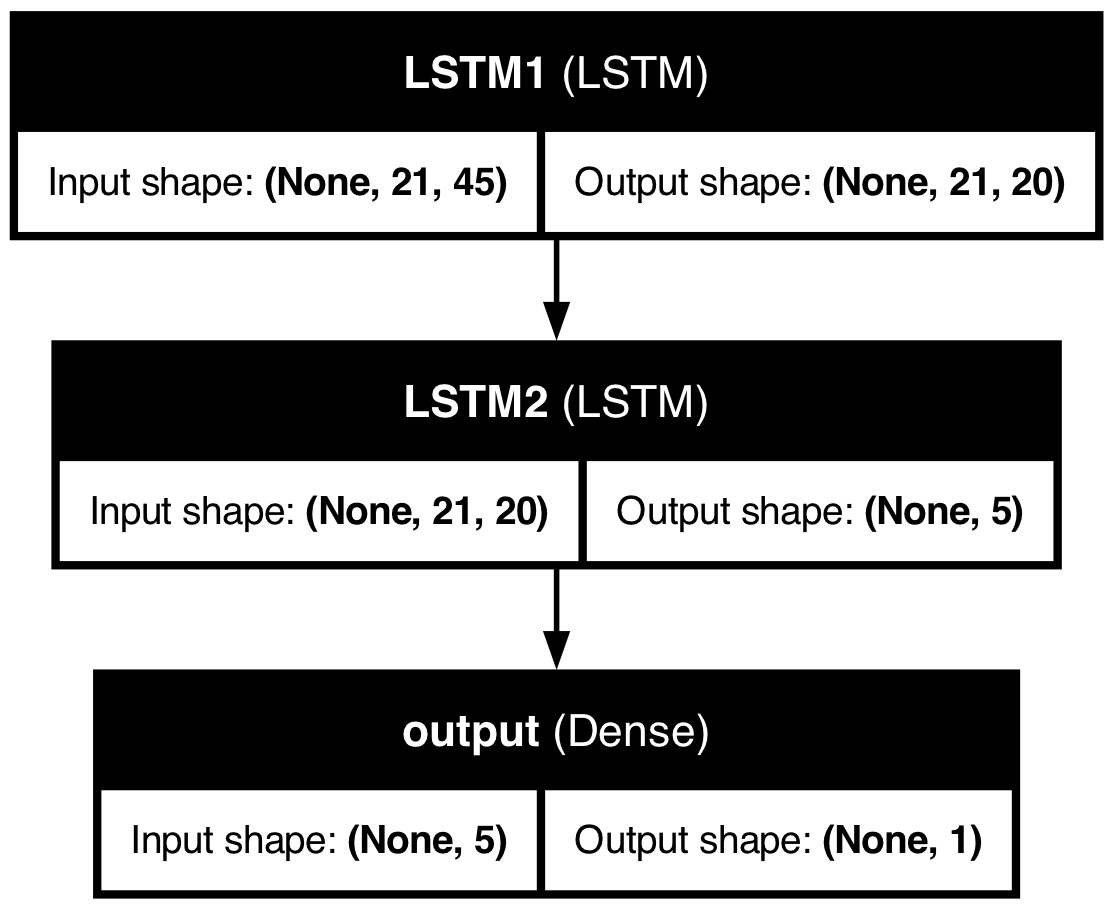

In [131]:
# Plot layers
plot_model(model_2layer_no_dropout, show_shapes=True, show_layer_names=True)

Training experience on TensorBoard.

In [132]:
%tensorboard --logdir ./tensorboard/2layer_no_dropout/20250728-113649

**Simple intepreatation on TensorBoard results (`TIME SERIES` tab):**
- In the `epoch_accuracy` plot, across all the hyperparameter trials, most of them showed increasing validation accuracy, roughly converging in 3 clusters $[0.5, 0.56, 0.63]$ by epoch 25. The best-performing run achieved a validation accuracy of ~$0.68$, indicating solid learning progress. This reflects effective hyperparameter tuning to improve the accuracy.

- The `epoch_auc` plot shows that most model configurations gradually improve their validation AUC over training epochs. Although the AUCs of some trails started around or below $0.5$ (random guessing), many of them reached above $0.65$, and the best even delivers $0.74$, indicating good discriminative power accumulated during the training.

- The `epoch_loss` panel shows the binary cross-entropy loss over training epochs for different hyperparameter configurations. Among all the trials, approximately half showed steadily decreasing loss values, indicating effective learning. Other trials exhibited oscillating loss curves and entered early stopping very soon, suggesting less effective hyperparameter settings.

- Generally speaking, most trails can finish learning around 30 epochs with improved accuracy, AUC and decreased loss. The optimized model from this training experience should demonstrate certain value in the later evaluation. 

[**Back to Content**](#content)

<a id='4.2.2'></a>
### 4.2.2 Evaluate the model (2 layers without dropout)

<a id='4.2.2.1'></a>
#### 4.2.2.1 Evaluate the training data against the testing data

In [133]:
results = model_2layer_no_dropout.evaluate(g_train, verbose=0)
print(f"Training accuracy: {results[1]:.2f}")

/opt/anaconda3/envs/py310/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/opt/anaconda3/envs/py310/lib/python3.10/site-packages/keras/src/legacy/preprocessing/sequence.py:120: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = np.array([self.targets[row] for row in rows])


Training accuracy: 0.63


In [134]:
results = model_2layer_no_dropout.evaluate(g_test, verbose=0)
print(f"Testing accuracy: {results[1]:.2f}")

Testing accuracy: 0.55


<a id='4.2.2.2'></a>
#### 4.2.2.2 Use the model to generate predictions on the testing data and conduct a more comprehensive performance analysis

In [135]:
# Predictions 
y_prob = model_2layer_no_dropout.predict(g_test)
y_pred = np.where(y_prob > 0.5, 1, 0)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Visualize the test result.

AUC: 0.5217


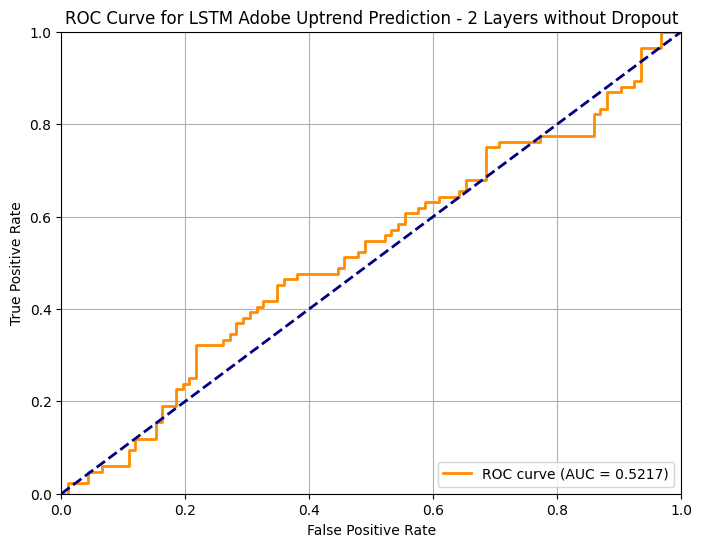

In [136]:
# Align labels with predictions
y_test_trimmed = y_test[seqlen:] 

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test_trimmed, y_prob)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc:.4f}")

# Plot ROC curve with grid and diagonal reference line
plt.figure(figsize=(8, 6))

# Plot ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',)

# Labels, grid, and legend
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LSTM Adobe Uptrend Prediction - 2 Layers without Dropout')
plt.legend(loc="lower right")
plt.grid(True)

plt.show()

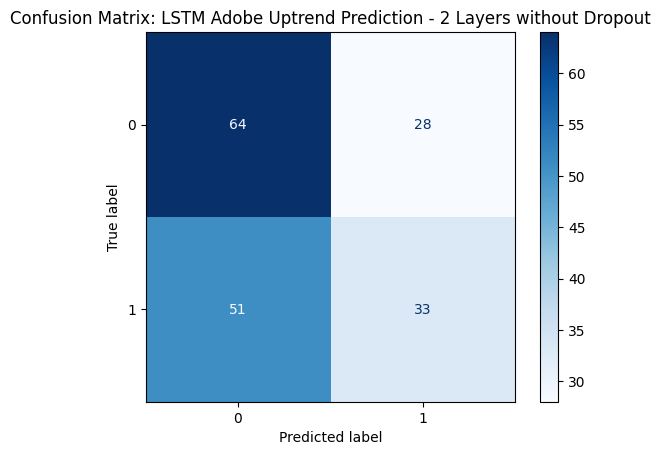

In [137]:
cm = confusion_matrix(y_test_trimmed, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix: LSTM Adobe Uptrend Prediction - 2 Layers without Dropout')
plt.grid(False)
plt.show()

In [138]:
print(classification_report(y_test_trimmed, y_pred, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.56      0.70      0.62        92
           1       0.54      0.39      0.46        84

    accuracy                           0.55       176
   macro avg       0.55      0.54      0.54       176
weighted avg       0.55      0.55      0.54       176



[**Back to Content**](#content)

<a id='4.2.2.3'></a>
#### 4.2.2.3 Baseline model evaluation summary
**Training Metrics**
- Accuracy: $0.63$

**Testing Metrics**
- Accuracy: $0.55$

- AUC: $0.52$

- Class 1 precision: $0.54$

- Class 1 recall: $0.39$

- Class 1 F1 score: $0.46$



**Interpretation**
- Moderate learning without extreme overfitting: Training accuracy of $0.63$ suggests the model learned moderately and testing accuracy of $0.55$, indicates limited generalization with some room for performance gains.

- Limited discriminative power: AUC of $0.52$ shows near-random separation capability.

- Weak signal capture: precision ($0.54$), recall ($0.39$), and F1 score ($0.46$) suggest the model struggles to identify upward trends.

- It’s an acceptable starting point for iterative refinement. In our futher effort, additional layer may improve signal capture.


[**Back to Content**](#content)

<a id='4.3'></a>
## 4.3 Variant model A - 2 layer LSTM model with dropout

<a id='4.3.1'></a>
### 4.3.1 Build the model (2 layers with dropout)

First, create a HyperParameters class to build the model with hyperparameters for fine-tuning included.

In [139]:
def model_2layer_dropout(hp):
    
    tf.keras.backend.clear_session()   

    # Instantiate the model
    model = Sequential()
    
    # Tune the number of units in the layers
    hp_units1 = hp.Int('units1', min_value=5, max_value=25, step=5)
    hp_units2 = hp.Int('units2', min_value=5, max_value=25, step=5)

    # Tune the dropout rate
    hp_dropout1 = hp.Float('dropout1', min_value=0.3, max_value=0.6, step=0.1)
    
    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[0.0005, 0.001, 0.002])

    # Tune activation functions
    hp_activation1 = hp.Choice(name = 'activation1', values = ['relu', 'elu'], ordered = False)
    hp_activation2 = hp.Choice(name = 'activation2', values = ['relu', 'elu'], ordered = False)
    
    # Build the model
    model.add(LSTM(hp_units1, input_shape=(seqlen, numfeat), activation=hp_activation1, return_sequences=True, name='LSTM1'))
    model.add(Dropout(hp_dropout1, name='dropout1'))
    
    model.add(LSTM(hp_units2, activation = hp_activation2, return_sequences=False, name='LSTM2'))
    
    model.add(Dense(units=1, activation='sigmoid', name='output'))    

    # Specify optimizer separately (preferred method))
    opt = Adam(learning_rate=hp_learning_rate, epsilon=1e-08)       
    
    # Model compilation
    model.compile(optimizer=opt, loss=BinaryCrossentropy(), metrics=['accuracy', Precision(), Recall(), AUC(name='auc')])

    return model

In [140]:
# Initialize an early stopping callback
logdir_2layer_dropout = os.path.join("./tensorboard/2layer_dropout", dt.datetime.now().strftime("%Y%m%d-%H%M%S"))

callbacks_2layer_dropout = [
    EarlyStopping(patience=20, monitor='val_loss', mode='min', verbose=1, restore_best_weights=True),
    TensorBoard(log_dir=logdir_2layer_dropout, histogram_freq=1)
]

Set up Bayesian Optimization

In [141]:
# BayesianOptimization algorithm from keras tuner
botuner_2layer_dropout = BayesianOptimization(
    model_2layer_dropout,
    objective="val_accuracy",
    max_trials=20,
    num_initial_points=6,
    overwrite=True,
    directory="./parameter_optimization",
    project_name="2layer_dropout",
)

/opt/anaconda3/envs/py310/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Run the training and tuning process and get the best model and parameters from the optimization. 

As the result is not deterministic, activate below code only when you need to rerun and generate a new model with tuned hyperparameters.

In [197]:
# # Launch tuning process
# botuner_2layer_dropout.search(g_train, epochs=200, validation_data=g_val, callbacks=callbacks_2layer_dropout, shuffle=False)

# # Obtain the best model and parameters
# model_2layer_dropout = botuner_2layer_dropout.get_best_models(num_models=1)[0]
# param_2layer_dropout = botuner_2layer_dropout.get_best_hyperparameters()[0]

Trial 20 Complete [00h 00m 10s]
val_accuracy: 0.5542857050895691

Best val_accuracy So Far: 0.6514285802841187
Total elapsed time: 00h 04m 19s


Save and reload the model. This is to maintain consistent evaluation against the testing dataset. The saved model represents the best-performing version out of three runs conducted on 28 July 2025.

In [210]:
# # Save the model and parameters.
# model_2layer_dropout.save('./models&params/model_2layer_dropout.keras')
# with open("./models&params/param_2layer_dropout.json", "w") as f:
#     json.dump(param_2layer_dropout.values, f)

In [142]:
# # Reload the model.
model_2layer_dropout = load_model("./models&params/model_2layer_dropout.keras")

/opt/anaconda3/envs/py310/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Visualize the model structure.

In [143]:
# Summary
model_2layer_dropout.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM1 (LSTM)                    │ (None, 21, 5)          │         1,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 21, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM2 (LSTM)                    │ (None, 5)              │           220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,740 (14.61 KB)

 Trainable params: 1,246 (4.87 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,494 (9.75 KB)

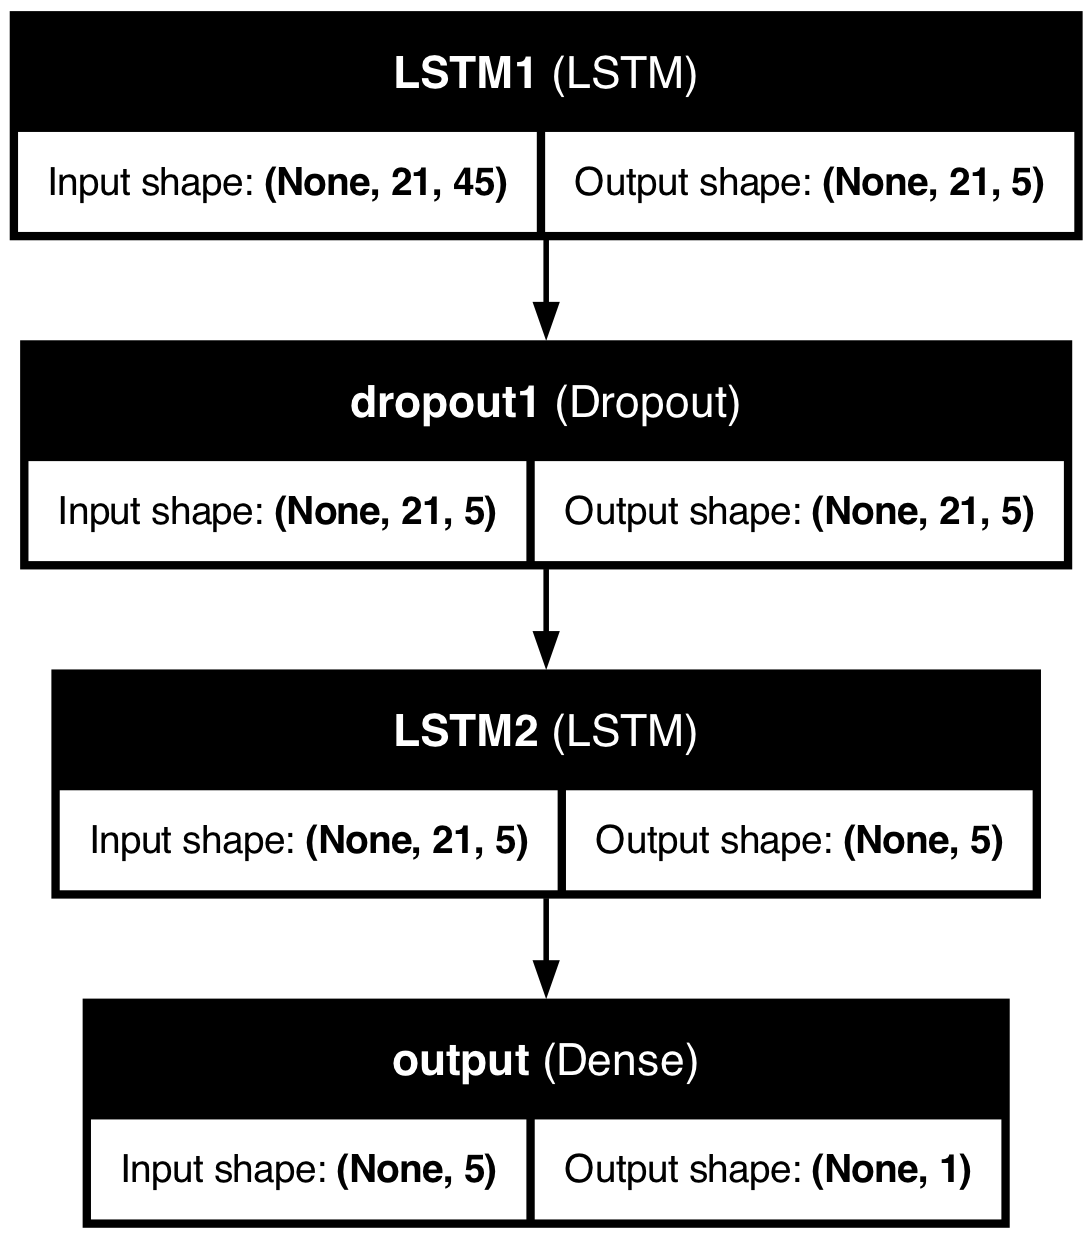

In [144]:
# Plot layers
plot_model(model_2layer_dropout, show_shapes=True, show_layer_names=True)

Training experience on TensorBoard.

In [145]:
%tensorboard --logdir ./tensorboard/2layer_dropout/20250728-120819

**Simple intepreatation on TensorBoard results (`TIME SERIES` tab):**
- In the `epoch_accuracy` plot, across all the hyperparameter trials, most showed increasing validation accuracy, and more trails had clear upward tendency than the baseline model. But the best-performing run achieved a validation accuracy of ~$0.66$, less than the baseline model. This shows adding dropout improves the chance of better performance, but may not necessarily push the upper limit of accuracy in our project.

- The `epoch_auc` plot shows that most model configurations gradually improved their validation AUC over training epochs. Similar to the accuracy plot, more trails in this model demonstrated enhancement over the epochs than the baseline model, yet the best AUC $0.72$ didn't exceed the baseline model's record. 

- The `epoch_loss` also illustrates 2 splits: half trails showed steadily decreasing loss values, indicating effective learning. Others exhibited oscillating loss curves. Compared to the baseline model where all the trails finished within around $30$ epochs, many trails here with decreasing loss took more epochs (~$60$) to reach early stopping. 

- Generally, this model with dropout requires more training epochs before meeting early stopping criteria based on loss reduction. While most trials outperformed those from the baseline model, the top-performing trial did not surpass the strongest baseline counterpart.

[**Back to Content**](#content)

<a id='4.3.2'></a>
### 4.3.2 Evaluate the model (2 layers with dropout)

<a id='4.3.2.1'></a>
#### 4.3.2.1 Evaluate the training data against the testing data

In [146]:
results = model_2layer_dropout.evaluate(g_train, verbose=0)
print(f"Training accuracy: {results[1]:.2f}")

/opt/anaconda3/envs/py310/lib/python3.10/site-packages/keras/src/legacy/preprocessing/sequence.py:120: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = np.array([self.targets[row] for row in rows])


Training accuracy: 0.58


In [147]:
results = model_2layer_dropout.evaluate(g_test, verbose=0)
print(f"Testing accuracy: {results[1]:.2f}")

Testing accuracy: 0.51


<a id='4.3.2.2'></a>
#### 4.3.2.2 Use the model to generate predictions on the testing data and conduct a more comprehensive performance analysis

In [148]:
# Predictions 
y_prob = model_2layer_dropout.predict(g_test)
y_pred = np.where(y_prob > 0.5, 1, 0)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step 


Visualize the test result.

AUC: 0.5144


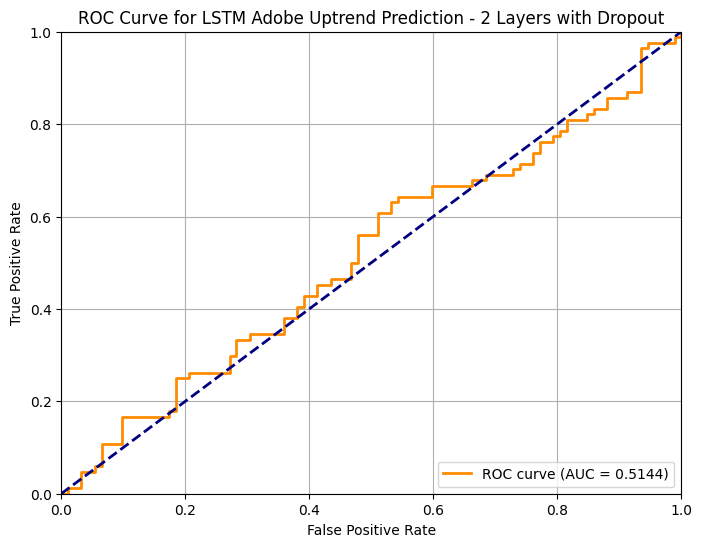

In [149]:
# Align labels with predictions
y_test_trimmed = y_test[seqlen:] 

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test_trimmed, y_prob)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc:.4f}")

# Plot ROC curve with grid and diagonal reference line
plt.figure(figsize=(8, 6))

# Plot ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',)

# Labels, grid, and legend
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LSTM Adobe Uptrend Prediction - 2 Layers with Dropout')
plt.legend(loc="lower right")
plt.grid(True)

plt.show()

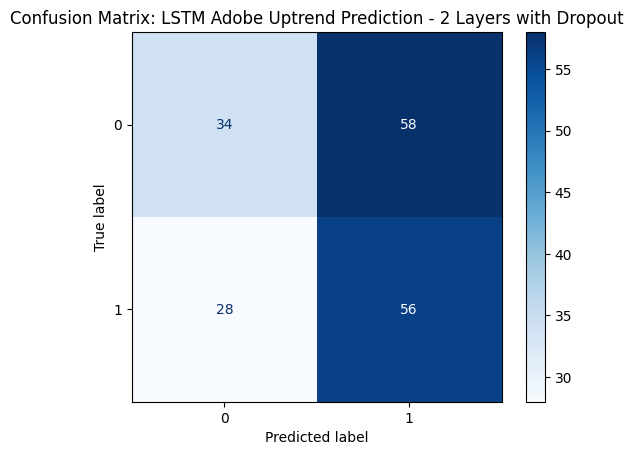

In [150]:
cm = confusion_matrix(y_test_trimmed, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix: LSTM Adobe Uptrend Prediction - 2 Layers with Dropout')
plt.grid(False)
plt.show()

In [151]:
print(classification_report(y_test_trimmed, y_pred, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.55      0.37      0.44        92
           1       0.49      0.67      0.57        84

    accuracy                           0.51       176
   macro avg       0.52      0.52      0.50       176
weighted avg       0.52      0.51      0.50       176



[**Back to Content**](#content)

<a id='4.3.2.3'></a>
#### 4.3.2.3 Model evaluation summary
**Training Metrics**
- Accuracy: $0.58$

**Testing Metrics**
- Accuracy: $0.51$

- Class 1 precision: $0.49$

- Class 1 recall: $0.67$

- Class 1 F1 score: $0.57$

- AUC: $0.51$

**Interpretation**
- Moderate learning without extreme overfitting: Training accuracy of $0.63$ suggests the model learned moderately and testing accuracy of $0.55$, indicates limited generalization with some room for performance gains.

- Aggressive positive detection: High recall for class 1 ($0.67$) paired with moderate precision ($0.49$) shows the model favors identifying positives, possibly at the cost of false alarms.

- Limited discriminative power: AUC of $0.51$ shows the model still deosn't perform too much better than random guess.

- While the signal capture is increased from the baseline model, it is somehow at the cost of class 1 precision. We will then explore how the additional layer can help improve the overal performance.


[**Back to Content**](#content)

<a id='4.4'></a>
## 4.4 Variant model B - 3 layer LSTM model without dropout

<a id='4.4.1'></a>
### 4.4.1 Build the model (3 layers without dropout)

First, create a HyperParameters class to build the model with hyperparameters for fine-tuning included.

In [152]:
def model_3layer_no_dropout(hp):
    
    tf.keras.backend.clear_session()   

    # Instantiate the model
    model = Sequential()
    
    # Tune the number of units in the layers
    hp_units1 = hp.Int('units1', min_value=5, max_value=25, step=5)
    hp_units2 = hp.Int('units2', min_value=5, max_value=25, step=5)
    hp_units3 = hp.Int('units3', min_value=5, max_value=25, step=5)

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[0.0005, 0.001, 0.002])

    # Tune activation functions
    hp_activation1 = hp.Choice(name = 'activation1', values = ['relu', 'elu'], ordered = False)
    hp_activation2 = hp.Choice(name = 'activation2', values = ['relu', 'elu'], ordered = False)
    hp_activation3 = hp.Choice(name = 'activation3', values = ['relu', 'elu'], ordered = False)
    
    # Build the model
    model.add(LSTM(hp_units1, input_shape=(seqlen, numfeat), activation=hp_activation1, return_sequences=True, name='LSTM1'))   
    
    model.add(LSTM(hp_units2, activation = hp_activation2, return_sequences=True, name='LSTM2'))

    model.add(LSTM(hp_units3, activation = hp_activation3, return_sequences=False, name='LSTM3'))
    
    model.add(Dense(units=1, activation='sigmoid', name='output'))    

    # Specify optimizer separately (preferred method))
    opt = Adam(learning_rate=hp_learning_rate, epsilon=1e-08)       
    
    # Model compilation
    model.compile(optimizer=opt, loss=BinaryCrossentropy(), metrics=['accuracy', Precision(), Recall(), AUC(name='auc')])

    return model

In [153]:
# Initialize an early stopping callback
logdir_3layer_no_dropout = os.path.join("./tensorboard/3layer_no_dropout", dt.datetime.now().strftime("%Y%m%d-%H%M%S"))

callbacks_3layer_no_dropout = [
    EarlyStopping(patience=20, monitor='val_loss', mode='min', verbose=1, restore_best_weights=True),
    TensorBoard(log_dir=logdir_3layer_no_dropout, histogram_freq=1)
]

Set up Bayesian Optimization

In [154]:
# BayesianOptimization algorithm from keras tuner
botuner_3layer_no_dropout = BayesianOptimization(
    model_3layer_no_dropout,
    objective="val_accuracy",
    max_trials=20,
    num_initial_points=6,
    overwrite=True,
    directory="./parameter_optimization",
    project_name="3layer_no_dropout",
)

/opt/anaconda3/envs/py310/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Run the training and tuning process and get the best model and parameters from the optimization. 

As the result is not deterministic, activate below code only when you need to rerun and generate a new model with tuned hyperparameters.

In [274]:
# # Launch tuning process
# botuner_3layer_no_dropout.search(g_train, epochs=200, validation_data=g_val, callbacks=callbacks_3layer_no_dropout, shuffle=False)

# # Obtain the best model and parameters
# model_3layer_no_dropout = botuner_3layer_no_dropout.get_best_models(num_models=1)[0]
# param_3layer_no_dropout = botuner_3layer_no_dropout.get_best_hyperparameters()[0]

Trial 20 Complete [00h 00m 16s]
val_accuracy: 0.5714285969734192

Best val_accuracy So Far: 0.6285714507102966
Total elapsed time: 00h 05m 56s


Save and reload the model. This is to maintain consistent evaluation against the testing dataset. The saved model represents the best-performing version out of three runs conducted on 28 July 2025.

In [244]:
# # Save the model and the parameters.
# model_3layer_no_dropout.save('./models&params/model_3layer_no_dropout.keras')
# with open("./models&params/param_3layer_no_dropout.json", "w") as f:
#     json.dump(param_3layer_no_dropout.values, f)

In [155]:
# # Reload the model.
model_3layer_no_dropout = load_model("./models&params/model_3layer_no_dropout.keras")

/opt/anaconda3/envs/py310/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 24 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Visualize the model structure.

In [156]:
# Summary
model_3layer_no_dropout.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM1 (LSTM)                    │ (None, 21, 15)         │         3,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM2 (LSTM)                    │ (None, 21, 25)         │         4,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM3 (LSTM)                    │ (None, 5)              │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,160 (98.29 KB)

 Trainable params: 8,386 (32.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,774 (65.53 KB)

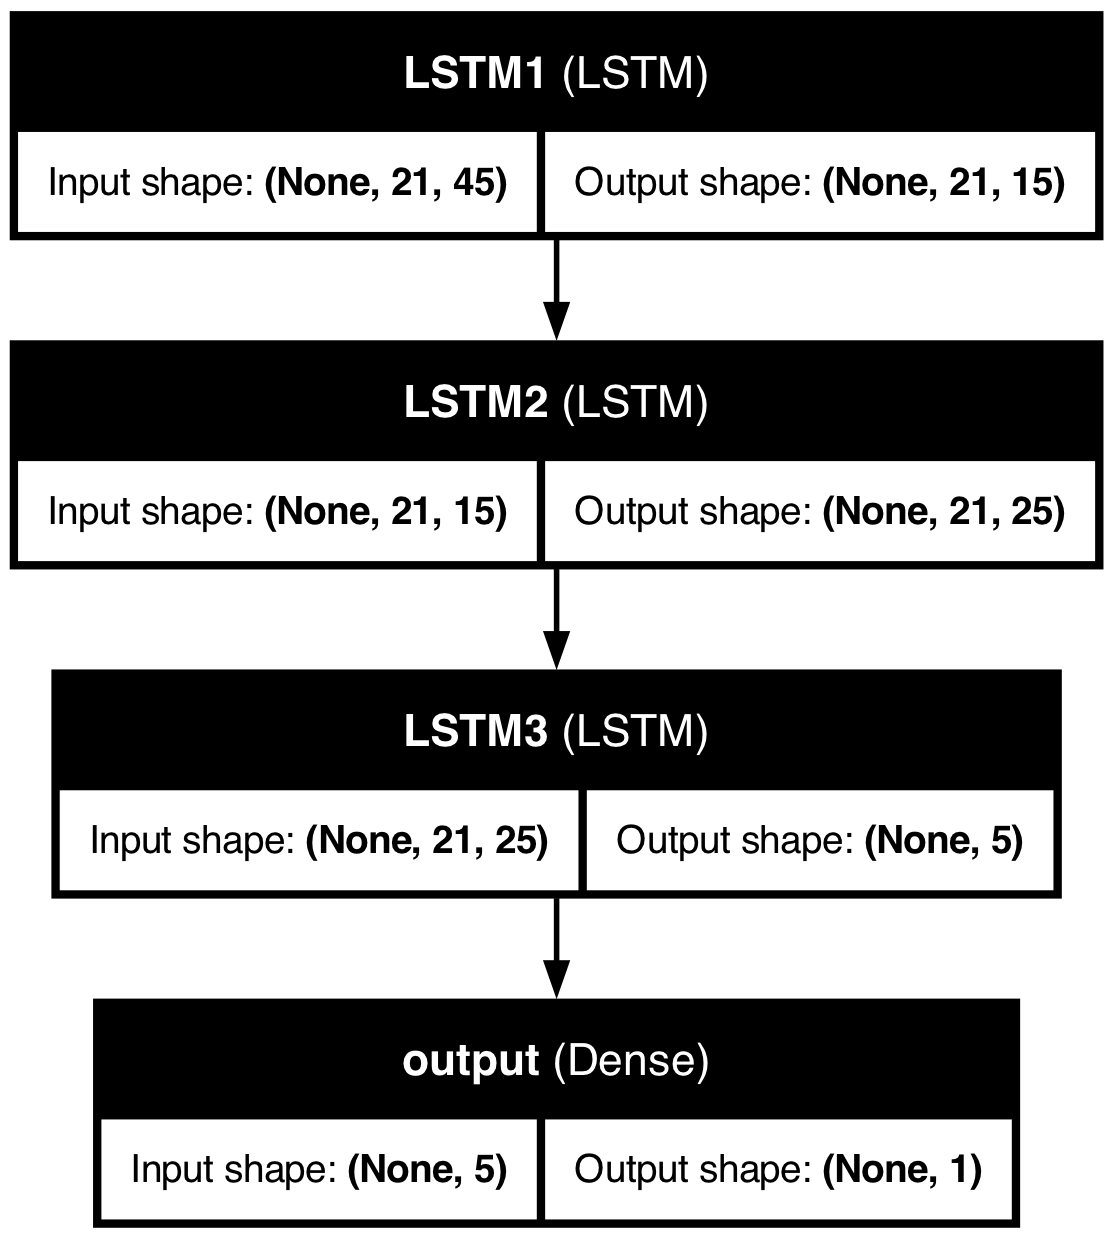

In [157]:
# Plot layers
plot_model(model_3layer_no_dropout, show_shapes=True, show_layer_names=True)

Training experience on TensorBoard.

In [158]:
%tensorboard --logdir ./tensorboard/3layer_no_dropout/20250728-125638

**Simple intepreatation on TensorBoard results (`TIME SERIES` tab):**
- In the `epoch_accuracy` plot, across all the hyperparameter trials, most of them showed increasing validation accuracy, demonstrating similar patterns as the baseline model except taking more epochs. The best-performing run also achieved a validation accuracy of ~$0.68$, similar to the best result from the baseline model as well.

- The `epoch_auc` plot shows that most model configurations gradually improved their validation AUC over training epochs. Although the AUCs of some trials started around or below $0.5$ (random guessing), the best trail deliverd AUC ~$0.75$, very close to that from the baseline model.

- The `epoch_loss` plot also demonstrates high level similarity to its baseline model counterpart. Among all the trials, approximately half showed steadily decreasing loss values, indicating effective learning. Other trials exhibited oscillating loss curves, suggesting less effective hyperparameter settings.

- Overall, compared to the baseline model, adding an extra layer to this model had limited impact on the training experience. The only notable change was that the trails required more epochs to reach early stopping.

[**Back to Content**](#content)

<a id='4.4.2'></a>
### 4.4.2 Evaluate the model (3 layers without dropout)

<a id='4.4.2.1'></a>
#### 4.4.2.1 Evaluate the training data against the testing data

In [159]:
results = model_3layer_no_dropout.evaluate(g_train, verbose=0)
print(f"Training accuracy: {results[1]:.2f}")

/opt/anaconda3/envs/py310/lib/python3.10/site-packages/keras/src/legacy/preprocessing/sequence.py:120: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = np.array([self.targets[row] for row in rows])


Training accuracy: 0.60


In [160]:
results = model_3layer_no_dropout.evaluate(g_test, verbose=0)
print(f"Testing accuracy: {results[1]:.2f}")

Testing accuracy: 0.52


<a id='4.4.2.2'></a>
#### 4.4.2.2 Use the model to generate predictions on the testing data and conduct a more comprehensive performance analysis

In [161]:
# Predictions 
y_prob = model_3layer_no_dropout.predict(g_test)
y_pred = np.where(y_prob > 0.5, 1, 0)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step 


Visualize the test result.

AUC: 0.5160


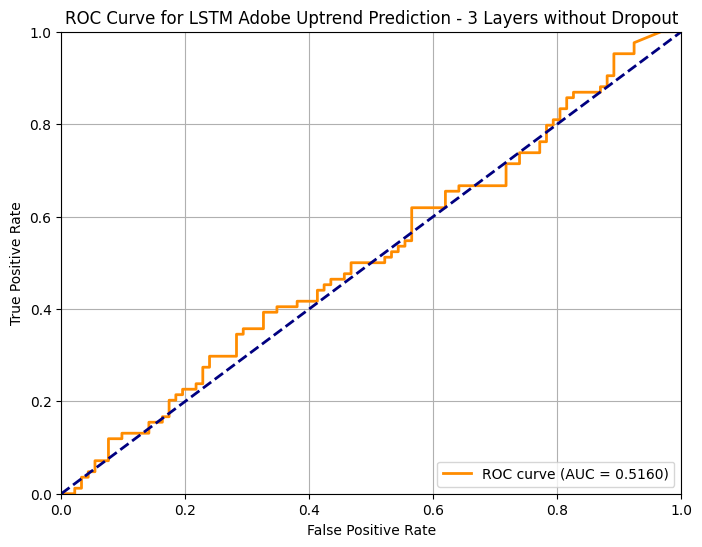

In [162]:
# Align labels with predictions
y_test_trimmed = y_test[seqlen:] 

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test_trimmed, y_prob)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc:.4f}")

# Plot ROC curve with grid and diagonal reference line
plt.figure(figsize=(8, 6))

# Plot ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',)

# Labels, grid, and legend
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LSTM Adobe Uptrend Prediction - 3 Layers without Dropout')
plt.legend(loc="lower right")
plt.grid(True)

plt.show()

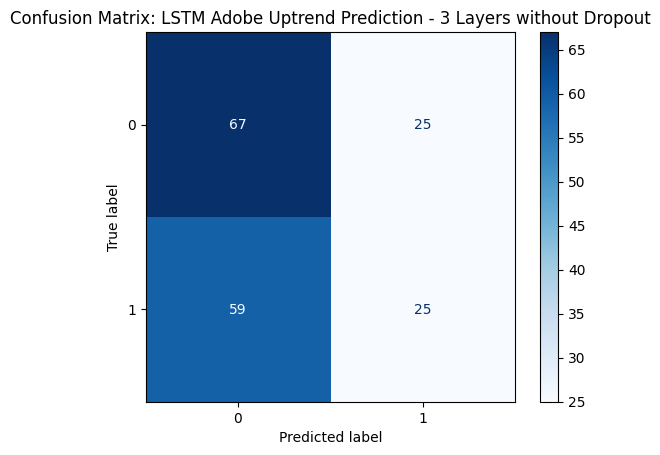

In [163]:
cm = confusion_matrix(y_test_trimmed, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix: LSTM Adobe Uptrend Prediction - 3 Layers without Dropout')
plt.grid(False)
plt.show()

In [164]:
print(classification_report(y_test_trimmed, y_pred, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.53      0.73      0.61        92
           1       0.50      0.30      0.37        84

    accuracy                           0.52       176
   macro avg       0.52      0.51      0.49       176
weighted avg       0.52      0.52      0.50       176



[**Back to Content**](#content)

<a id='4.4.2.3'></a>
#### 4.4.2.3 Baseline model evaluation summary
**Training Metrics**
- Accuracy: $0.60$

**Testing Metrics**
- Accuracy: $0.52$

- Class 1 precision: $0.50$

- Class 1 recall: $0.30$

- Class 1 F1 score: $0.37$

- AUC: $0.52$

**Interpretation**
- Moderate learning without extreme overfitting: Training accuracy of $0.60$ suggests the model learned moderately and testing accuracy of $0.52$, indicates limited predictive power.

- Conservative class 1 prediction: moderate precision ($0.50$) with low recall ($0.30$) suggests the model predicts positives cautiously, missing many true positives.

- Limited discriminative power: AUC of $0.52$ indicates the model’s ability to distinguish between classes still remains close to chance level.

- Adding another layer doesn't improve the performance of the model. Even 2 layer model with dropout can demonstrate slighly more value.


[**Back to Content**](#content)

<a id='4.5'></a>
## 4.5 Variant model C - 3 layer LSTM model with dropout

<a id='4.5.1'></a>
### 4.5.1 Build the model (3 layers with dropout)

First, create a HyperParameters class to build the model with hyperparameters for fine-tuning included.

In [165]:
def model_3layer_dropout(hp):
    
    tf.keras.backend.clear_session()   

    # Instantiate the model
    model = Sequential()
    
    # Tune the number of units in the layers
    hp_units1 = hp.Int('units1', min_value=5, max_value=25, step=5)
    hp_units2 = hp.Int('units2', min_value=5, max_value=25, step=5)
    hp_units3 = hp.Int('units3', min_value=5, max_value=25, step=5)

    # Tune the dropout rate
    hp_dropout1 = hp.Float('dropout1', min_value=0.3, max_value=0.6, step=0.1)
    hp_dropout2 = hp.Float('dropout2', min_value=0.3, max_value=0.6, step=0.1)
    
    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[0.0005, 0.001, 0.002])

    # Tune activation functions
    hp_activation1 = hp.Choice(name = 'activation1', values = ['relu', 'elu'], ordered = False)
    hp_activation2 = hp.Choice(name = 'activation2', values = ['relu', 'elu'], ordered = False)
    hp_activation3 = hp.Choice(name = 'activation3', values = ['relu', 'elu'], ordered = False)
    
    # Build the model
    model.add(LSTM(hp_units1, input_shape=(seqlen, numfeat), activation=hp_activation1, return_sequences=True, name='LSTM1'))
    model.add(Dropout(hp_dropout1, name='dropout1'))

    model.add(LSTM(hp_units2, activation = hp_activation2, return_sequences=True, name='LSTM2'))
    model.add(Dropout(hp_dropout2, name='dropout2'))

    model.add(LSTM(hp_units3, activation = hp_activation3, return_sequences=False, name='LSTM3'))
    
    model.add(Dense(units=1, activation='sigmoid', name='output'))    

    # Specify optimizer separately (preferred method))
    opt = Adam(learning_rate=hp_learning_rate, epsilon=1e-08)       
    
    # Model compilation
    model.compile(optimizer=opt, loss=BinaryCrossentropy(), metrics=['accuracy', Precision(), Recall(), AUC(name='auc')])

    return model

In [166]:
# Initialize an early stopping callback
logdir_3layer_dropout = os.path.join("./tensorboard/3layer_dropout", dt.datetime.now().strftime("%Y%m%d-%H%M%S"))

callbacks_3layer_dropout = [
    EarlyStopping(patience=20, monitor='val_loss', mode='min', verbose=1, restore_best_weights=True),
    TensorBoard(log_dir=logdir_3layer_dropout, histogram_freq=1)
]

Set up Bayesian Optimization

In [167]:
# BayesianOptimization algorithm from keras tuner
botuner_3layer_dropout = BayesianOptimization(
    model_3layer_dropout,
    objective="val_accuracy",
    max_trials=20,
    num_initial_points=6,
    overwrite=True,
    directory="./parameter_optimization",
    project_name="3layer_dropout",
)

/opt/anaconda3/envs/py310/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Run the training and tuning process and get the best model and parameters from the optimization. 

As the result is not deterministic, activate below code only when you need to rerun and generate a new model with tuned hyperparameters.

In [357]:
# # Launch tuning process
# botuner_3layer_dropout.search(g_train, epochs=200, validation_data=g_val, callbacks=callbacks_3layer_dropout, shuffle=False)

# # Obtain the best model and parameters
# model_3layer_dropout = botuner_3layer_dropout.get_best_models(num_models=1)[0]
# param_3layer_dropout = botuner_3layer_dropout.get_best_hyperparameters()[0]

Trial 20 Complete [00h 00m 26s]
val_accuracy: 0.5485714077949524

Best val_accuracy So Far: 0.6171428561210632
Total elapsed time: 00h 08m 54s


Save and reload the model. This is to maintain consistent evaluation against the testing dataset. The saved model represents the best-performing version out of three runs conducted on 28 July 2025.

In [370]:
# # Save the model and the parameters.
# model_3layer_dropout.save('./models&params/model_3layer_dropout.keras')
# with open("./models&params/param_3layer_dropout.json", "w") as f:
#     json.dump(param_3layer_dropout.values, f)

In [168]:
# # Reload the model.
model_3layer_dropout = load_model("./models&params/model_3layer_dropout.keras")

/opt/anaconda3/envs/py310/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 24 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Visualize the model structure.

In [169]:
# Summary
model_3layer_dropout.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM1 (LSTM)                    │ (None, 21, 15)         │         3,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 21, 15)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM2 (LSTM)                    │ (None, 21, 10)         │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 21, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM3 (LSTM)                    │ (None, 15)             │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,830 (73.56 KB)

 Trainable params: 6,276 (24.52 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,554 (49.04 KB)

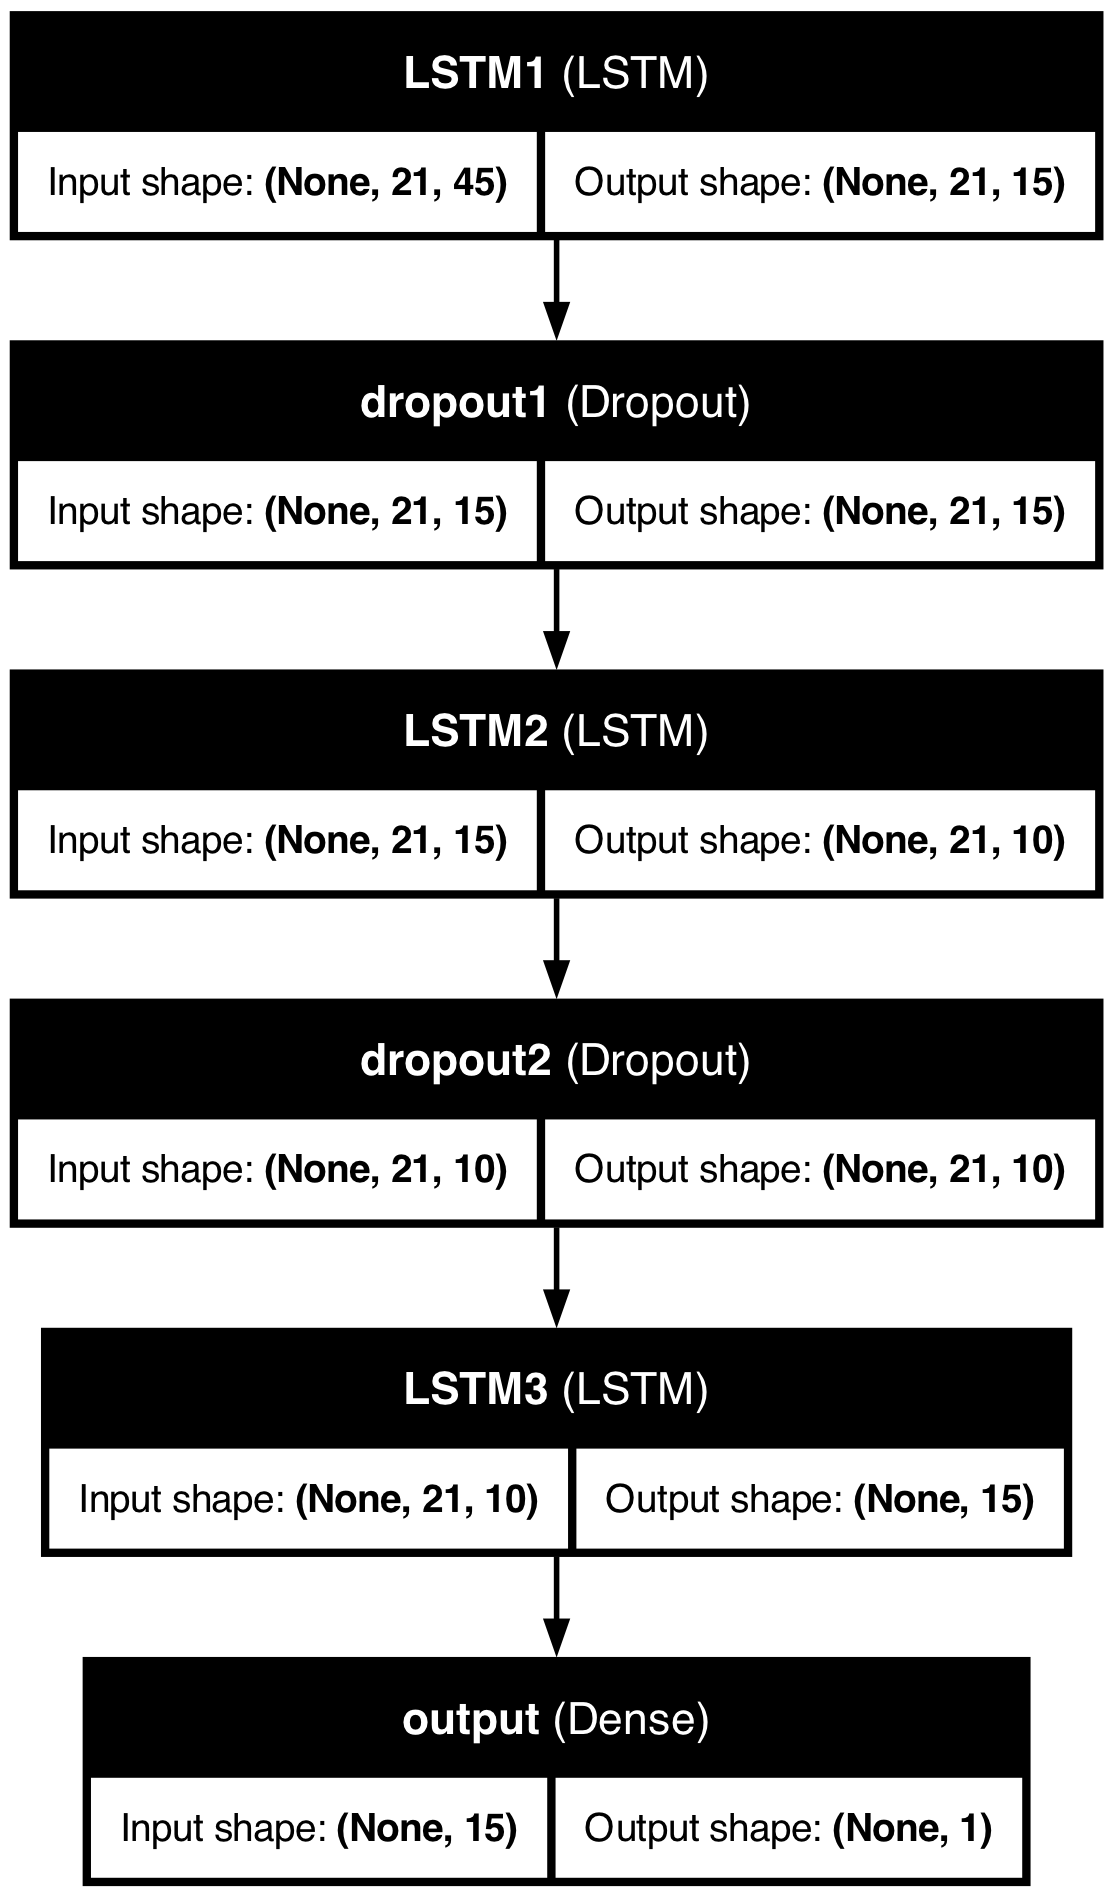

In [170]:
# Plot layers
plot_model(model_3layer_dropout, show_shapes=True, show_layer_names=True)

Training experience on TensorBoard.

In [171]:
%tensorboard --logdir ./tensorboard/3layer_dropout/20250728-153046

**Simple intepreatation on TensorBoard results (`TIME SERIES` tab):**
- In the `epoch_accuracy` plot, across all the hyperparameter trials, most of them showed increasing validation accuracy. Yet the starting accuracy was quite low from all trails, and the best accuracy $0.64$ was the worst among all the models.

- The `epoch_auc` plot shows that most model configurations gradually improve their validation AUC over training epochs. Although the AUC improvement demonstrated similar trends compared to other models, the best value $0.71$ was still the lowest.

- The `epoch_loss` panel also reveals two distinct patterns: roughly half of the trials show consistently decreasing loss, suggesting effective learning, while the others display oscillating or upward-trending loss curves — an undesirable behavior not observed in other models. The lowest recorded loss was $0.62$, the worst among all the models again. Most trials reached early stopping near epoch 47, with only two outliers extending to epoch 62.

- With the extra layer and dropout, this model even delivered worse results with more epochs during the training, suggesting that for this project, additional neurons and regularization may not be a good combination to improve performance. 

[**Back to Content**](#content)

<a id='4.5.2'></a>
### 4.5.2 Evaluate the model (3 layers with dropout)

<a id='4.5.2.1'></a>
#### 4.5.2.1 Evalute the training data against the testing data

In [172]:
results = model_3layer_dropout.evaluate(g_train, verbose=0)
print(f"Training accuracy: {results[1]:.2f}")

/opt/anaconda3/envs/py310/lib/python3.10/site-packages/keras/src/legacy/preprocessing/sequence.py:120: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = np.array([self.targets[row] for row in rows])


Training accuracy: 0.53


In [173]:
results = model_3layer_dropout.evaluate(g_test, verbose=0)
print(f"Testing accuracy: {results[1]:.2f}")

Testing accuracy: 0.53


<a id='4.5.2.2'></a>
#### 4.5.2.2 Use the model to generate predictions on the testing data and conduct a more comprehensive performance analysis

In [174]:
# Predictions 
y_prob = model_3layer_dropout.predict(g_test)
y_pred = np.where(y_prob > 0.5, 1, 0)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step 


Visualize the test result.

AUC: 0.5489


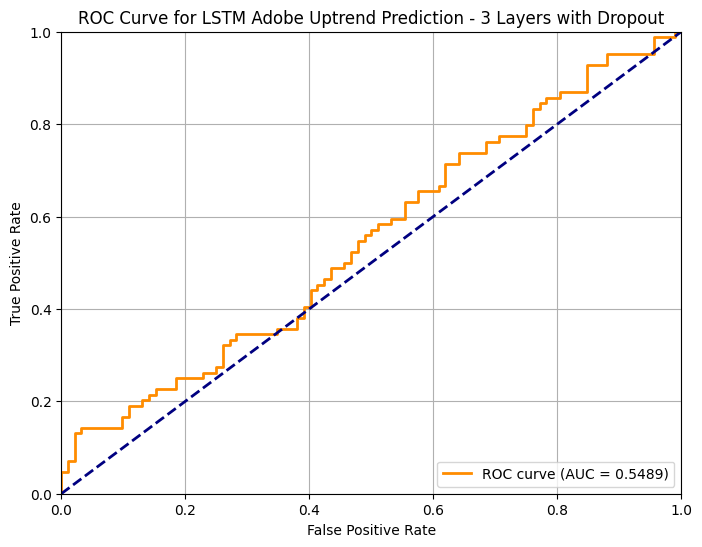

In [175]:
# Align labels with predictions
y_test_trimmed = y_test[seqlen:] 

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test_trimmed, y_prob)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc:.4f}")

# Plot ROC curve with grid and diagonal reference line
plt.figure(figsize=(8, 6))

# Plot ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',)

# Labels, grid, and legend
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LSTM Adobe Uptrend Prediction - 3 Layers with Dropout')
plt.legend(loc="lower right")
plt.grid(True)

plt.show()

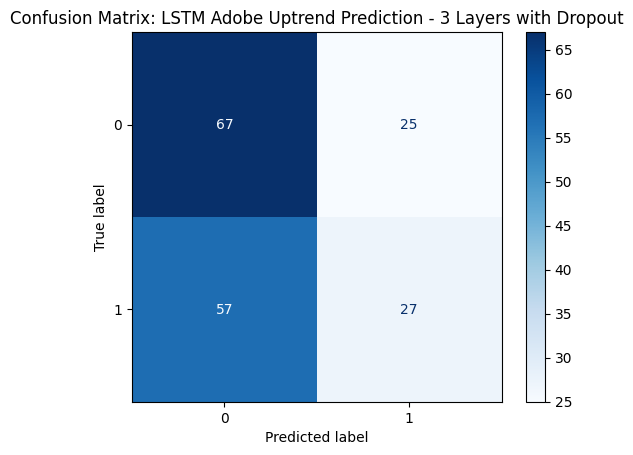

In [176]:
cm = confusion_matrix(y_test_trimmed, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix: LSTM Adobe Uptrend Prediction - 3 Layers with Dropout')
plt.grid(False)
plt.show()

In [177]:
print(classification_report(y_test_trimmed, y_pred, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.54      0.73      0.62        92
           1       0.52      0.32      0.40        84

    accuracy                           0.53       176
   macro avg       0.53      0.52      0.51       176
weighted avg       0.53      0.53      0.51       176



[**Back to Content**](#content)

<a id='4.5.2.3'></a>
#### 4.5.2.3 Model evaluation summary
**Training Metrics**
- Accuracy: $0.53$

**Testing Metrics**
- Accuracy: $0.53$

- Class 1 precision: $0.52$

- Class 1 recall: $0.32$

- Class 1 F1 score: $0.40$

- AUC: $0.55$

**Interpretation**
- Moderate learning with consistency: Training and testing accuracy tie at $0.53$, indicating zero overfitting. But the drop of training accuracy suggests the model doesn't learn as much as previous ones.

- Moderate precision, low recall for class 1: The model predicts positives fairly accurately (precision: $0.52$ but misses many actual positives (recall: $0.32$), pulling the F1 score to $0.40$.

- Limited discriminative power: AUC of $0.55$ shows improvement on distinguishing between classes but still underwhelming.

- While dropout helps reduce overfitting and enhances discriminative power, the overall accuracy shows no improvement, making it difficult to consider this model the best.


[**Back to Content**](#content)

<a id='4.6'></a>
## 4.6 Review of all the models

Let's collect all the performance data and put them together in a dataframe for a clear comparision.

In [178]:
# Define the data
model_performance_data = {
    "2 layers without dropout (baseline model)": {
        "training accuracy": 0.63,
        "testing accuracy": 0.55,
        "train/test accuracy gap": 0.08,
        "AUC": 0.52,
        "class 1 precision": 0.54,
        "class 1 recall": 0.39,
        "class 1 F1 score": 0.46,
    },
    "2 layers with dropout (variant model A)": {
        "training accuracy": 0.58,
        "testing accuracy": 0.51,
        "train/test accuracy gap": 0.07,
        "AUC": 0.51,
        "class 1 precision": 0.49,
        "class 1 recall": 0.67,
        "class 1 F1 score": 0.57,
    },
    "3 layers without dropout (variant model B)": {
        "training accuracy": 0.60,
        "testing accuracy": 0.52,
        "train/test accuracy gap": 0.08,
        "AUC": 0.52,
        "class 1 precision": 0.50,
        "class 1 recall": 0.30,
        "class 1 F1 score": 0.37,
    },
    "3 layers with dropout (variant model C)": {
        "training accuracy": 0.53,
        "testing accuracy": 0.53,
        "train/test accuracy gap": 0,
        "AUC": 0.55,
        "class 1 precision": 0.52,
        "class 1 recall": 0.32,
        "class 1 F1 score": 0.40,
    }
}

# Create the DataFrame
df_model_performance = pd.DataFrame.from_dict(model_performance_data, orient='index')

In [179]:
df_model_performance

training accuracy  \
2 layers without dropout (baseline model)               0.630   
2 layers with dropout (variant model A)                 0.580   
3 layers without dropout (variant model B)              0.600   
3 layers with dropout (variant model C)                 0.530   

                                            testing accuracy  \
2 layers without dropout (baseline model)              0.550   
2 layers with dropout (variant model A)                0.510   
3 layers without dropout (variant model B)             0.520   
3 layers with dropout (variant model C)                0.530   

                                            train/test accuracy gap   AUC  \
2 layers without dropout (baseline model)                     0.080 0.520   
2 layers with dropout (variant model A)                       0.070 0.510   
3 layers without dropout (variant model B)                    0.080 0.520   
3 layers with dropout (variant model C)                       0.000 0.550   

                                            class 1 precision  class 1 recall  \
2 layers without dropout (baseline model)               0.540           0.390   
2 layers with dropout (variant model A)                 0.490           0.670   
3 layers without dropout (variant model B)              0.500           0.300   
3 layers with dropout (variant model C)                 0.520           0.320   

                                            class 1 F1 score  
2 layers without dropout (baseline model)              0.460  
2 layers with dropout (variant model A)                0.570  
3 layers without dropout (variant model B)             0.370  
3 layers with dropout (variant model C)                0.400

- **Baseline model (2 layers without dropout)** has the highest training ($0.63$), testing accuracy ($0.55$) and precision ($0.54$), but suffers from overfitting (train/test gap: $0.08$) and low recall ($0.39$) on class 1 (uptrend).

- **Variant model A (2 layers with dropout)** shows better class 1 recall ($0.67$) and highest class 1 F1 score ($0.57$), indicating stronger detection of uptrends, despite modest accuracy and AUC. Its slight drop in accuracy is an acceptable trade-off for its predictive strength on the target class. It is the only model with a higher recall than precision, demonstrating the most aggresive predicting style among the 4 models.

- **Variant model B (3 layers without dropout)** offers no significant accuracy or AUC improvement and has the lowest class 1 recall ($0.30$) and F1 score ($0.37$), suggesting it's less effective at identifying uptrends. Its train/test accuracy gap and AUC are the same as those of the baseline model, while precision and recall follow a similar pattern as well. It can be seen as a resembling but weaker version of the baseline model.

- **Variant model C (3 layers with dropout)** achieves the lowest overfitting ($0.00$ gap) and highest AUC ($0.55$), indicating balanced generalization from dropout and better discriminative power possible contributed by the additional layer. But its recall ($0.32$) and F1 ($0.40$) remain low, indicating weak capability to catch upward movements. Its complexity didn't translate to substantially better classification metrics.

- **Dropout generally improves generalization**: Comparing both pairs (2-layer vs. 2-layer with dropout and 3-layer vs. 3-layer with dropout), dropout reduced overfitting and improved recall for detecting uptrends. 

- **Adding a third LSTM layer doesn't yield clear benefits**: Increasing depth from 2 to 3 layers did not improve accuracy, AUC, or class 1 performance. In fact, the 3-layer models (with or without dropout) showed lower F1 scores ($0.37–0.40$) and poorer recall than the 2-layer with dropout model.


### Recommended Model for Backtesting: Baseline model (2 layers without dropout)
Adding an extra layer negatively impacted model performance, so neither Variant Model B nor C will be considered the best candidate.

**Then, I conducted backtesting for both baseline model and variant model A, and the baseline model showed slightly better performance.** 

This is because Variant A achieved a relatively high F1 score ($0.57$), driven by strong recall ($0.67$) but limited precision ($0.49$), reflecting an aggressive prediction style that led to more false alarms. Given the high volatility and frequent downturns in Adobe’s share price between 2020 and 2025, these false alarms would introduce significant negative returns that offset the gains from correct predictions.

As a result, a more conservative strategy is better suited for backtesting such a volatile asset. **The baseline model, with its higher precision and accuracy, is the preferred choice for final deployment.**

[**Back to Content**](#content)

<a id='5'></a>
# 5. Trading strategy with backtesting

In this chapter, we encapsulate the baseline model (2-layer without dropout) as a trading strategy to assess its performance. 

Specifically, we reapply the model to the full Adobe dataset from 2020 to 2025 and evaluate its results using a range of analytical techniques.

In [180]:
# Prepare the features of the full dataset, we directly use the globally scaled features X_scaled as the independent variables.
g_all = TimeseriesGenerator(X_scaled, y, length=seqlen, batch_size=32)

In [181]:
# Use the model to predict
y_prob_all = model_2layer_no_dropout.predict(g_all, verbose=False)
y_pred_all = np.where(y_prob_all> 0.5, 1, 0)

/opt/anaconda3/envs/py310/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/opt/anaconda3/envs/py310/lib/python3.10/site-packages/keras/src/legacy/preprocessing/sequence.py:120: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = np.array([self.targets[row] for row in rows])


In [182]:
# Check the result
y_pred_all

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [1]])

[**Back to Content**](#content)

<a id = "5.1"></a>
## 5.1 Profit analysis ##
To assess the effectiveness of the baseline model, we will conduct a simple backtesting trading exercise with the 5-year Adobe price data. The trading rules are straightforward:
- **Buy Signal (Predicted = 1):** Purchase one share of Adobe at the day's closing price.

- **Sell on the Next Day:** If a purchase occurs, the position will be sold at the next day's closing price.

- **No Trade (Predicted = 0):** No transaction is executed on this day related to this predicition.

- **No Transaction Costs or Friction Included:** This backtest assumes a cost-free trading environment for simplicity.

Trades following these rules will be referred to as the **LSTM Strategy** in the subsequent analysis.

Create a new dataframe 'df_strategy', only include `close`, `return`, and and the just-now generated `model prediction`.

In [183]:
# Create the new dataframe but without the first 21 days as they are missing in the LSTM predictions from the baseline model.
df_strategy = df[['close', 'return']][seqlen:]

# Include the baseline model prediction as the buy signals in the columns of 'LSTM prediction'.
df_strategy['LSTM prediction'] = y_pred_all.astype(int) 

To accurately track daily trading activities under the model strategy over the past 5 years, create the following columns:
- `LSTM buy price`: Records the amount spent to purchase one share of Adobe based on the LSTM strategy on a given day, if any.

- `LSTM sell price`: Captures the amount received from selling the share bought on the previous day, if any.

- `LSTM profit`: Computes the net earnings from each trade by subtracting the previous day's buy price from the current day's sell price, representing the money made from this round of transaction.

In [184]:
# Create buy price column → Price when 'Predicted' is 1, otherwise 0
df_strategy['LSTM buy price'] = df_strategy['close'] * df_strategy['LSTM prediction']

# Create Sell Price column → Price when 'Predicted' was 1 in the previous row
df_strategy['LSTM sell price'] = df_strategy['close'] * df_strategy['LSTM prediction'].shift(1).fillna(0)

df_strategy['LSTM profit'] = df_strategy['LSTM sell price'] - df_strategy['LSTM buy price'].shift(1)
df_strategy['LSTM profit'] = df_strategy['LSTM profit'].fillna(0)  # Ensure NaN values are set to 0

Meanwhile, to evaluate the strategy’s performance, introduce two additional columns:
- `LSTM cumulative profit`: Tracks the total accumulated profit from all executed trades based on the LSTM strategy, providing insight into the strategy’s overall profitability.

- `buy hold profit`: Represents the profit generated without any trading strategy from a simple buy-and-hold approach. This serves as a benchmark to assess how the model strategy compares to a passive investment approach.

In [185]:
df_strategy['LSTM cumulative profit'] = df_strategy['LSTM profit'].cumsum()
df_strategy['buy hold profit'] = df_strategy['close'].diff().fillna(0).cumsum()

In [186]:
df_strategy.tail()

close  return  LSTM prediction  LSTM buy price  LSTM sell price  \
date                                                                           
2025-06-25 387.550   0.014                0           0.000            0.000   
2025-06-26 384.950  -0.007                0           0.000            0.000   
2025-06-27 385.830   0.002                0           0.000            0.000   
2025-06-30 386.880   0.003                0           0.000            0.000   
2025-07-01 392.100   0.013                1         392.100            0.000   

            LSTM profit  LSTM cumulative profit  buy hold profit  
date                                                              
2025-06-25        0.000                1153.520           32.160  
2025-06-26        0.000                1153.520           29.560  
2025-06-27        0.000                1153.520           30.440  
2025-06-30        0.000                1153.520           31.490  
2025-07-01        0.000                1153.520           36.710

In [187]:
print(f"Final LSTM Strategy Profit per Share: ${df_strategy['LSTM cumulative profit'].iloc[-1]:.2f}")
print(f"Final Buy & Hold Profit per Share: ${df_strategy['buy hold profit'].iloc[-1]:.2f}")

Final LSTM Strategy Profit per Share: $1153.52
Final Buy & Hold Profit per Share: $36.71


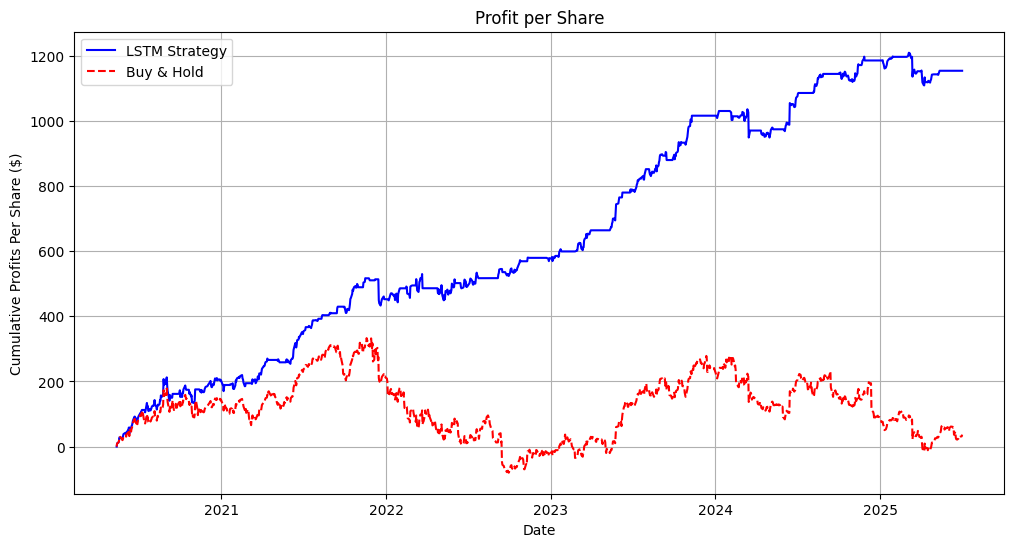

In [188]:
# Plot Strategy Performance
plt.figure(figsize=(12, 6))
plt.plot(df_strategy.index, df_strategy["LSTM cumulative profit"], label="LSTM Strategy", color="blue")
plt.plot(df_strategy.index, df_strategy["buy hold profit"], label="Buy & Hold", color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Cumulative Profits Per Share ($)")
plt.title("Profit per Share")
plt.grid(True)
plt.legend()
plt.show()

Observations from the profit analysis:
- LSTM strategy generated $\$1153.52$ per share, while buy-and-hold yielded only $\$36.71$ — a 30x profit improvement.

- Adobe stock was highly volatile with limited overall growth during the 5 years, leading to frequent losses for buy-and-hold investors.

- LSTM strategy delivered smoother, more consistent gains with much lower exposure to volatility.

- Major market drawdowns (e.g., 2022, early 2024, early 2025) had limited impact on LSTM, showing the model's strong downside protection.

Overall, the LSTM strategy not only vastly outperformed the buy-and-hold approach in absolute profit, but also provided a more stable and resilient path through a volatile market environment. Its ability to sidestep downturns while maintaining consistent growth highlights its strength as an active trading strategy.

[**Back to Content**](#content)

<a id='5.2'></a>
## 5.2 Rolling Sharpe ratio analysis
The Sharpe ratio measures return relative to risk:

$$\text{Sharpe Ratio}=\frac{\text{Mean Return}}{\text{Standard Deviation of Return}}$$
A rolling Sharpe ratio calculates this over a moving time window (e.g. 126 trading days ≈ 6 months), so we can see how a strategy’s risk-adjusted performance evolves. It highlights the model’s consistency, stability, and adaptability across different market conditions.

In this analysis, we compute the 126-day rolling Sharpe ratio for both the LSTM-based strategy and the buy-and-hold benchmark over the past 5 years, and compare their trajectories to assess relative performance.

Create the column of `LSTM return` to represent the daily return of the LSTM strategy.

In [189]:
# LSTM turn is basically the daily return of Adobe stock when there is a buy signal from the LSTM strategy in the previous day.
df_strategy['LSTM return'] =  df_strategy['return'] * df_strategy['LSTM prediction'].shift(1).fillna(0)
df_strategy.tail()

close  return  LSTM prediction  LSTM buy price  LSTM sell price  \
date                                                                           
2025-06-25 387.550   0.014                0           0.000            0.000   
2025-06-26 384.950  -0.007                0           0.000            0.000   
2025-06-27 385.830   0.002                0           0.000            0.000   
2025-06-30 386.880   0.003                0           0.000            0.000   
2025-07-01 392.100   0.013                1         392.100            0.000   

            LSTM profit  LSTM cumulative profit  buy hold profit  LSTM return  
date                                                                           
2025-06-25        0.000                1153.520           32.160        0.000  
2025-06-26        0.000                1153.520           29.560       -0.000  
2025-06-27        0.000                1153.520           30.440        0.000  
2025-06-30        0.000                1153.520           31.490        0.000  
2025-07-01        0.000                1153.520           36.710        0.000

Calculate the rolling Sharpe ratios for both the LSTM strategy and the buy-and-hold strategy, then visualize their trajectories.

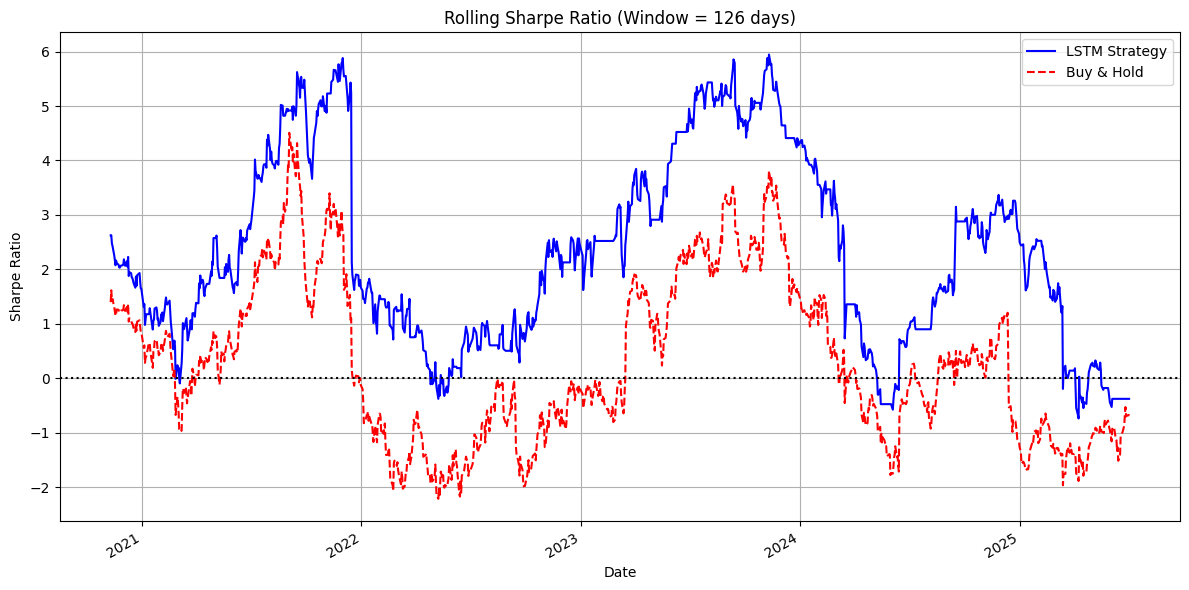

In [190]:
# Ensure both are datetime-indexed and timezone-aware
ret1 = pd.Series(df_strategy["return"], index=pd.to_datetime(df_strategy.index)).tz_localize('UTC')
ret2 = pd.Series(df_strategy["LSTM return"], index=pd.to_datetime(df_strategy.index)).tz_localize('UTC')

# Drop NaNs if necessary
ret1 = ret1.dropna()
ret2 = ret2.dropna()

# Compute rolling Sharpe ratios
window = 126  # ~6 months if daily
roll_sharpe_1 = timeseries.rolling_sharpe(ret1, rolling_sharpe_window=window)
roll_sharpe_2 = timeseries.rolling_sharpe(ret2, rolling_sharpe_window=window)

# Plot
plt.figure(figsize=(12, 6))
roll_sharpe_2.plot(label='LSTM Strategy', color="blue")
roll_sharpe_1.plot(label='Buy & Hold', color="red", linestyle="dashed")

plt.title(f"Rolling Sharpe Ratio (Window = {window} days)")
plt.ylabel("Sharpe Ratio")
plt.xlabel("Date")
plt.axhline(0, color='black', linestyle=':')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Observations from the rolling Sharpe ratio comparison:

- LSTM strategy maintains consistently higher Sharpe ratios than buy-and-hold across all periods.

- Both strategies follow similar trends, indicating shared market exposure, but LSTM exhibits stronger resilience.

- LSTM stays largely above zero, reflecting sustained positive risk-adjusted returns.

- During major drawdowns (e.g., late 2021–mid 2022 and late 2023–mid 2024), the LSTM strategy shows less severe declines and quicker recoveries, indicating better downside control.

Overall, the visualization highlights the LSTM strategy’s great ability to navigate volatile market conditions while preserving return consistency. Its elevated and stable Sharpe ratios shows effective signal learning and risk management.

[**Back to Content**](#content)

<a id='5.3'></a>
## 5.3 Underwater curve analysis

An underwater curve is a visual representation of drawdowns over time — it shows how far an investment is below its previous peak.

$$\text{Underwater} = \frac{\text{Current Cumulative Return}}{\text{Historical Peak}} - 1$$
The values are always smaller than or equal to zero (zero means it's at a peak), and more negative means deeper drawdown.

We can still use the daily return information from the LSTM strategy and the buy-and-hold approach to calculate their underwater values in the past 5 years and visualize them accordingly.

In [191]:
ret1

date
2020-05-14 00:00:00+00:00   -0.009
2020-05-15 00:00:00+00:00    0.028
2020-05-18 00:00:00+00:00    0.007
2020-05-19 00:00:00+00:00    0.011
2020-05-20 00:00:00+00:00    0.031
                             ...  
2025-06-25 00:00:00+00:00    0.014
2025-06-26 00:00:00+00:00   -0.007
2025-06-27 00:00:00+00:00    0.002
2025-06-30 00:00:00+00:00    0.003
2025-07-01 00:00:00+00:00    0.013
Name: return, Length: 1289, dtype: float64

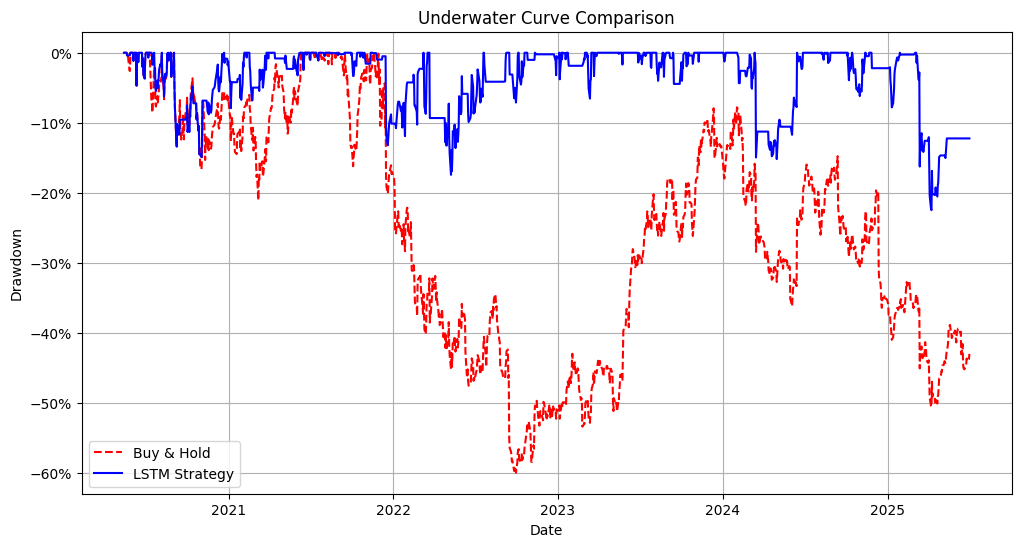

In [192]:
# Calculate cumulative returns
cum_ret_a = (1 + ret1).cumprod()
cum_ret_b = (1 + ret2).cumprod()

# Drawdown from peak
underwater_a = cum_ret_a / cum_ret_a.cummax() - 1
underwater_b = cum_ret_b / cum_ret_b.cummax() - 1

# Plot
plt.figure(figsize=(12,6))
plt.plot(underwater_a, label="Buy & Hold", color="red", linestyle="dashed")
plt.plot(underwater_b, label="LSTM Strategy", color="blue")
plt.title("Underwater Curve Comparison")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.grid(True)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))  # Format y-axis as %
plt.legend()

Observations from the underwater curve comparison:
- LSTM strategy exhibits frequent recovery to new highs, keeping its drawdowns shallow and short-lived. Most underwater periods remain above $-20\%$, and recovery often occurs within months.

- In contrast, the buy-and-hold approach suffers from long and deep drawdowns, including multi-year recovery periods and max drawdowns reaching $-60\%$.

- The volatility of drawdowns in LSTM is much lower than that of buy-and-hold, indicating better risk control from the baseline model.

- In recent years, especially from 2022 to 2025, LSTM’s ability to recover quickly after market downturns contrasts sharply with buy-and-hold’s persistent underwater state.

The underwater plot clearly shows that the LSTM strategy provides strong downside protection and quicker recovery compared to the buy-and-hold approach. While both strategies experience drawdowns during turbulent periods, LSTM’s drawdowns are more contained and typically followed by swift rebounds, indicating stronger resilience. 

[**Back to Content**](#content)

<a id='5.4'></a>
## 5.4 Pyfolio analysis ##
Pyfolio is a Python library for analyzing portfolio performance and risk management, making it especially valuable for evaluating backtested trading strategies. It provides a comprehensive set of metrics to assess a strategy’s effectiveness.

Below are the metrics provided by Pyfolio to evaluate the backtesting of the LSTM strategy and buy-and-hold approach.

In [193]:
pf.show_perf_stats(df_strategy["LSTM return"])

/opt/anaconda3/envs/py310/lib/python3.10/site-packages/pyfolio/plotting.py:650: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '62.4%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100,


In [194]:
pf.show_perf_stats(df_strategy["return"])

/opt/anaconda3/envs/py310/lib/python3.10/site-packages/pyfolio/plotting.py:650: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.8%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100,


Observations from the metrics by Pyfolio:
- LSTM strategy achieved $62.4\%$ annual return, much higher than $1.8\%$ from the buy-and-hold. The gap of cumulative returns ($1094.1\%$ vs. $9.4\%$) is also quite significant.

- Sharpe ratio ($1.99$) and Sortino ratio ($3.04$) indicate strong risk-adjusted returns for LSTM; buy-and-hold lags far behind with Sharpe of $0.23$ and Sortino of $0.31$.

- LSTM volatility is lower ($26.1\%$) compared to buy-and-hold ($36.0\%$), showing more stable performance despite higher returns.

- Max drawdown is much smaller for LSTM ($-22.5\%$) than buy-and-hold ($-60\%$), signaling better downside protection. This was also discussed in the waterdown curve analysis.

**The LSTM strategy demonstrates not just impressive returns, but a good balance of profitability and risk management. It offers a significantly more attractive and robust approach for navigating volatile markets, making it a strong candidate for active trading.**

[**Back to Content**](#content)

<a id='6'></a>
# 6. Conclusion

In this project, I explored the application of LSTM-based deep learning models in predicting upward movements of Adobe stock, and designed a strategy that outperforms traditional approaches in both returns and risk control.

Through a comprehensive process — from sourcing and cleaning data, crafting features using diverse techniques, and performing exploratory analysis with multicollinearity reduction and scaling — to building and tuning baseline and variant models, the workflow reflects a rigorous approach of quantitative modeling.

Beyond the technical outcomes, this project was a valuable learning experience for me as well. It deepened my understanding of deep learning in finance, enhanced my modeling skills, and strengthened my command of Python programming and modern ML libraries. I’m grateful to the CQF program for equipping me with the skills to complete this project, and to my family for their unwavering support during this intensive learning phase.

[**Back to Content**](#content)